## Convolutional Neural Networks Series

#  1D Convolution

In [1]:
# imports from custom library (this won't be shown in the HTML version)
import sys
sys.path.append('../../')
import matplotlib.pyplot as plt
plt.rc('text', usetex=True)
from mlrefined_libraries import convnets_library as convlib
from mlrefined_libraries import basics_library as baslib
import autograd.numpy as np
import pandas as pd
import cv2

#this is needed to compensate for matplotlib notebook's tendancy to blow up images when plotted inline
%matplotlib notebook
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

%load_ext autoreload
%autoreload 2

We begin our discussion of the convolution operation by first focusing on one-dimensional data. In machine learning and deep learning, the most common type of one-dimensional data one typically deals with is *time-series* data taking the form

\begin{equation}
\left(t_1,x\left(t_1\right)\right),\, \left(t_2,x\left(t_2\right)\right),\, \ldots,\, \left(t_N,x\left(t_N\right)\right)
\end{equation}

where the inputs $t_1,\ldots,t_N$ are time marks sorted in ascending order (that is, $t_1<t_2<\cdots<t_N$), with $x\left(t_1\right),\ldots,x\left(t_N\right)$ denoting their corresponding output values respectively. Figure 1 shows a prototypical time-series data where every two successive data points, i.e., $\left(t_n,x\left(t_n\right)\right)$ and $\left(t_{n+1},x\left(t_{n+1}\right)\right)$, are connected via a line segment. This - typically referred to as *linear interpolation* - makes the visualization of time-series data much easier. 

<figure>
<img src="../../mlrefined_images/convnet_images/prototypical_time_series.png" width="80%" height="auto"/>
<figcaption> <strong>Figure 1:</strong> <em> A prototypical time-series data with $N=6$ data points. For ease of visualization we have connected consecutive points via line segments.</em>
</figcaption>
</figure>

#### <span style="color:#a50e3e;">Example 1. </span>  Daily presidential job approval: a real time-series data

In the Python cell below we plot a real example of time-series data where the output $x$ (across the vertical axis) is the daily job approval ratings for the 45th president of the United States according to the American Presidency Project (APP) at the University of California, Santa Barbara [[1]](#bib_cell).

<IPython.core.display.Javascript object>


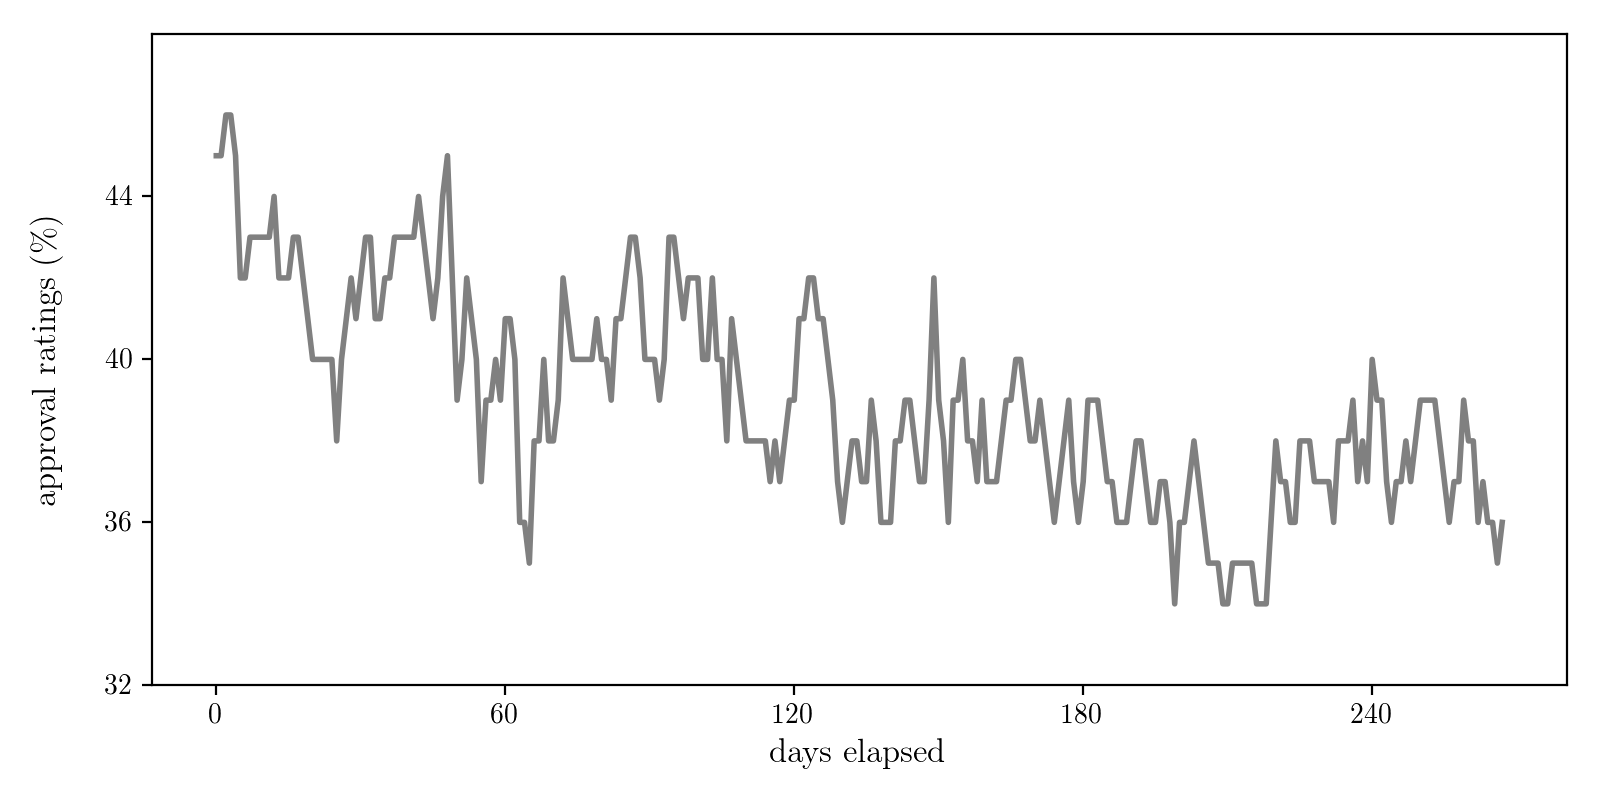

In [45]:
data_path = "../../mlrefined_datasets/nonlinear_superlearn_datasets/job_approval_data.csv"

# plot time-series data
convlib.conv_1d_viz.plot_time_series(data_path)

<hr>

Time-series data is often collected at equally-spaced time marks. For instance, the job approval poll shown in Example 1 was taken every day since the 45th president assumed office on January 20, 2017. In general, the time distance between two successive observations can be smaller or larger than a day. For example, stock exchanges around the world typically publish their data every few minutes (and in some cases every few seconds) whereas the federal spending as a percentage of GDP in the United States, again a time-series data, is published only once every year. Regardless of the temporal resolution, as long as the data is taken at equally-spaced points in time, we can drop the time marks $t_1,\ldots,t_N$ and treat the data in equation (1) as a sequence   

\begin{equation}
x_1,\, x_2,\, \ldots,\, x_N 
\end{equation}

where $x$ is only indexed by the integers $1$ through $N$. This not only simplifies the notation considerably, but more importantly as we will see soon, makes convolution a discrete operation conveniently defined via summation (instead of integration).

Going back to our time-series data in Example 1, notice that it does not appear smooth but rather jagged. The rapid fluctuation in the data not only makes it difficult to understand and summarize the overall trend during the observation period, but is also somewhat counterintuitive because we expect the public opinion on a president's job performance to not change rapidly from one day to the next. This behavior can be attributed to a high-frequency (i.e., rapidly changing) noise riding on the relatively smooth signal that we are trying to observe. An example of such underlying signal is shown in red in the figure generated by the Python cell below.

<IPython.core.display.Javascript object>


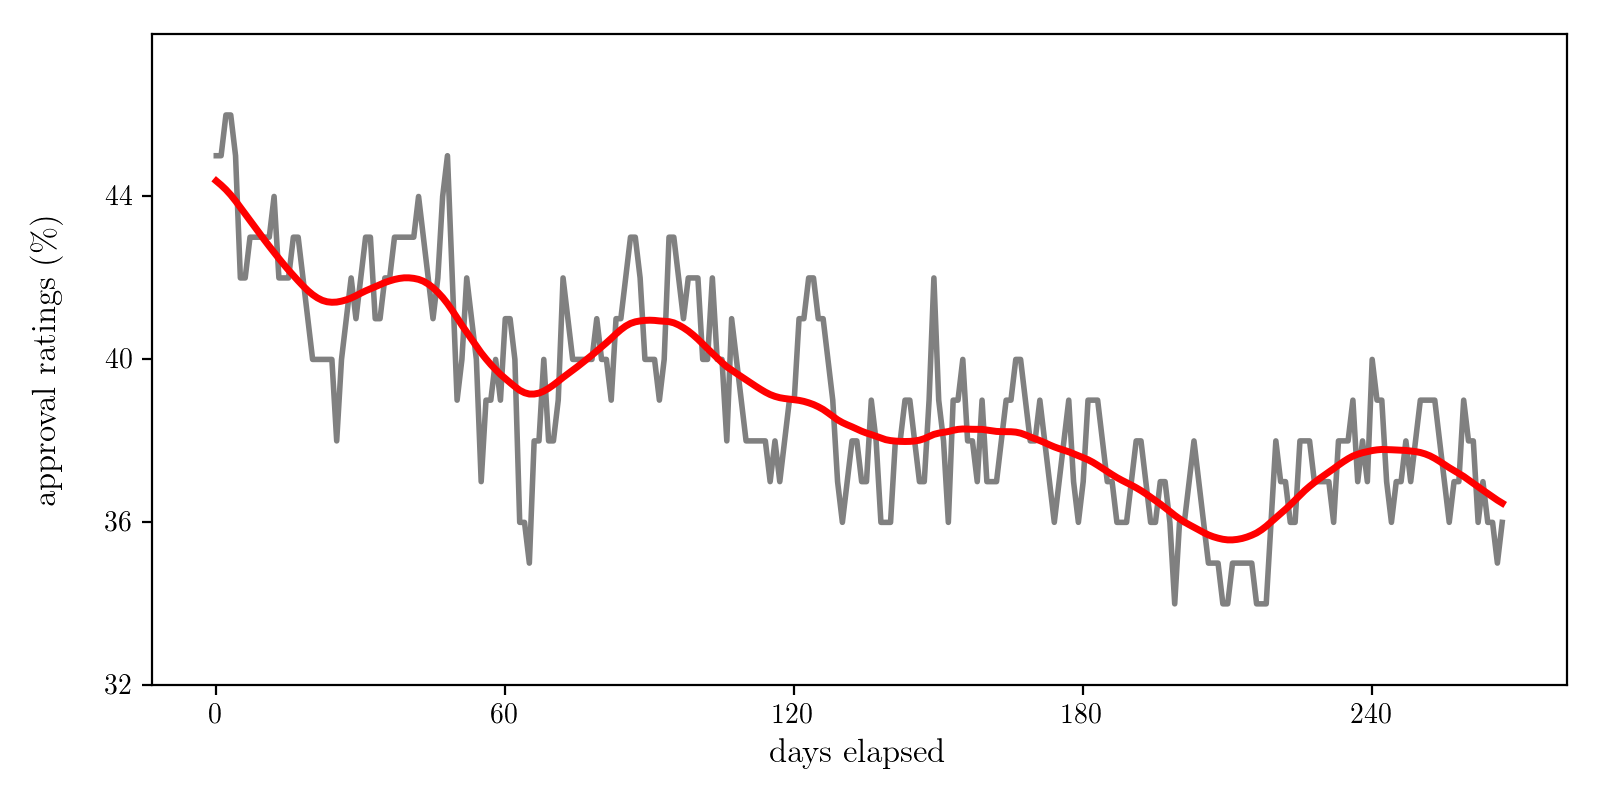

In [42]:
# plot time-series data
convlib.conv_1d_viz.plot_time_series(data_path, plot_convolution=True)

To state the problem more formally, we assume the observed data $x$ is made up of two components: a signal component $s$ and a noise component $\varepsilon$  

\begin{equation}
x_1=s_1+\varepsilon_1\\
x_2=s_2+\varepsilon_2\\
\vdots \\
x_N=s_N+\varepsilon_N
\end{equation}

In order to recover $s$ from $x$ we make two additional, nevertheless realistic, assumptions: that the added noise $\varepsilon$ has zero-mean, and that the signal $s$ is relatively smooth.  

The idea here is astonishingly simple: we compute a simple average of $2L+1$ consecutive observations which, according to equation (3), can be written as 

\begin{equation}
\frac{1}{2L+1}\underset{\ell=-L}{\overset{L}{\sum}}{x_{n+\ell}}=\frac{1}{2L+1}\underset{\ell=-L}{\overset{L}{\sum}}{s_{n+\ell}}+\frac{1}{2L+1}\underset{\ell=-L}{\overset{L}{\sum}}{\varepsilon_{n+\ell}}
\end{equation}

Based on our first assumption on the noise we have that

\begin{equation}
\frac{1}{2L+1}\underset{\ell=-L}{\overset{L}{\sum}}{\varepsilon_{n+\ell}}\approx 0
\end{equation}

and based on our second assumption on the signal we can write

\begin{equation}
\frac{1}{2L+1}\underset{\ell=-L}{\overset{L}{\sum}}{s_{n+\ell}}\approx s_{n}
\end{equation}

Putting equations (4-6) together, we have an (approximate) estimate for $s_n$ 

\begin{equation}
s_n \approx  \frac{1}{2L+1}\underset{\ell=-L}{\overset{L}{\sum}}{x_{n+\ell}}
\end{equation}

#### <span style="color:#a50e3e;">Example 2. </span>  Recovering the signal from the daily presidential job approval data

In the Python cell below we plot the recovered signal $s$ from the data in Example 1 using equation (7) for a range of values for $L=1,\ldots,100$. Moving the slider from left to right, notice how the shape of $s$ (in red) changes as we increase $L$.    


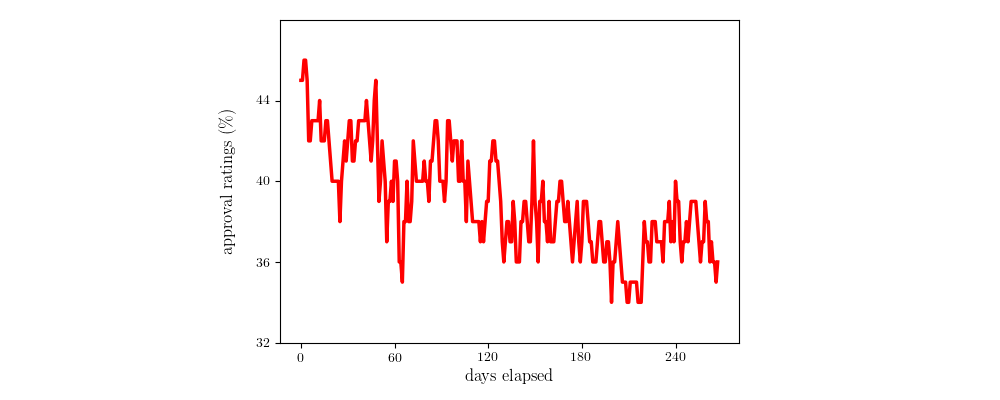
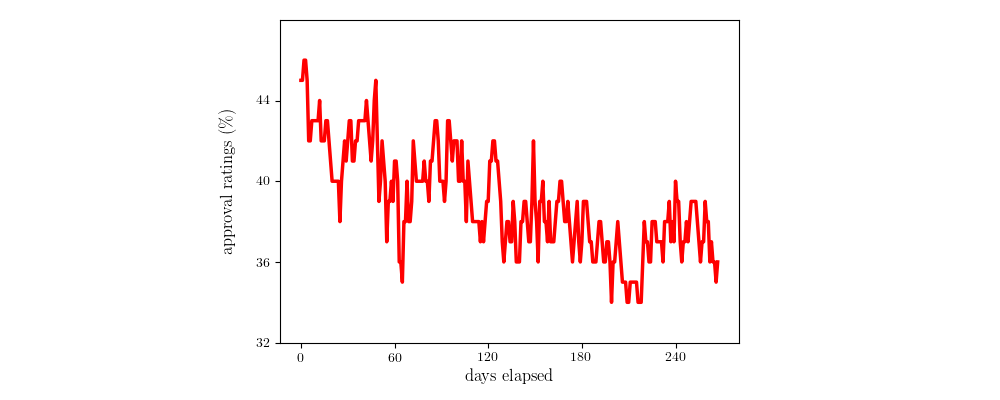
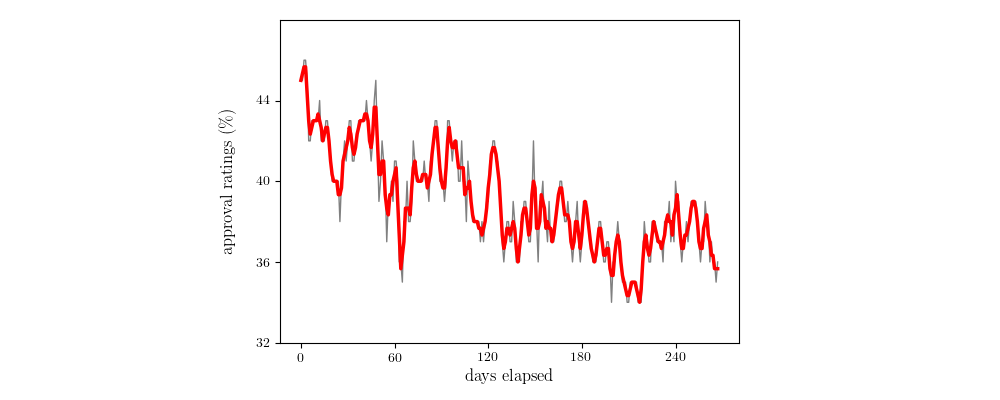
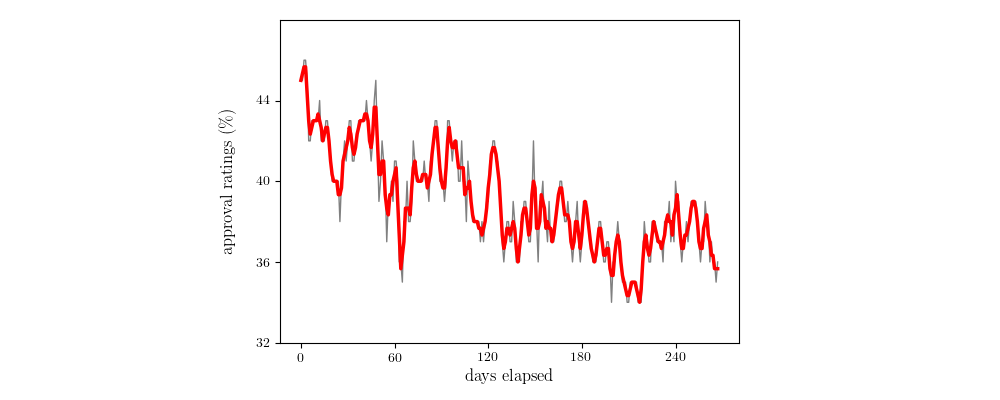
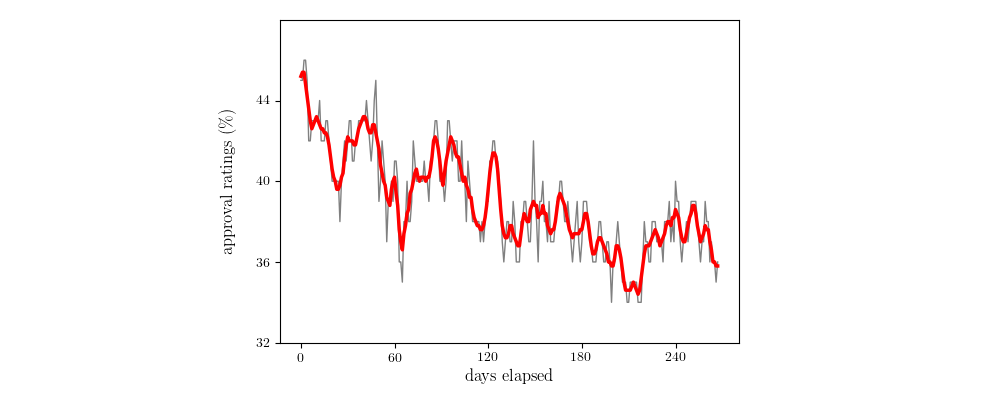
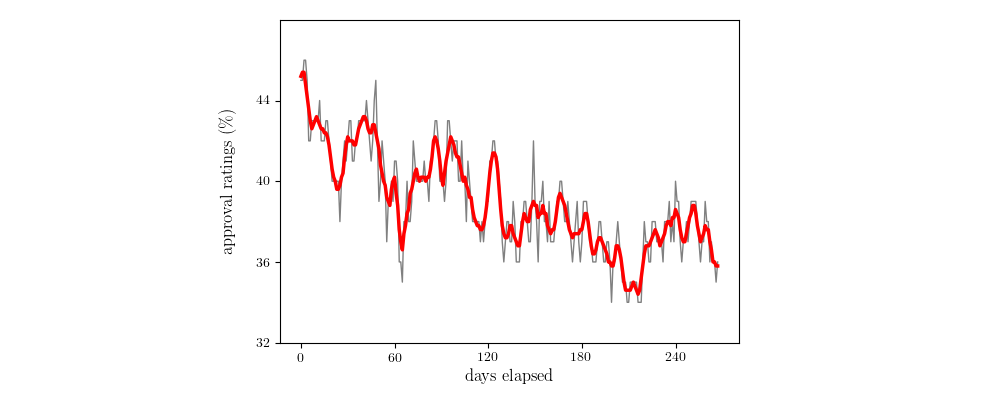
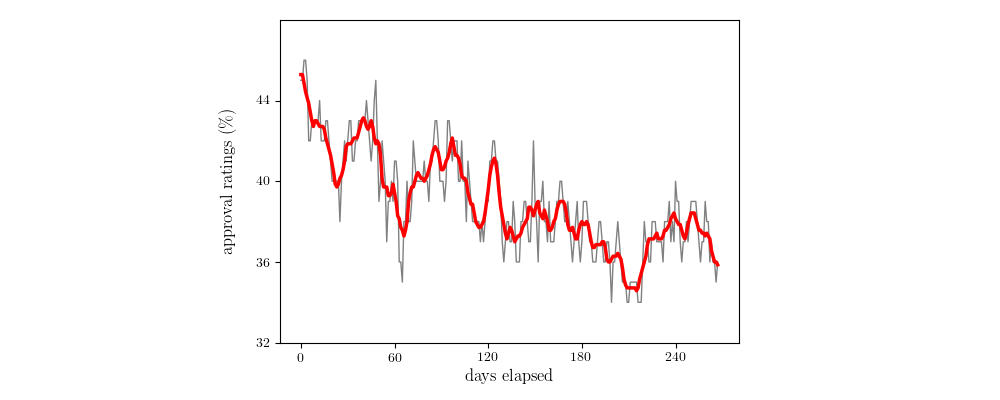
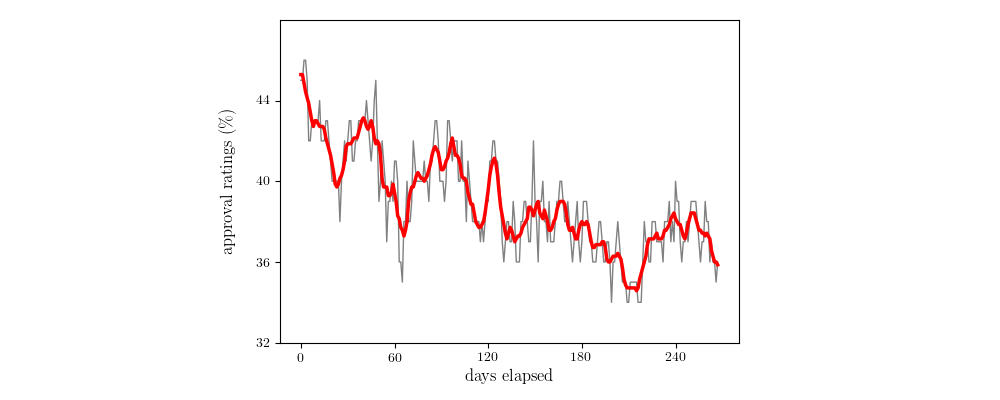
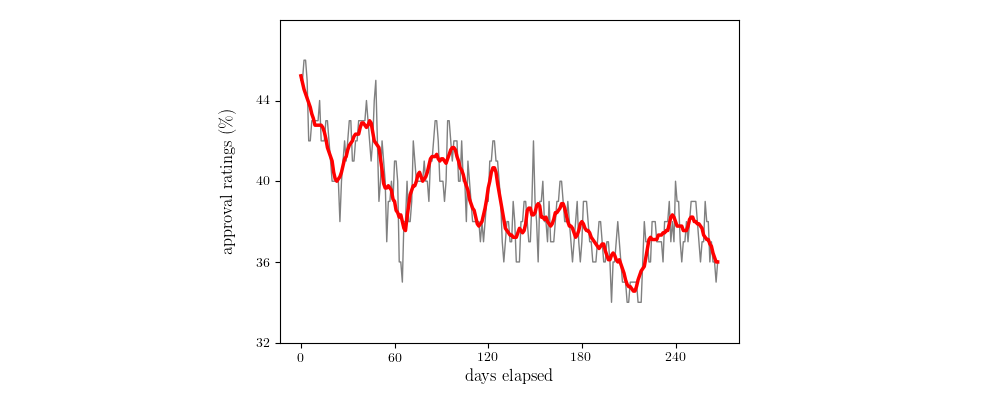
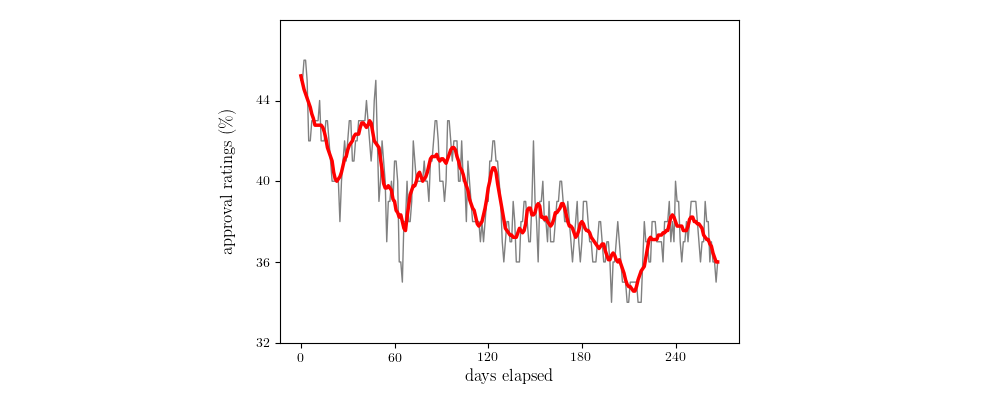
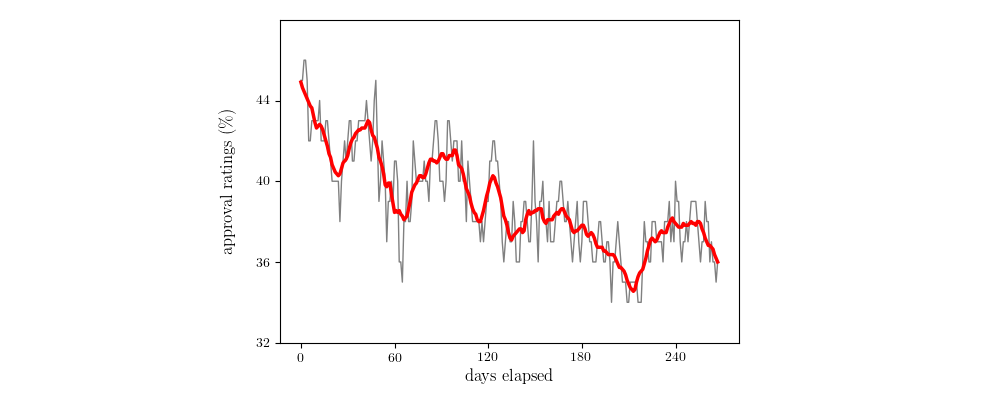
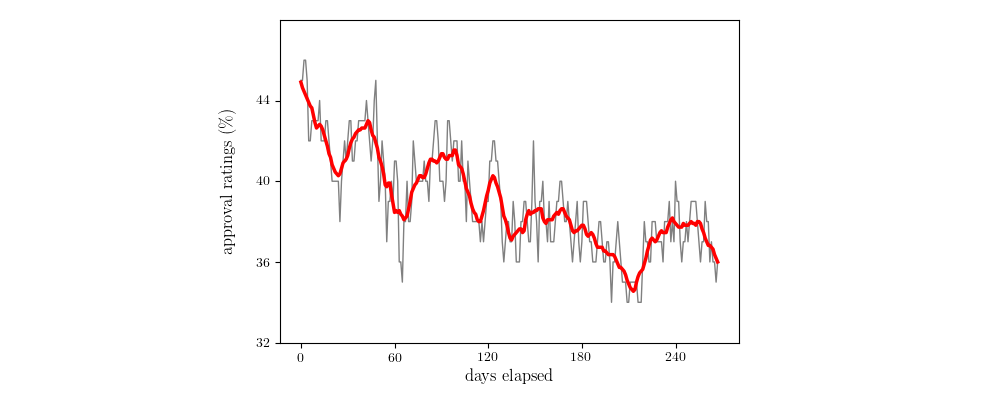
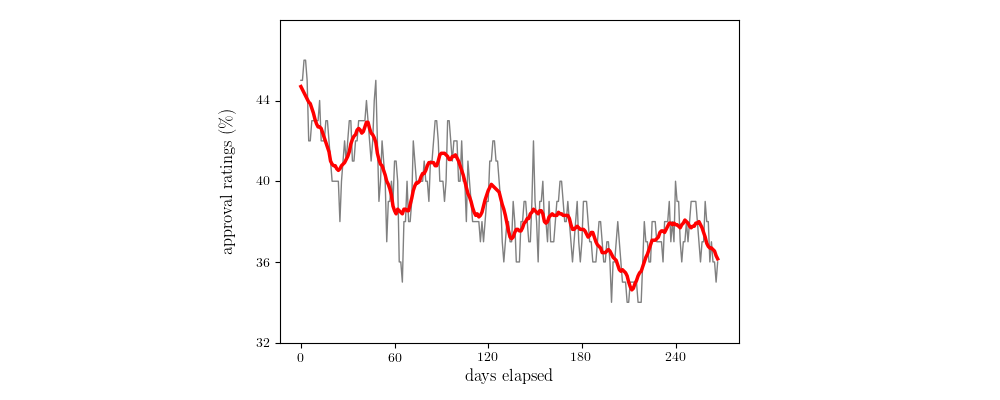
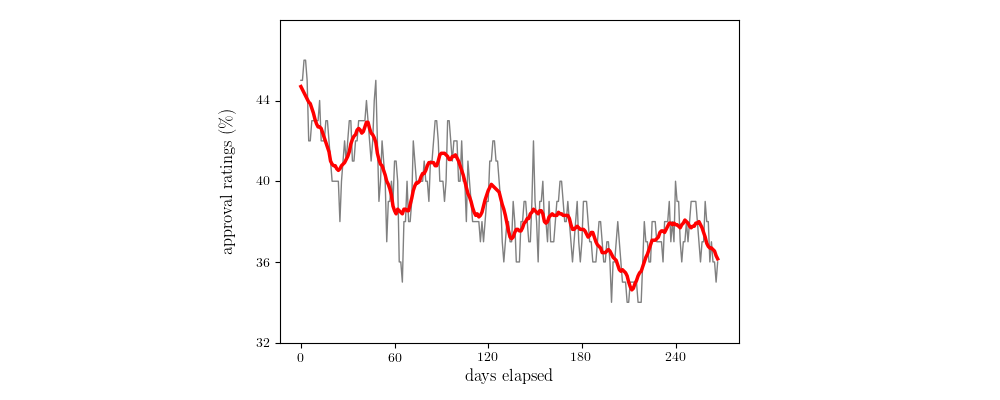
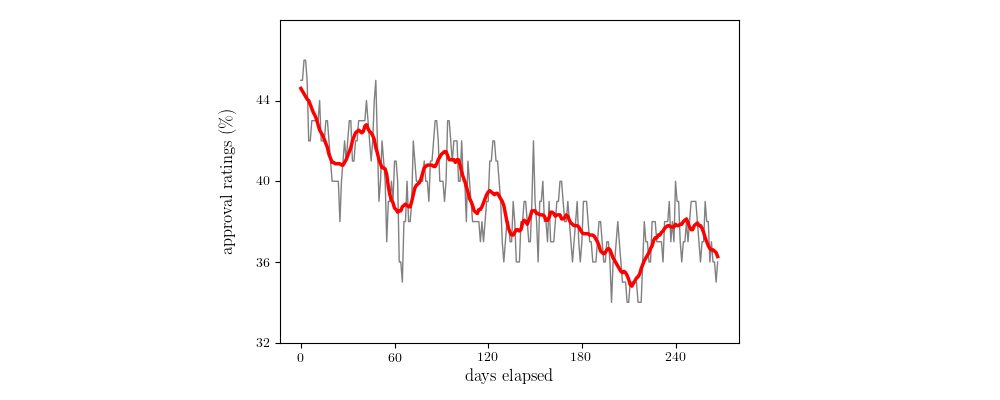
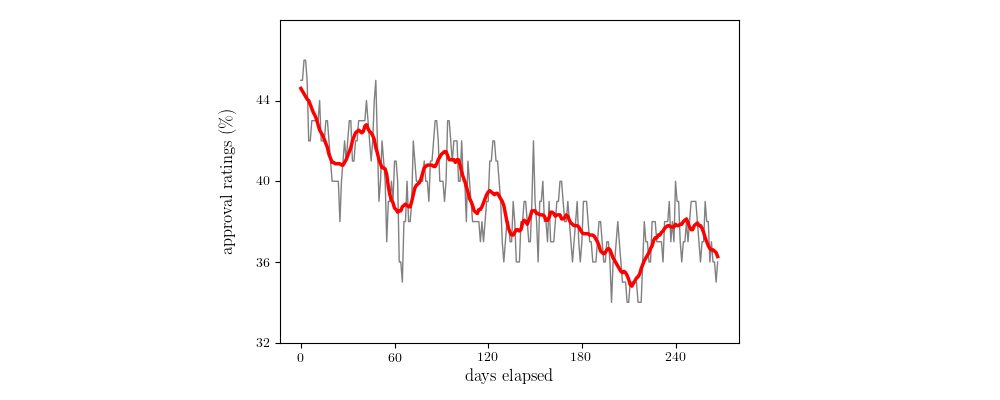
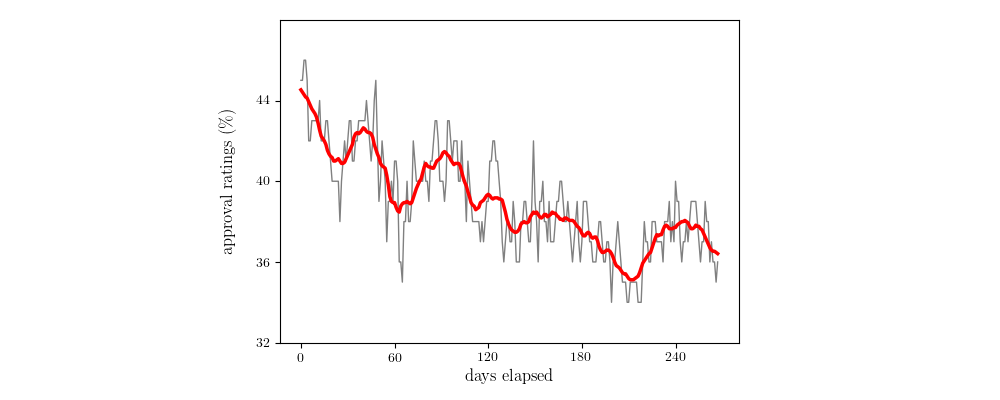
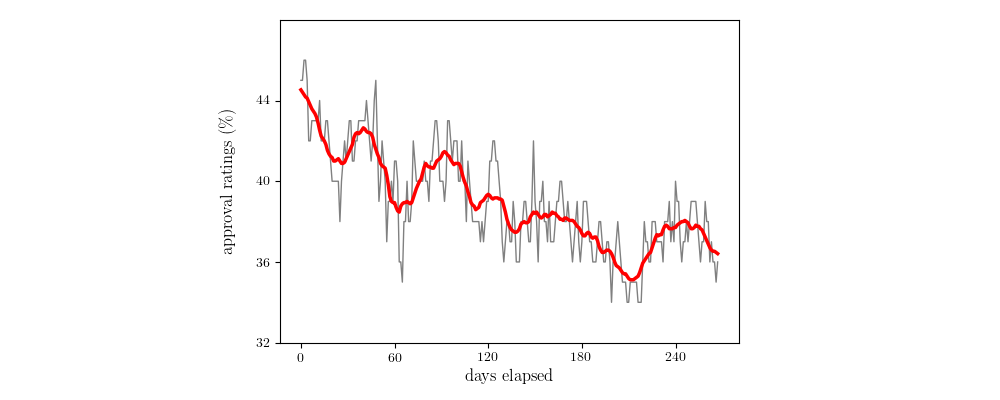
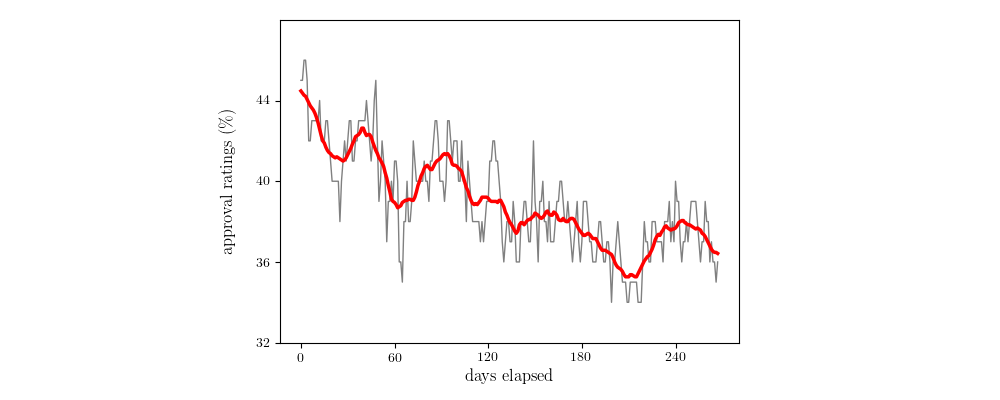
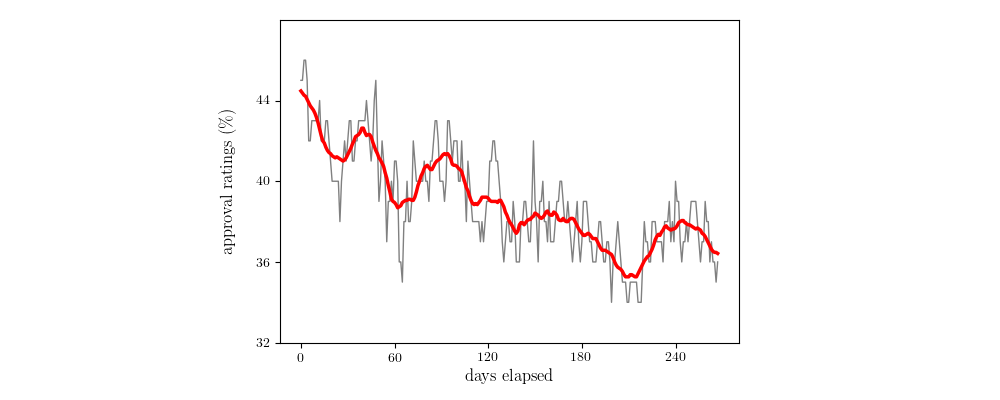
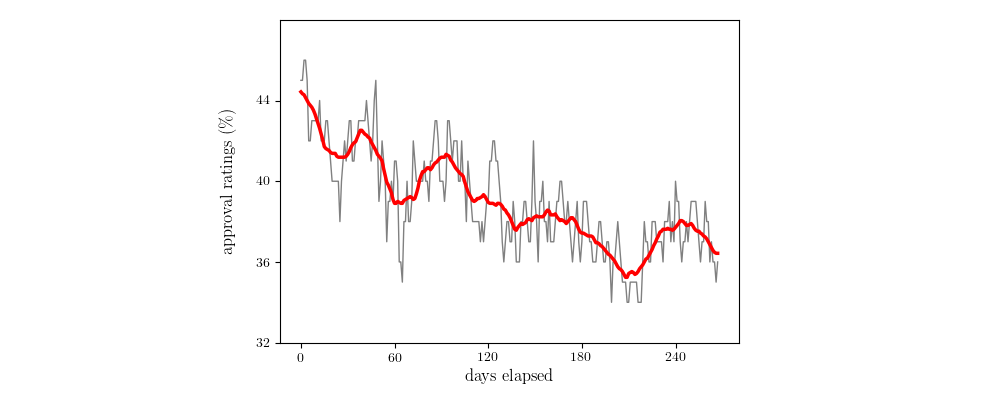
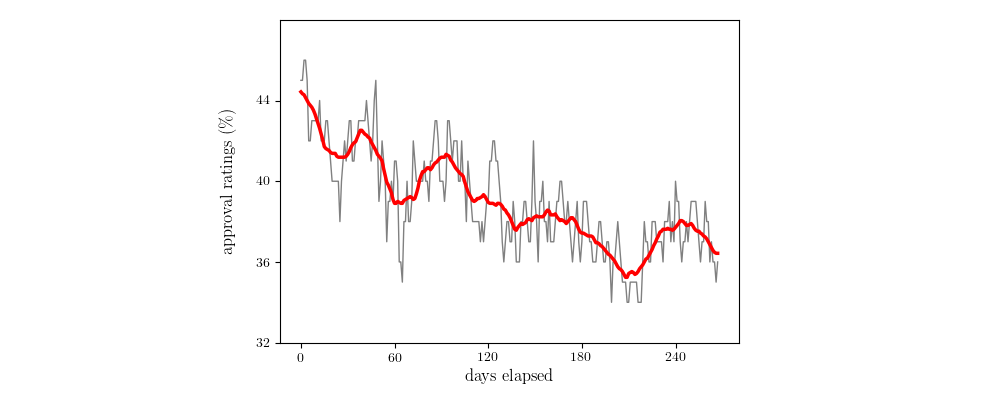
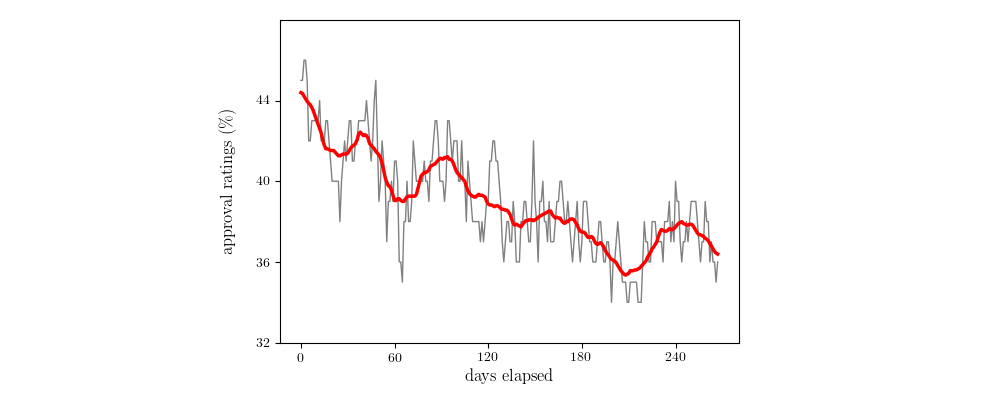
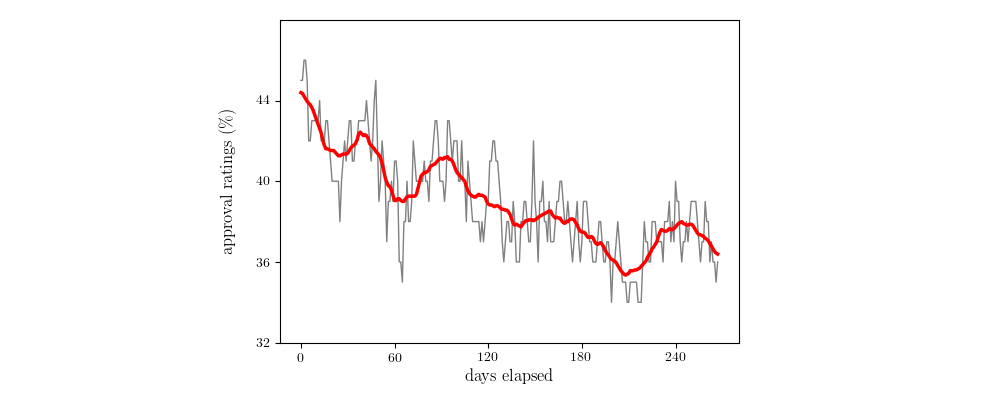
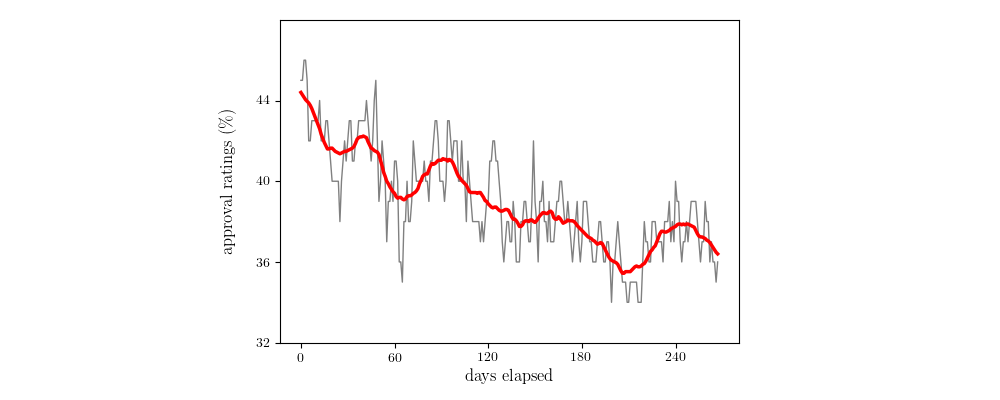
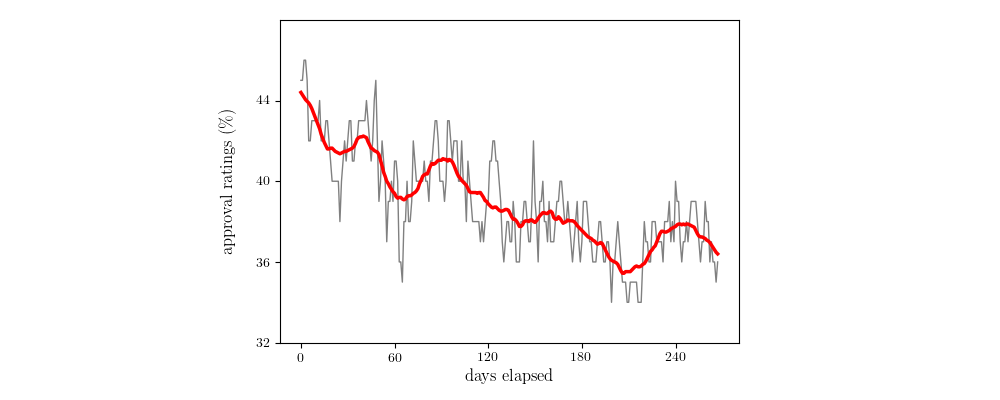
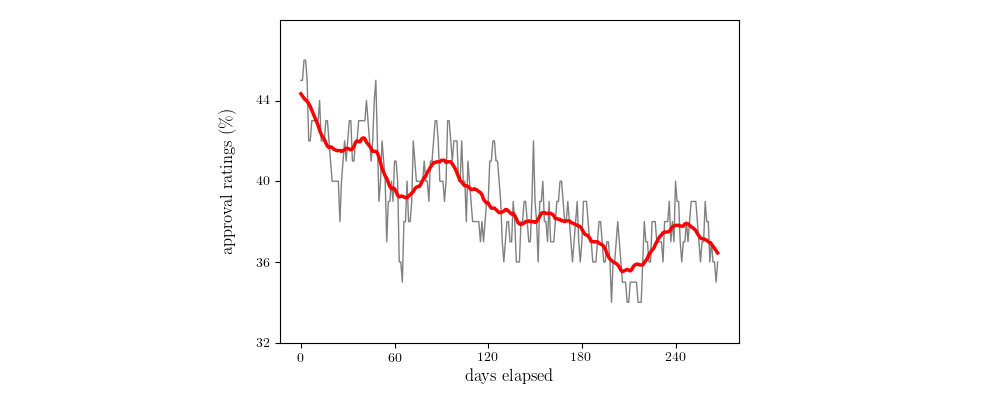
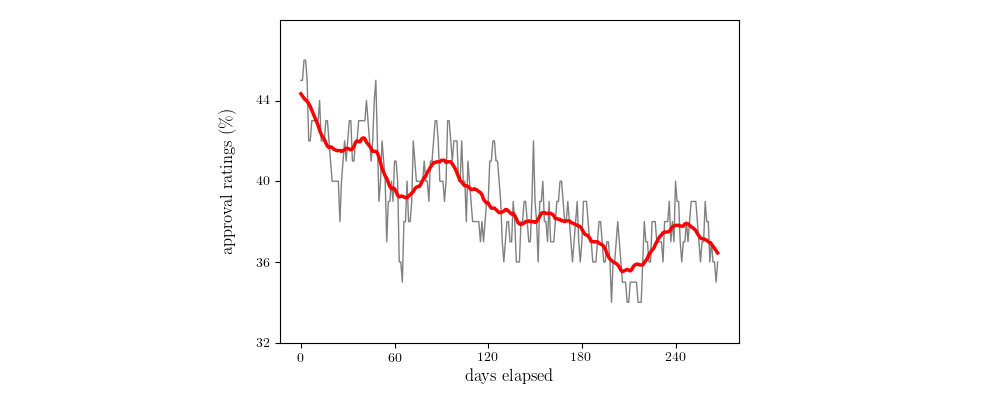
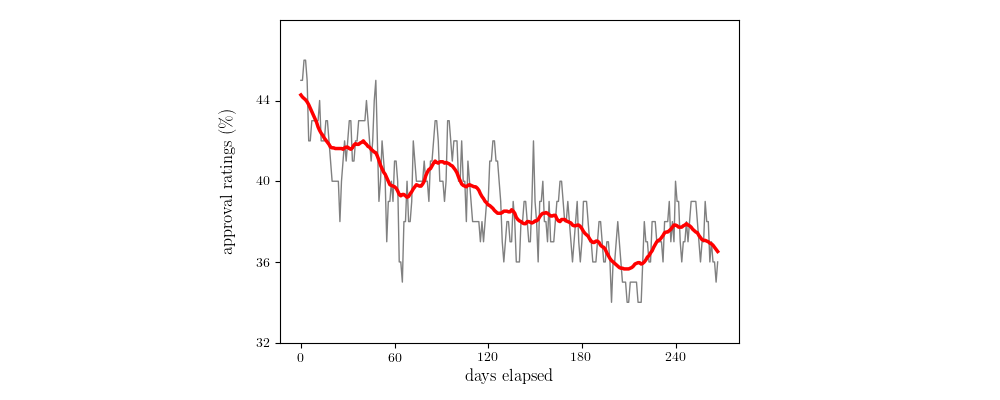
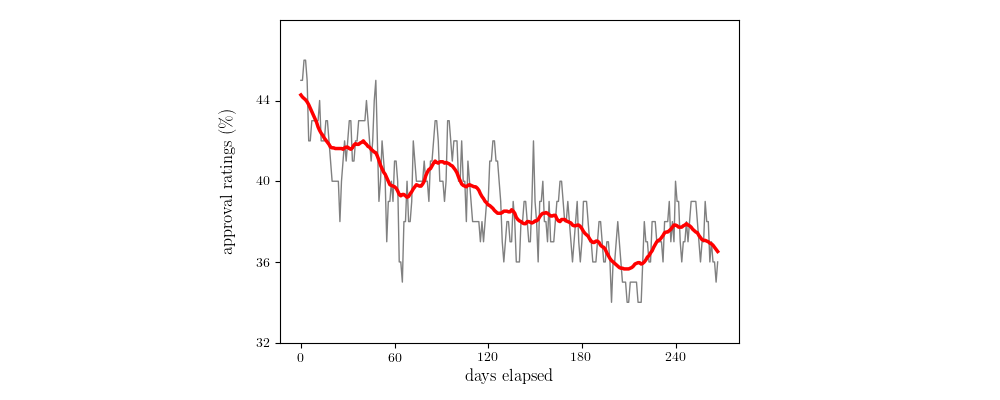
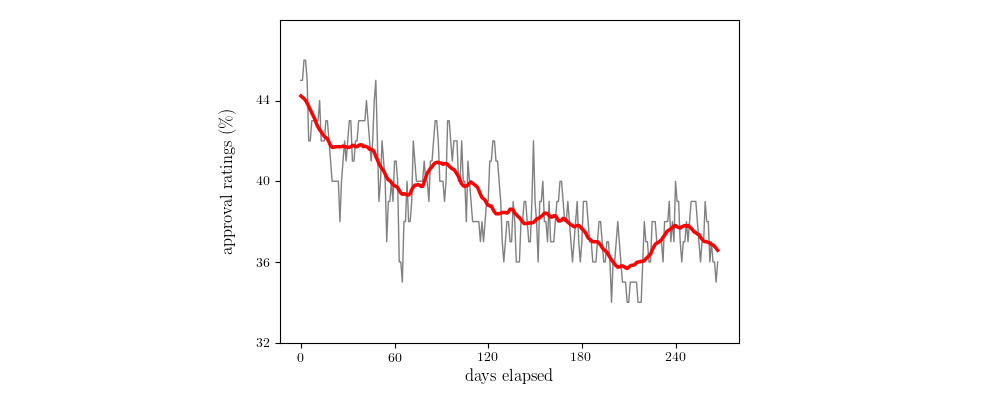
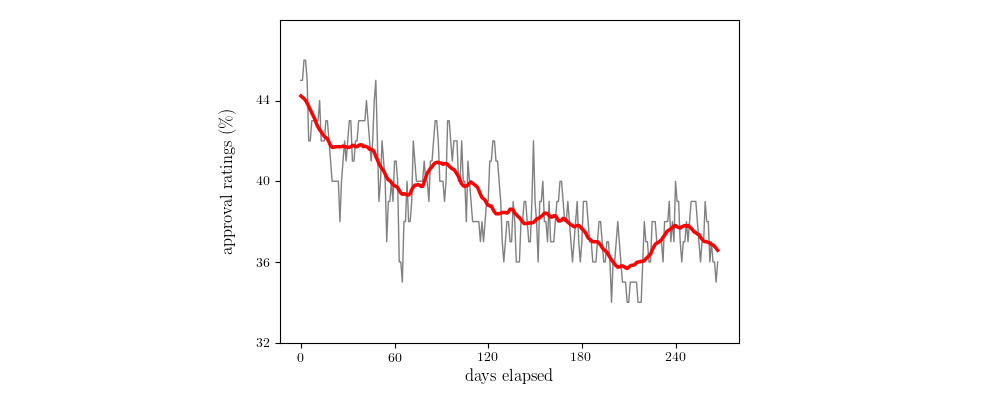
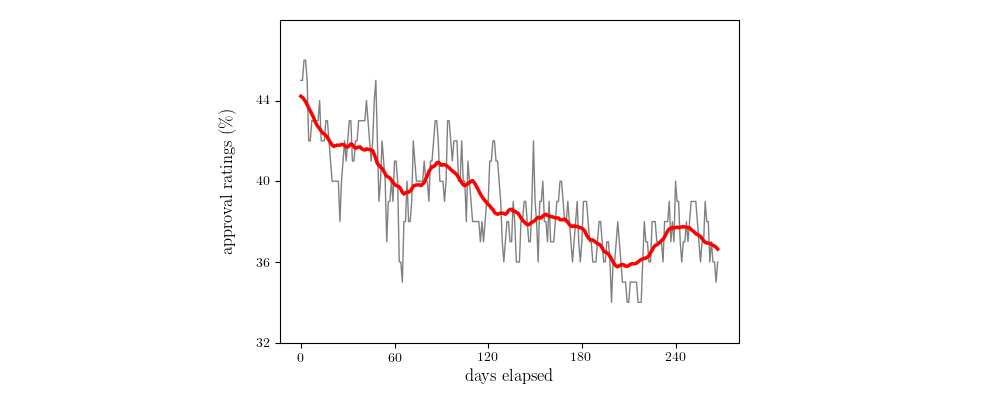
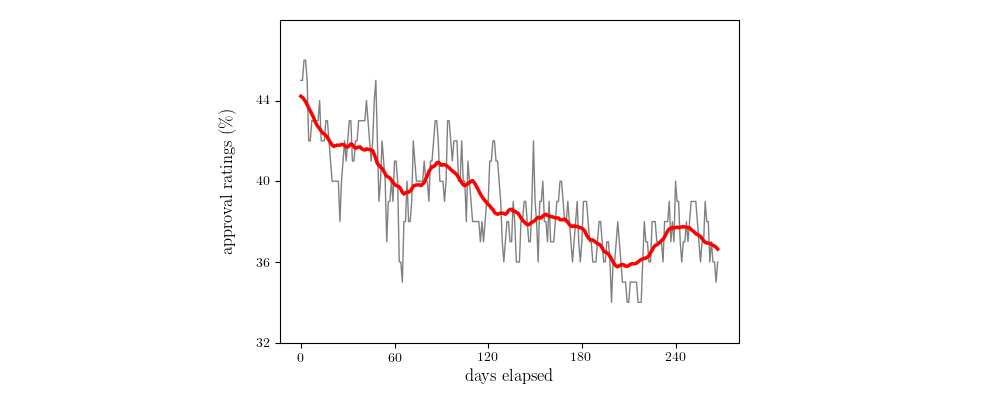
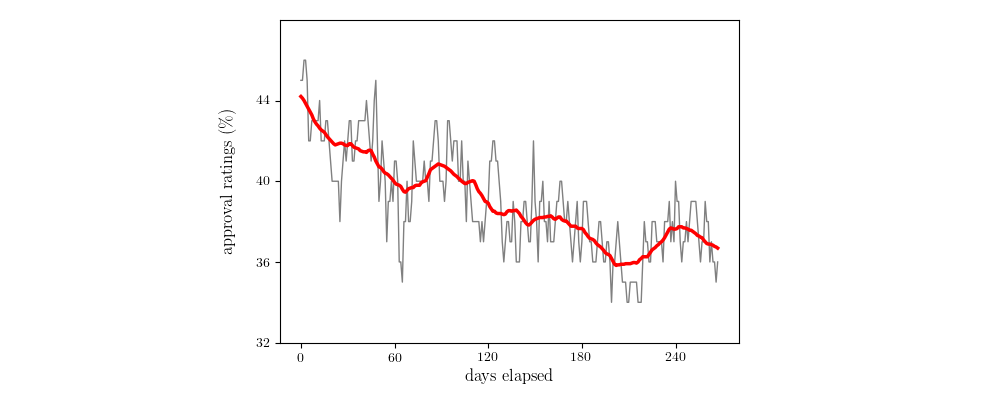
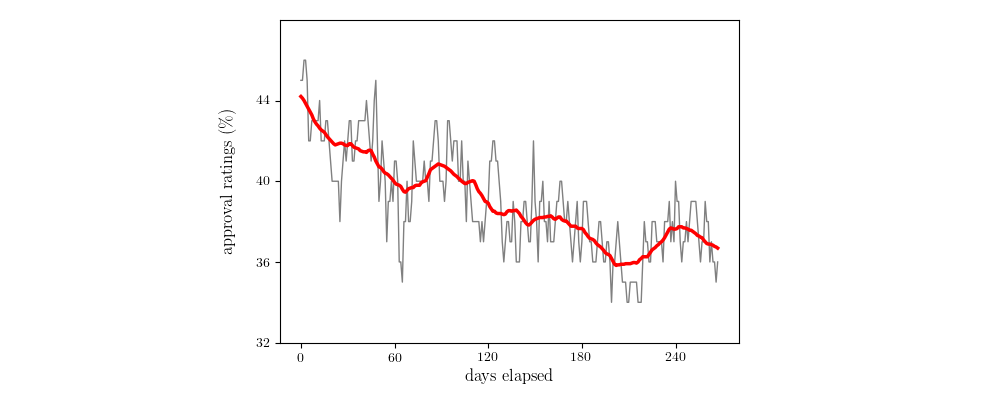
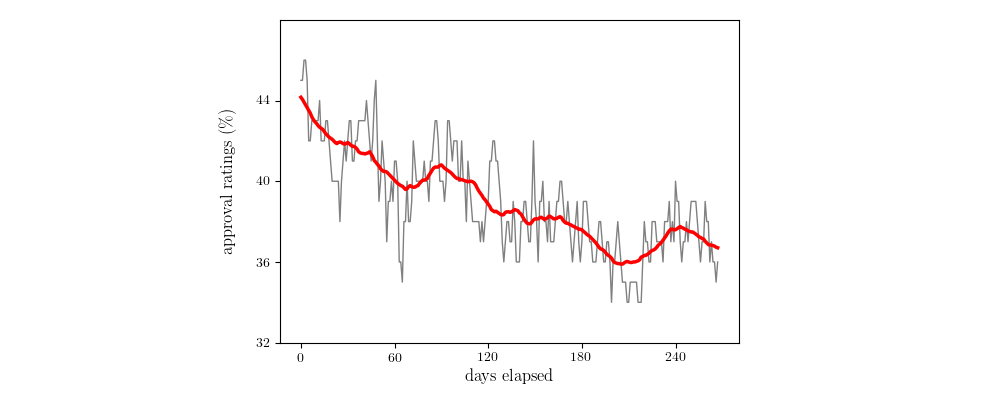
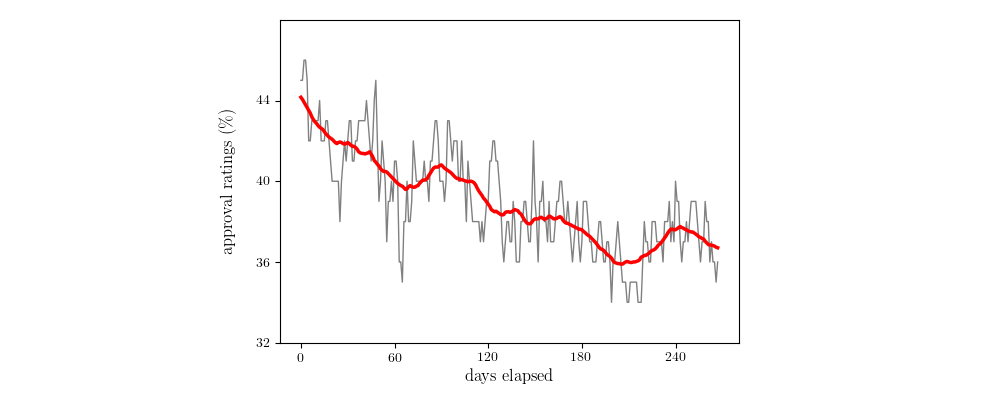
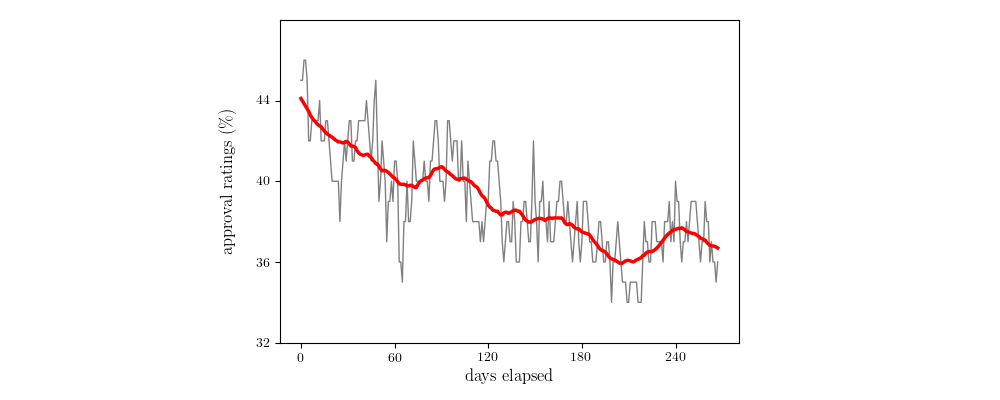
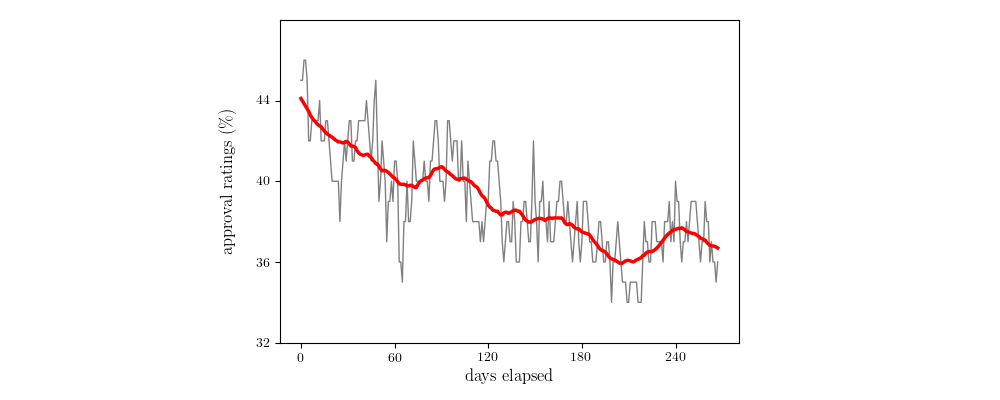
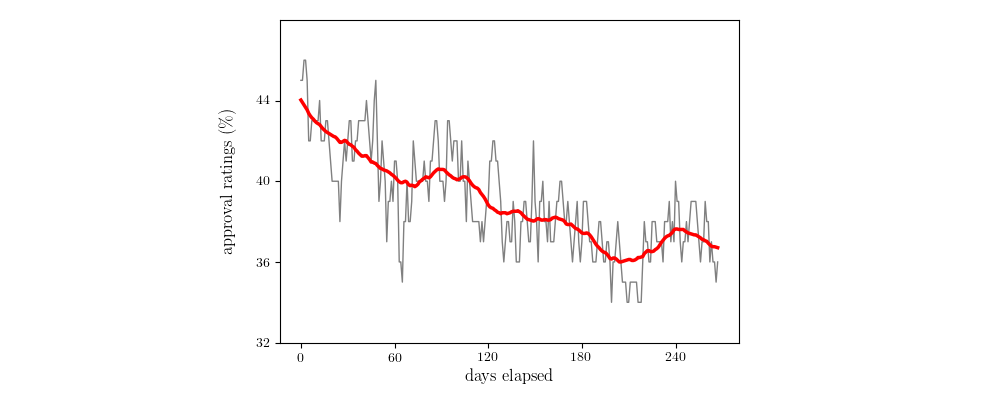
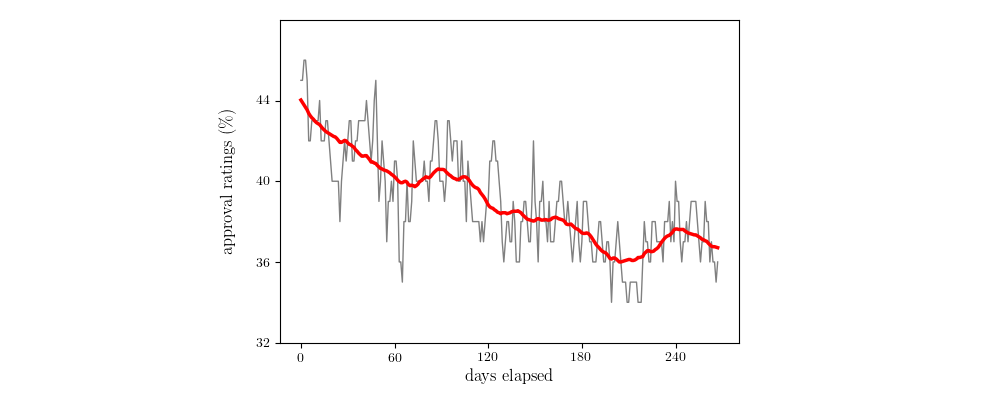
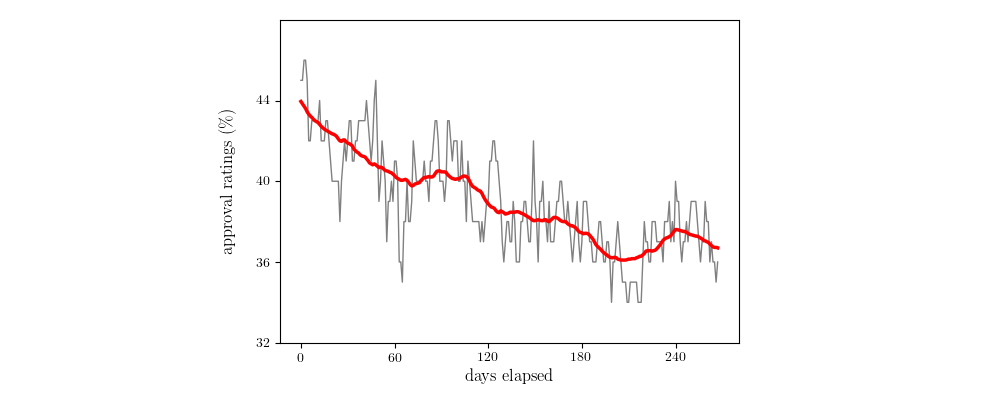
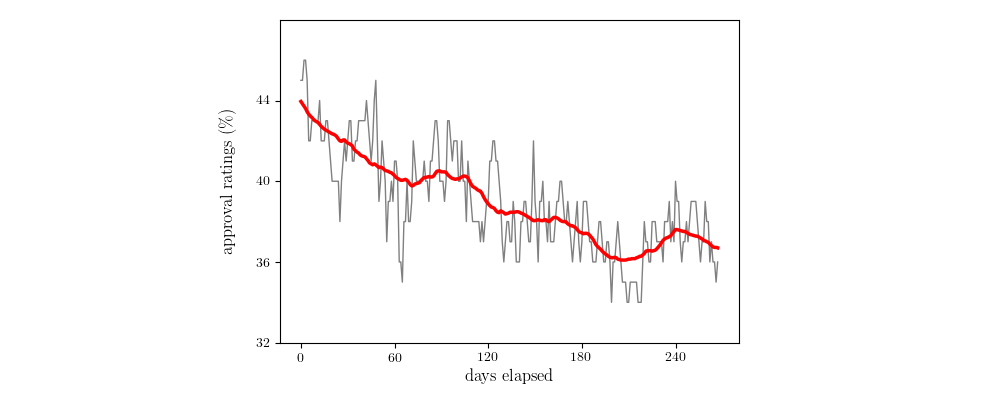
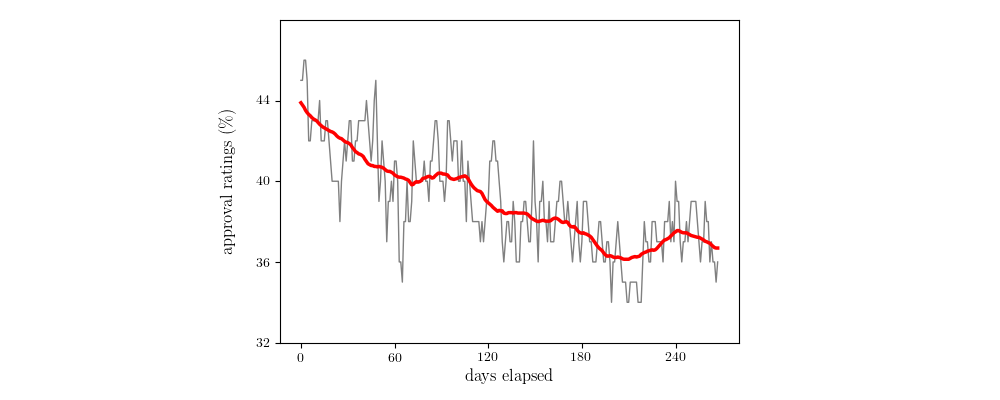
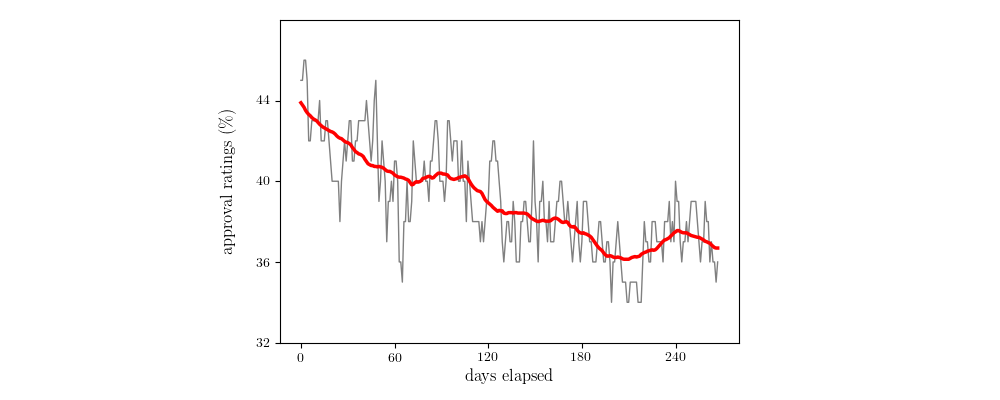
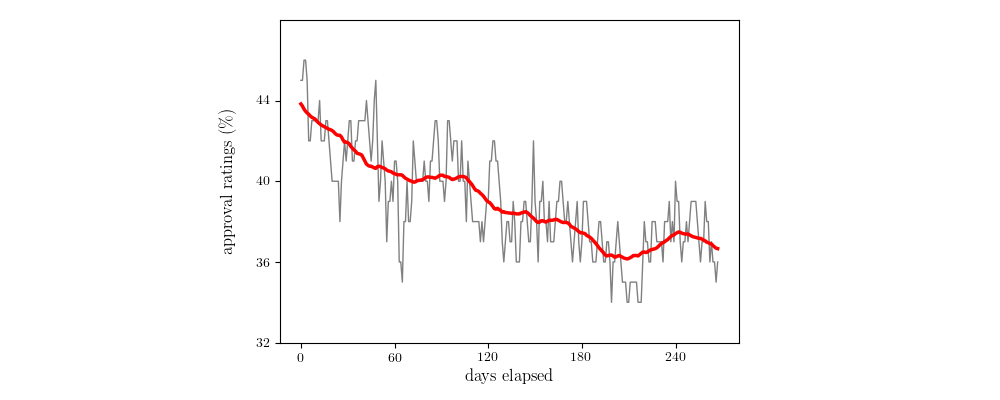
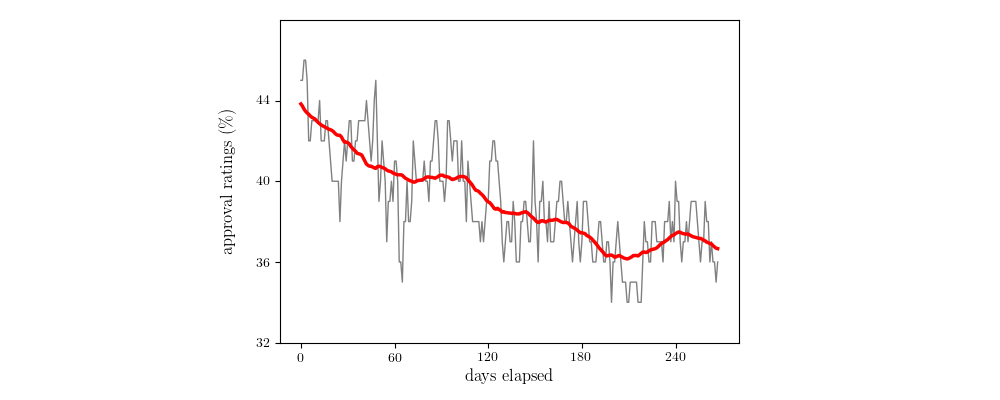
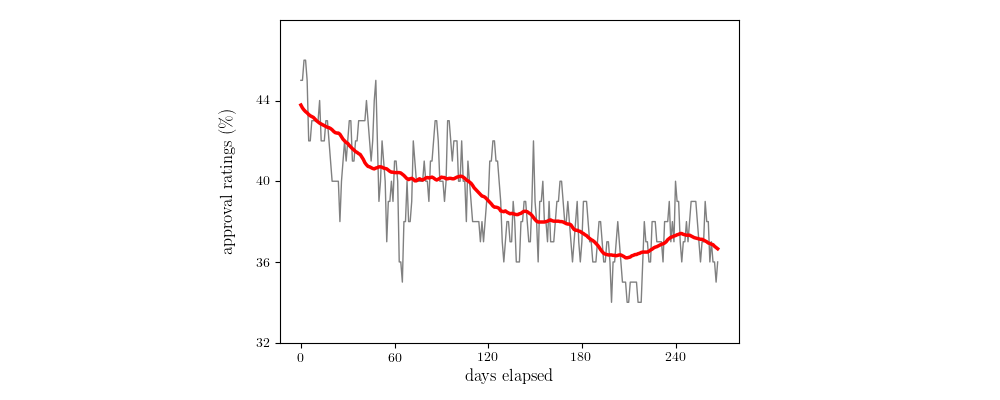
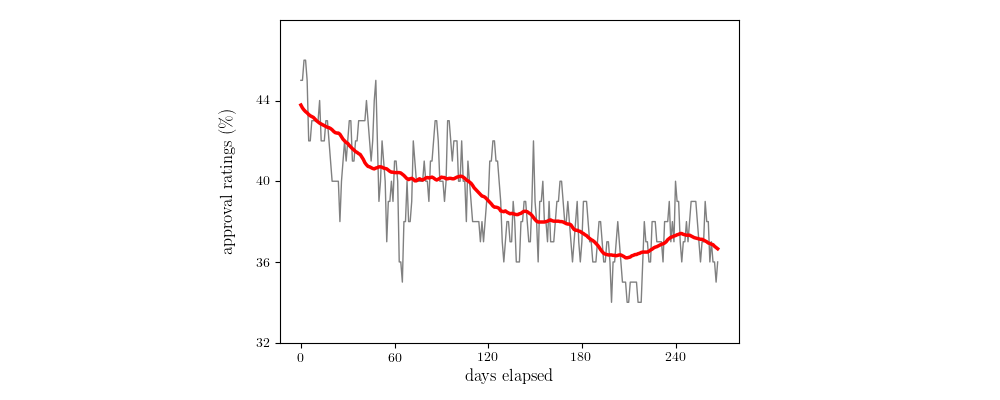
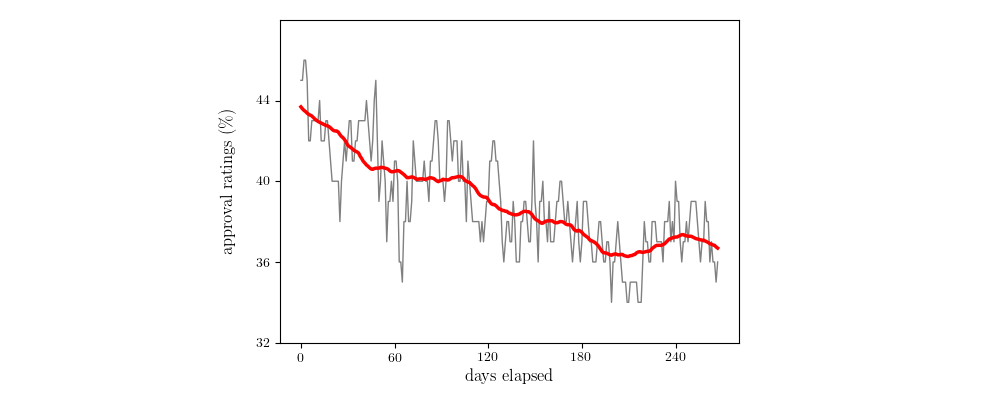
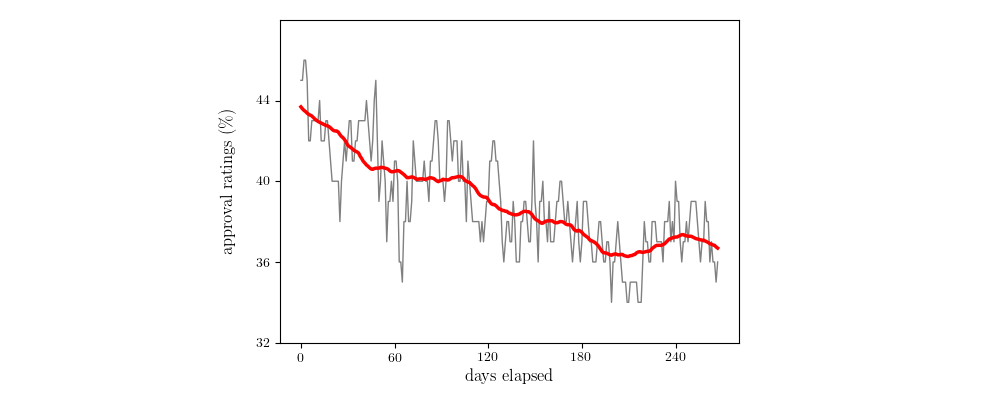
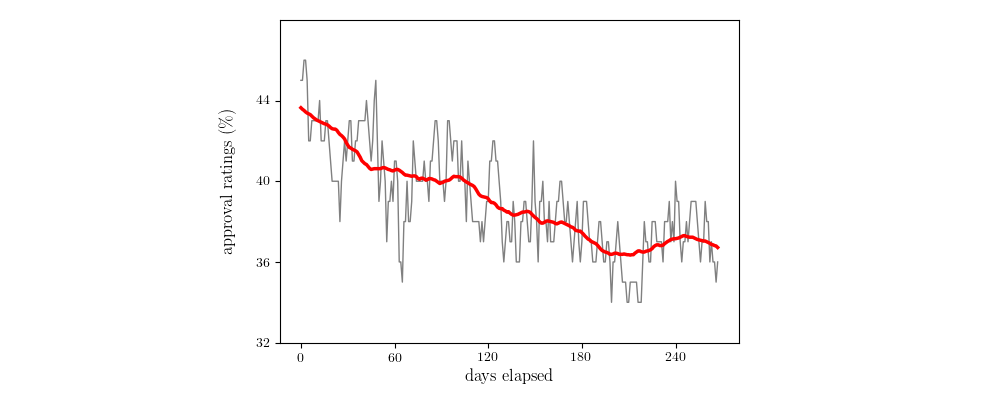
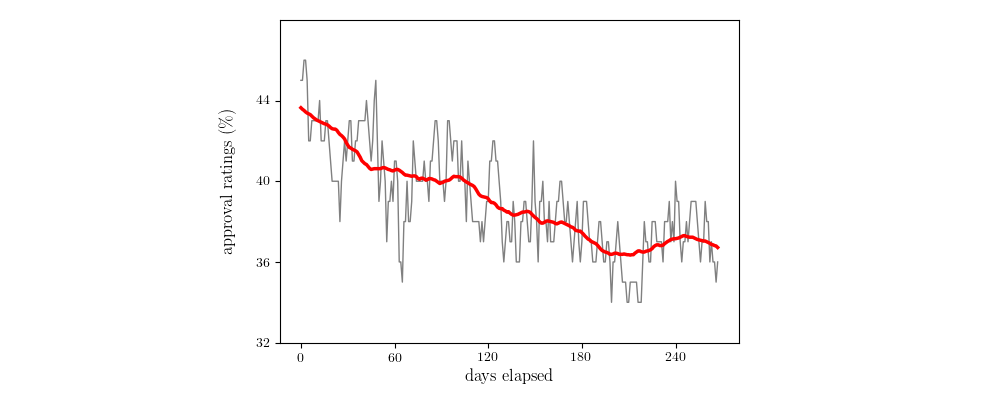
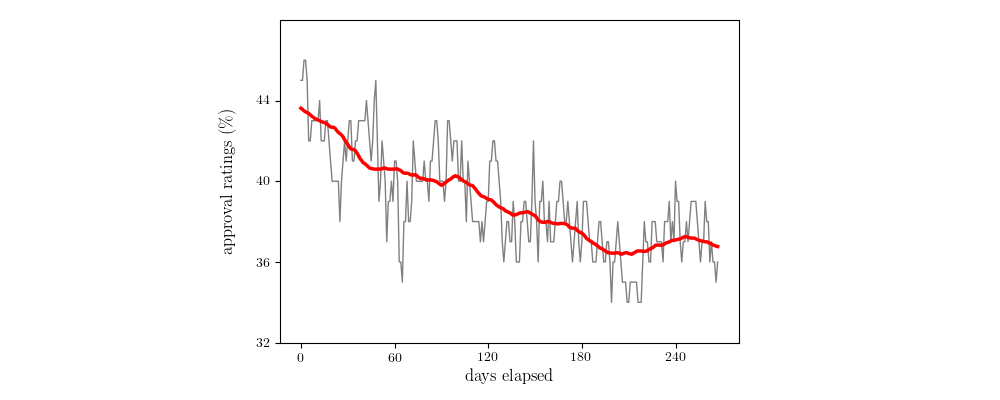
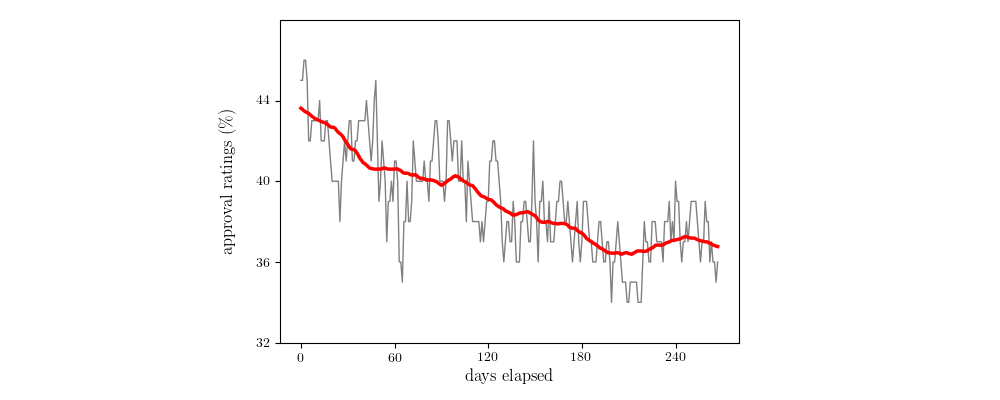
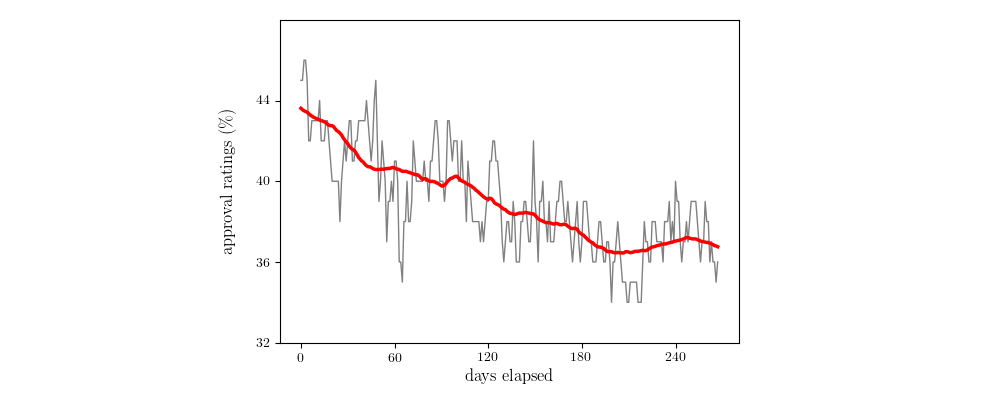
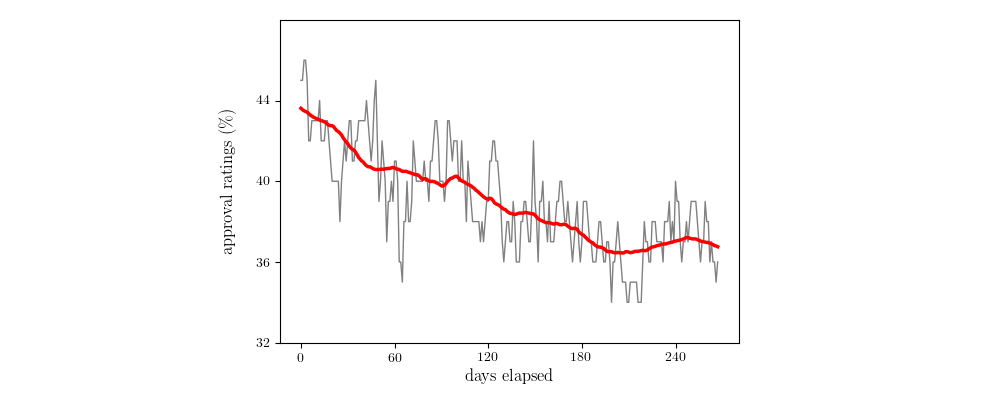
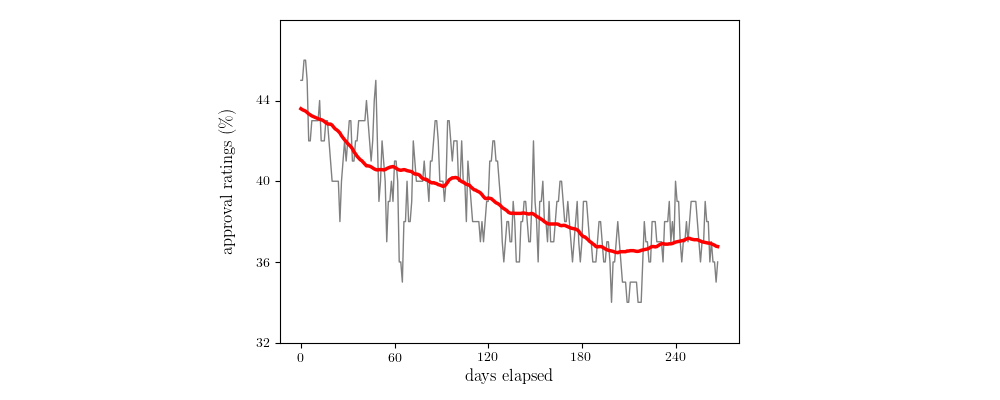
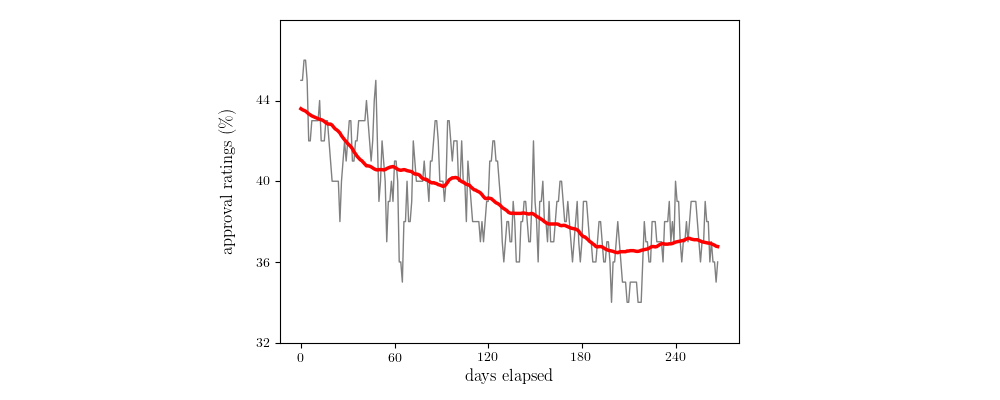
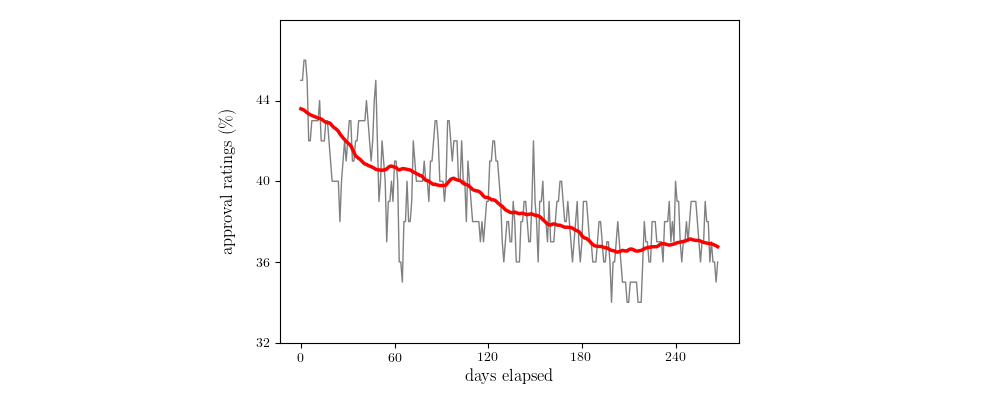
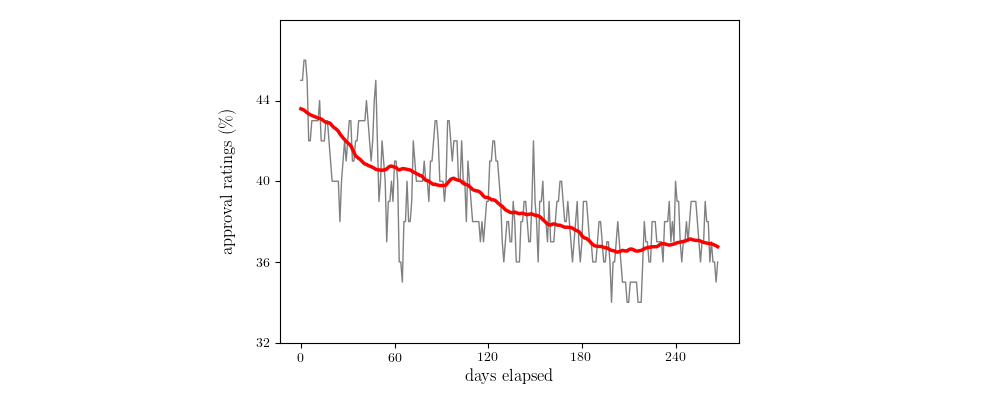
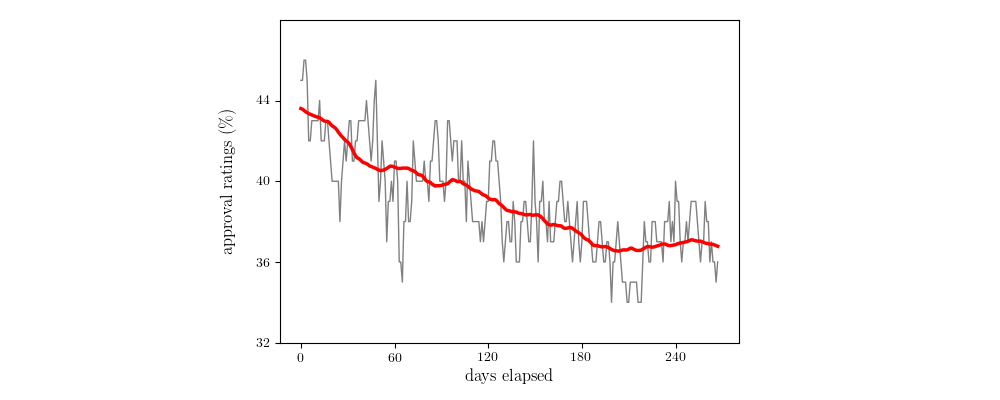
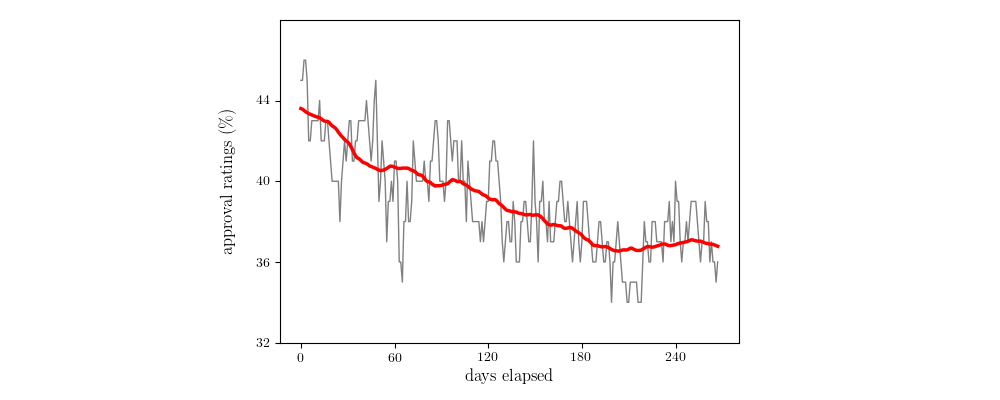
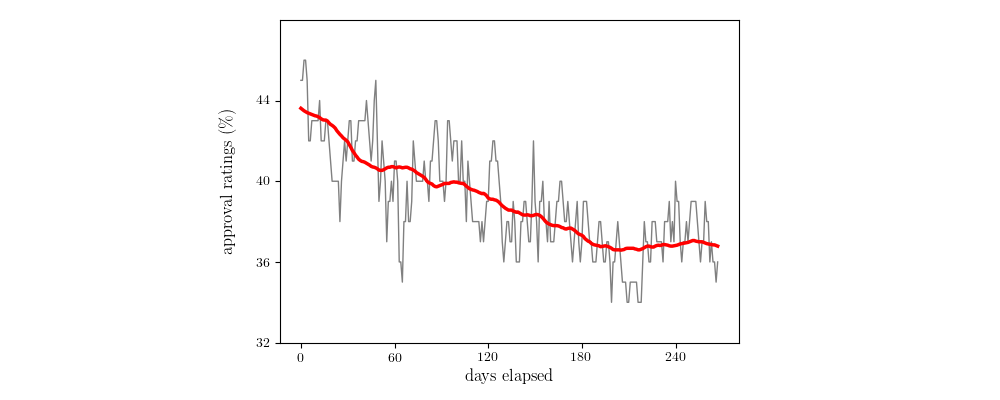
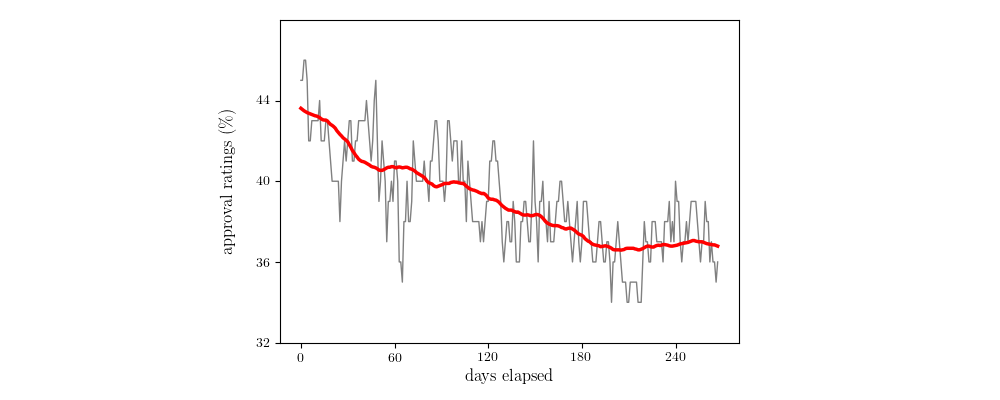
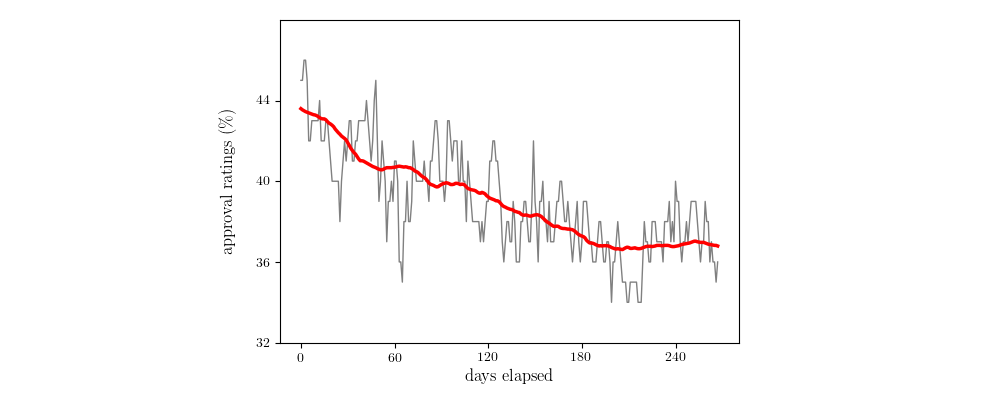
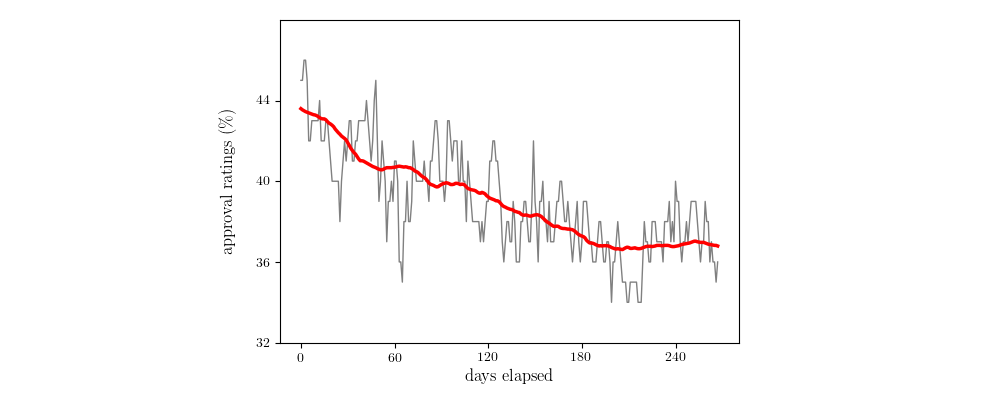
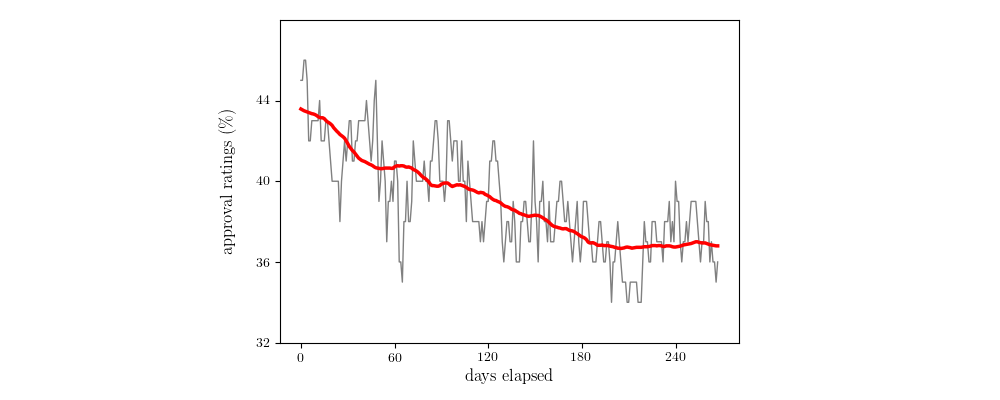
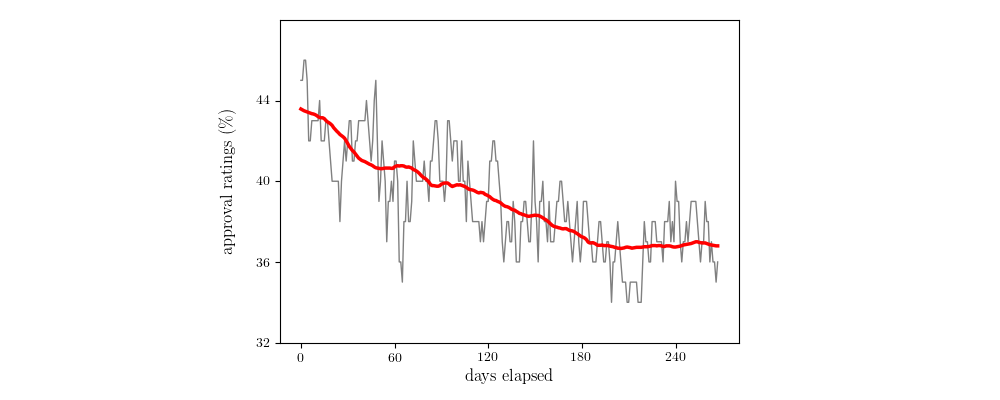
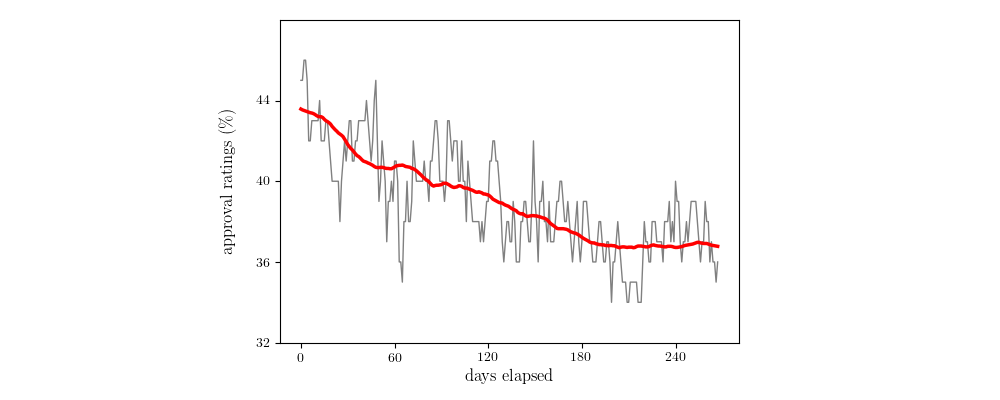
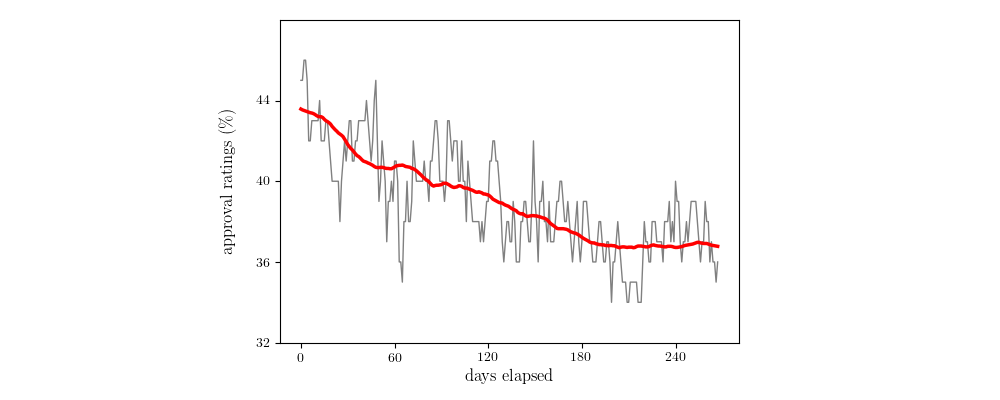
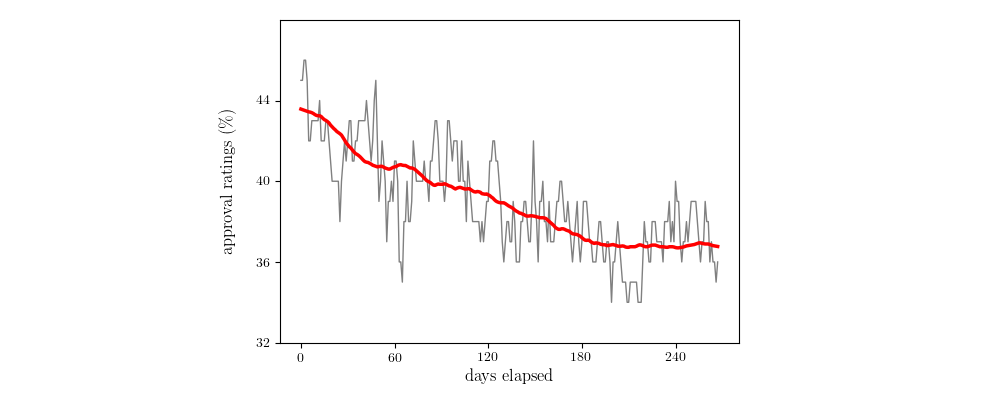
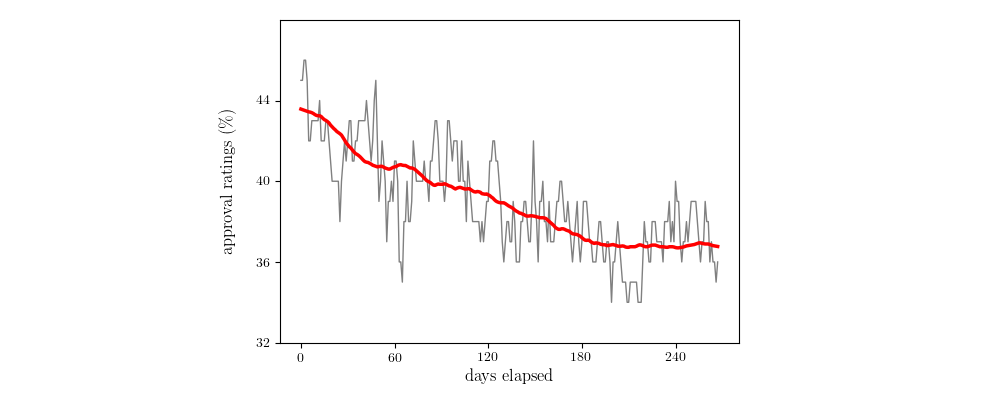
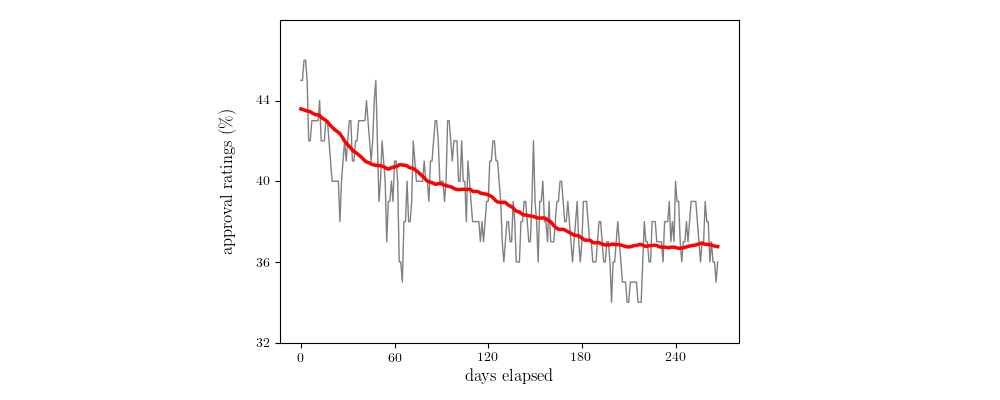
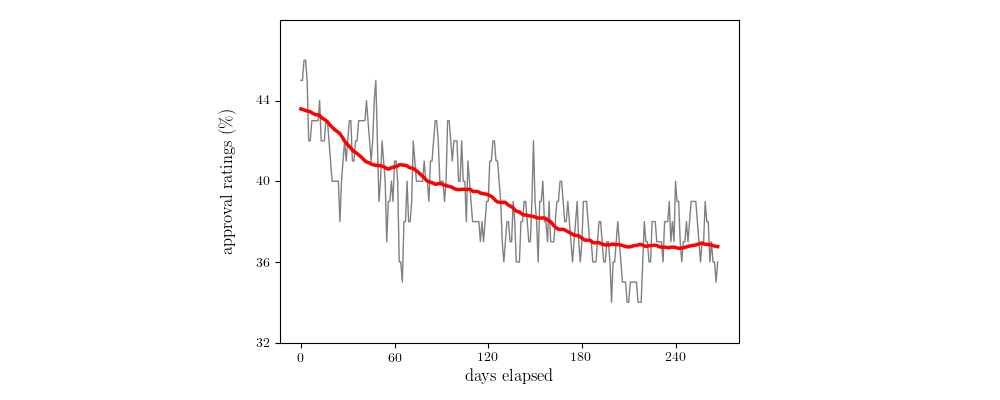
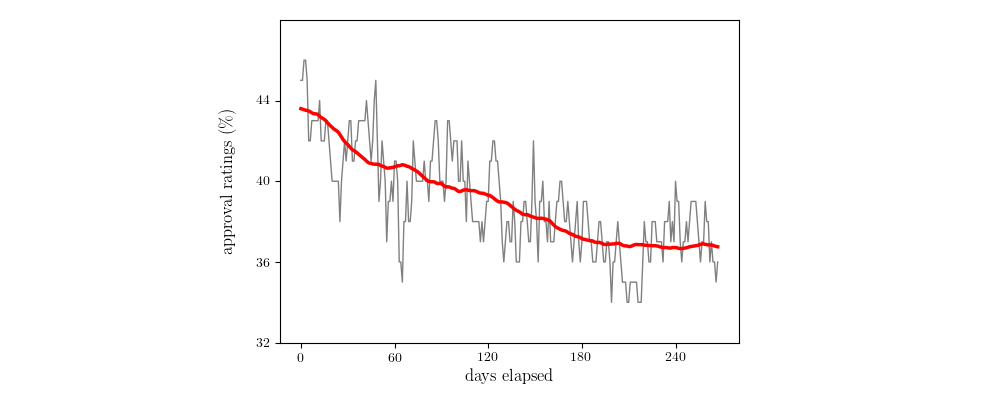
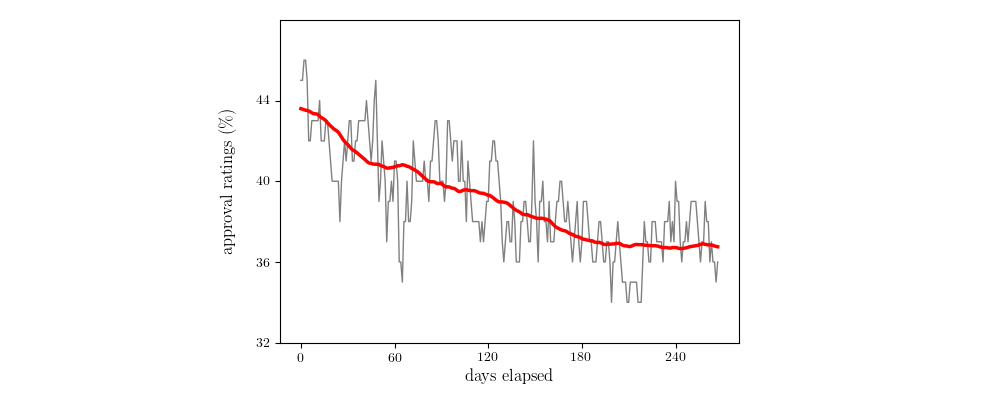
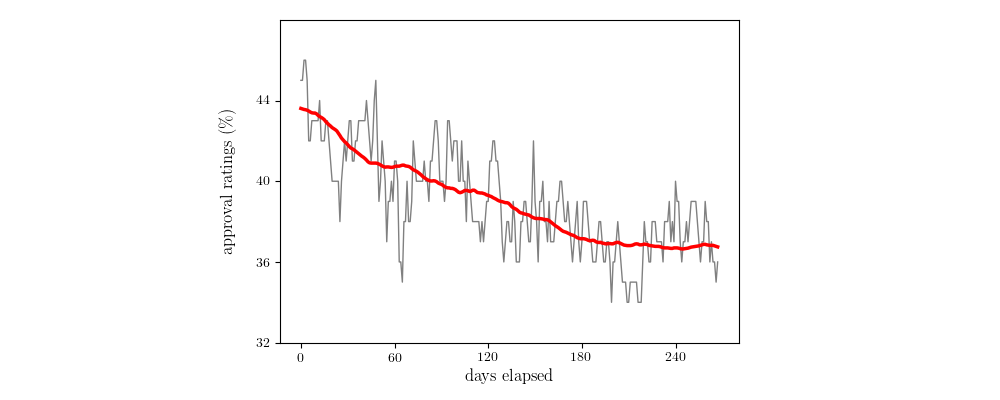
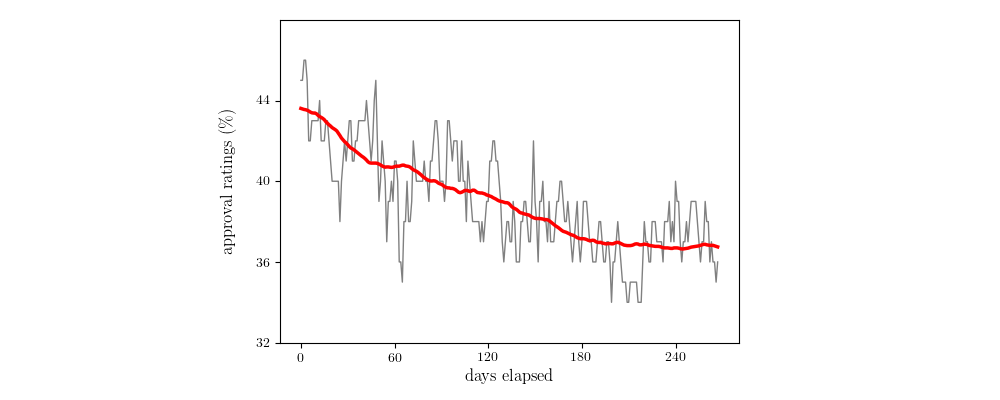
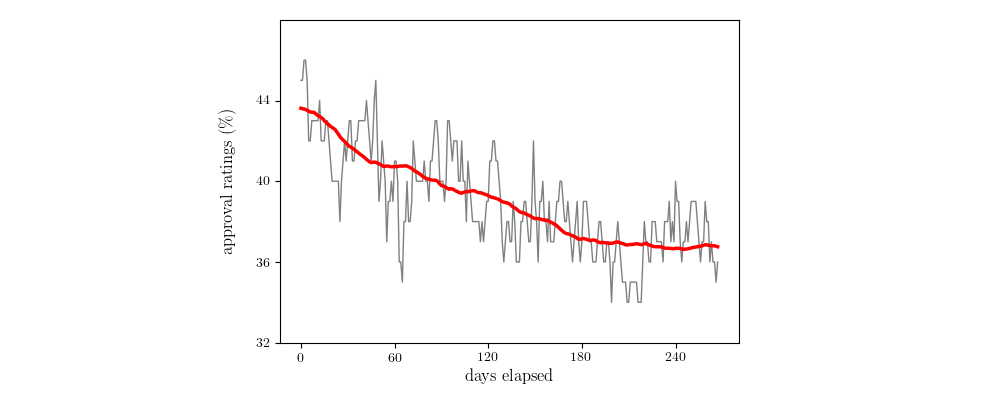
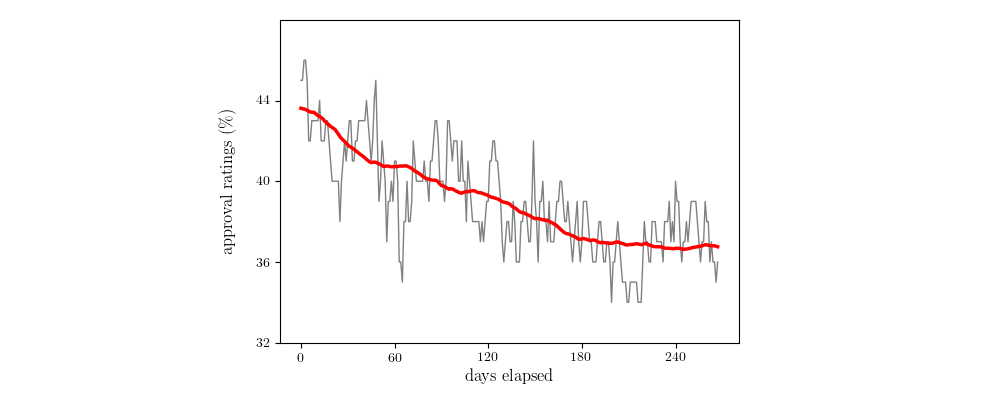
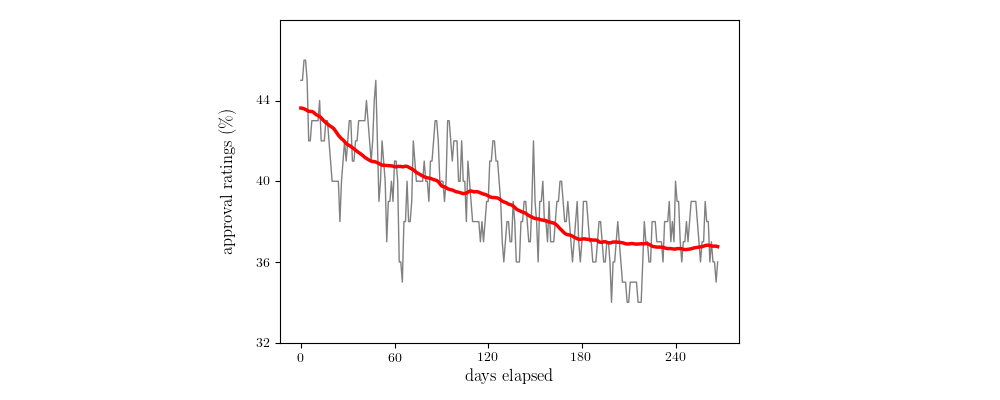
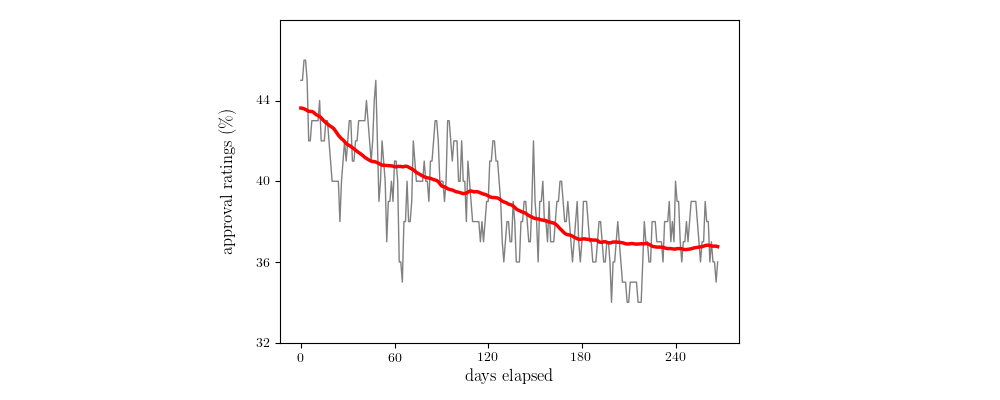
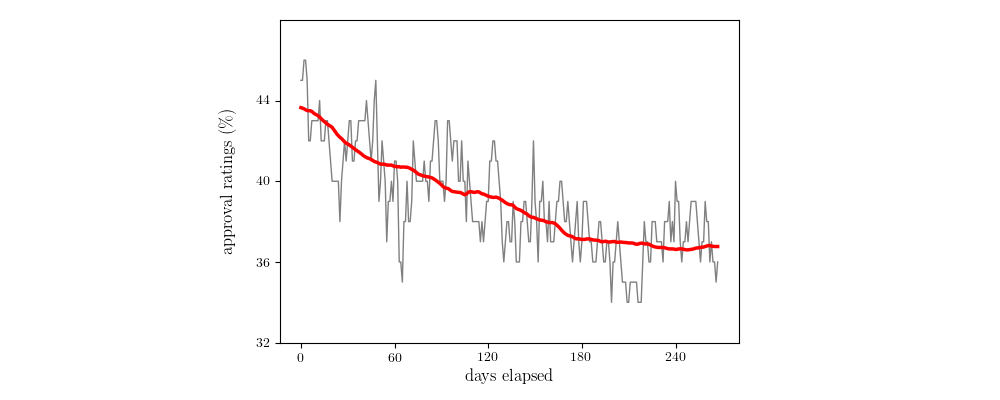
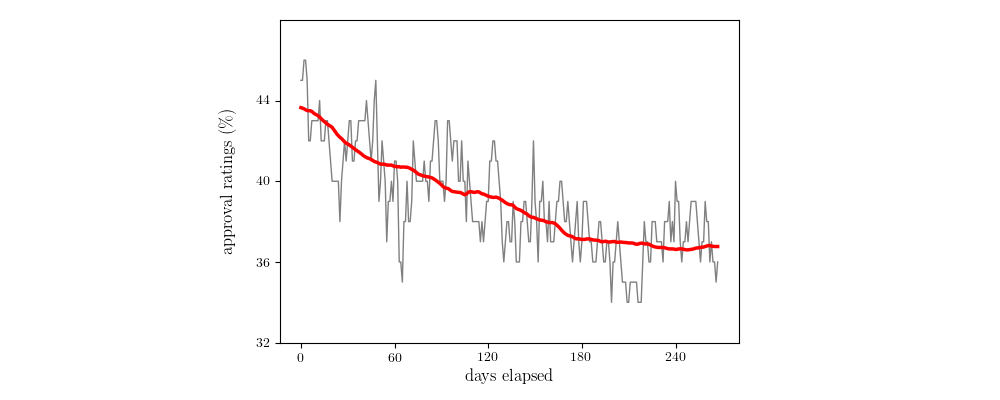
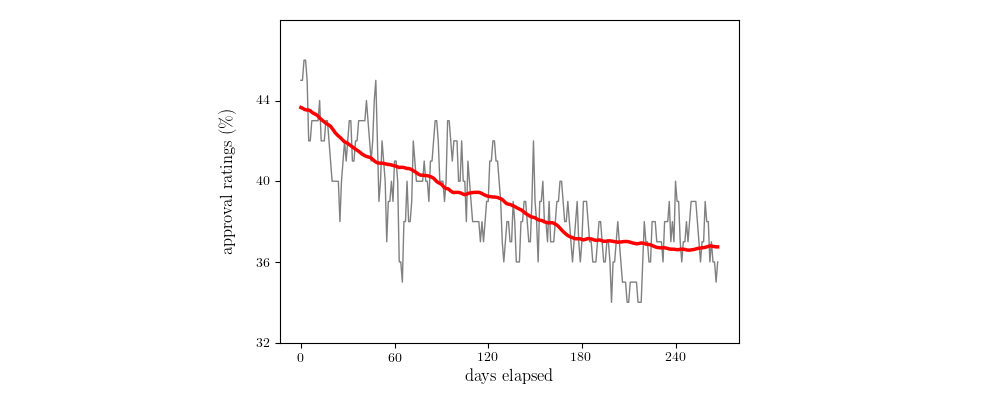
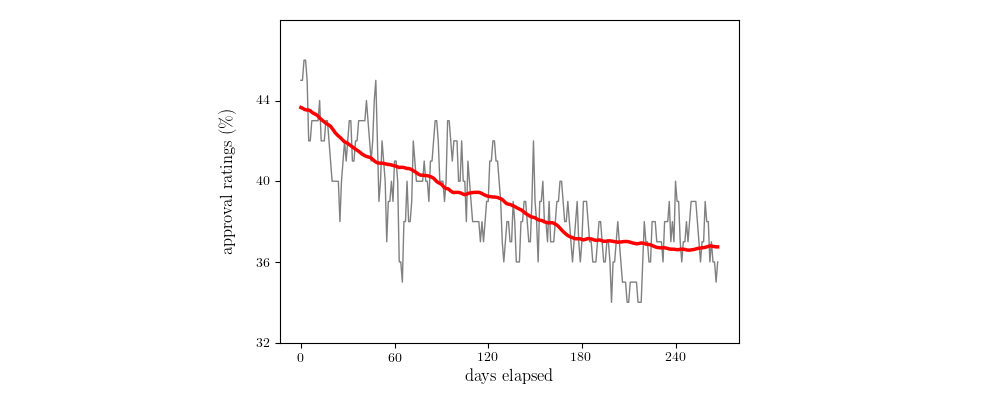
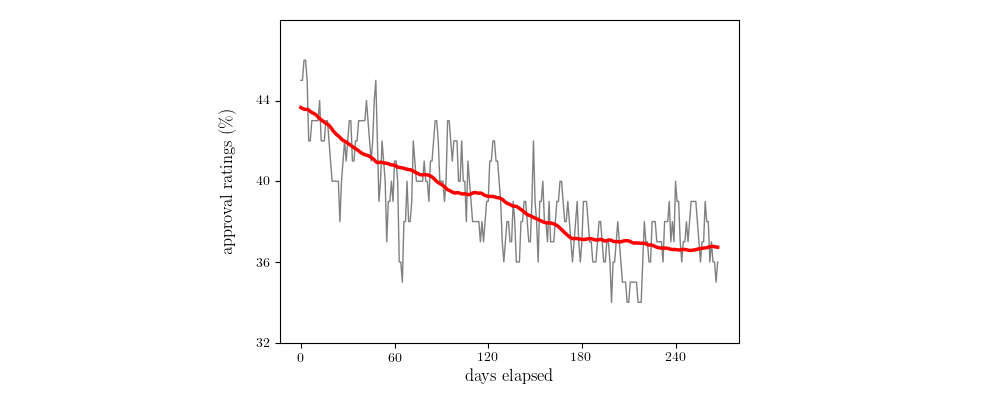
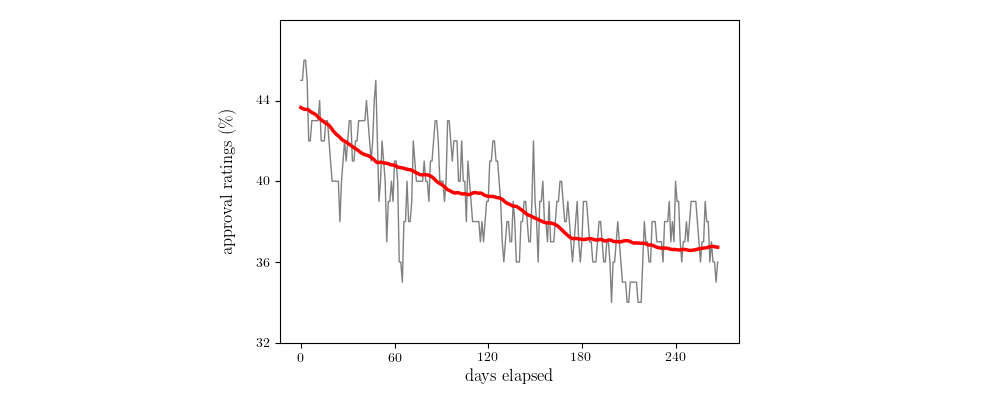
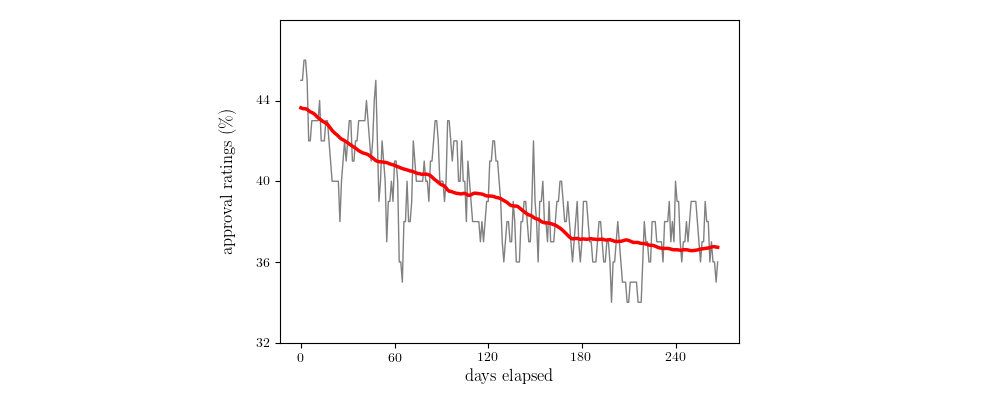
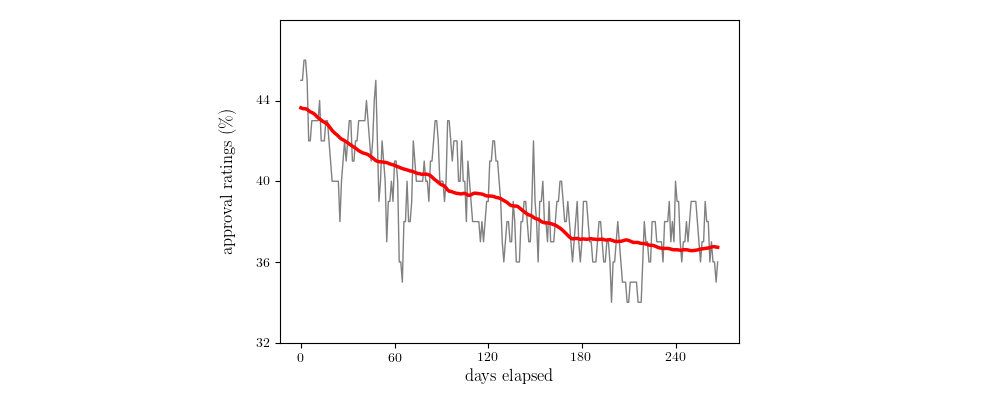
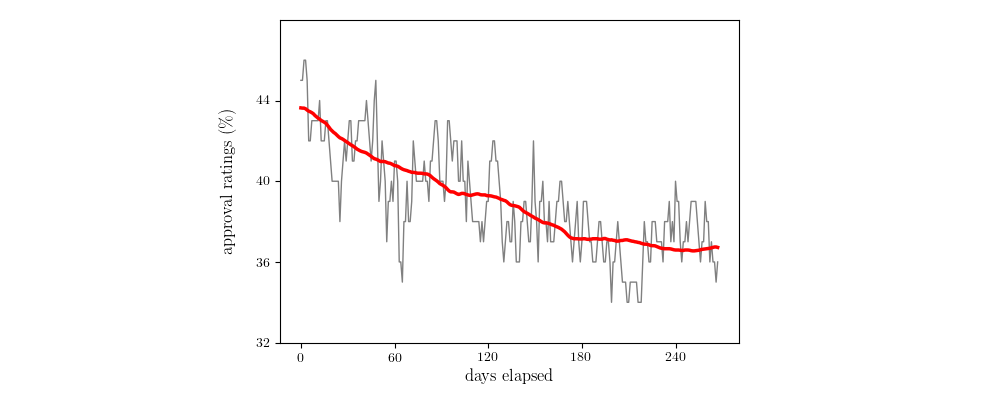
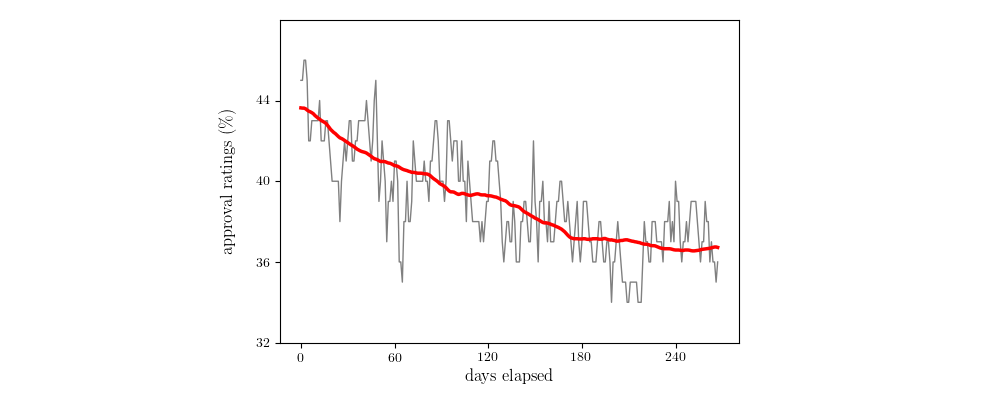
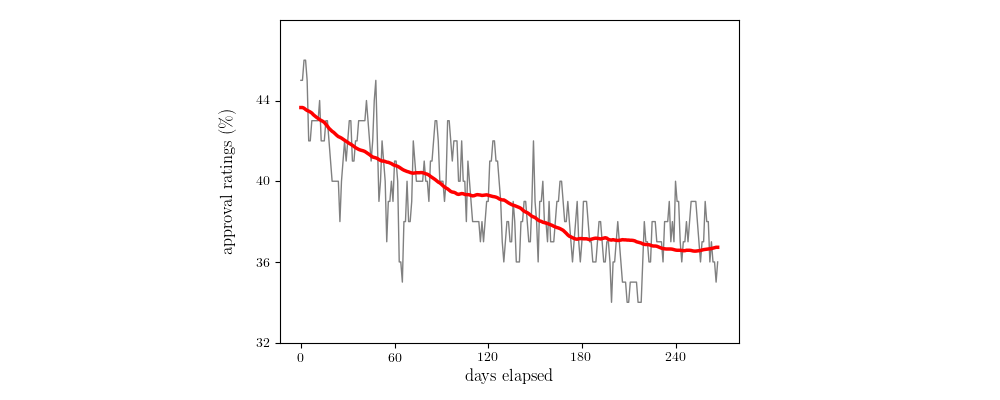
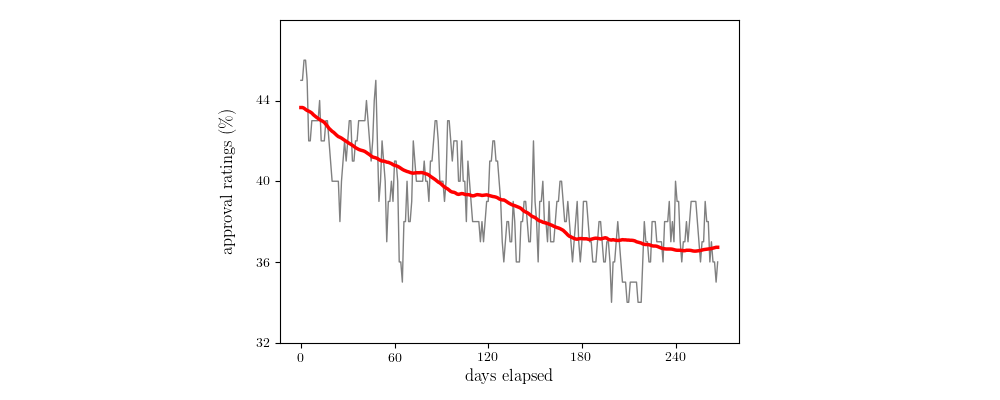
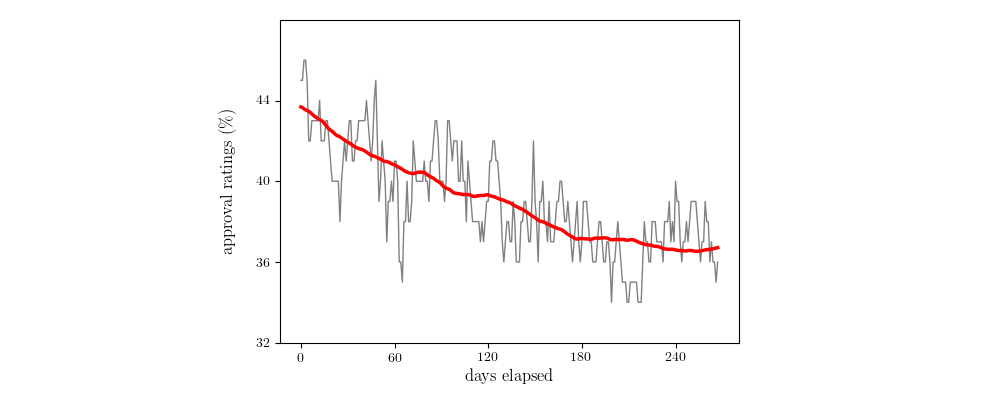
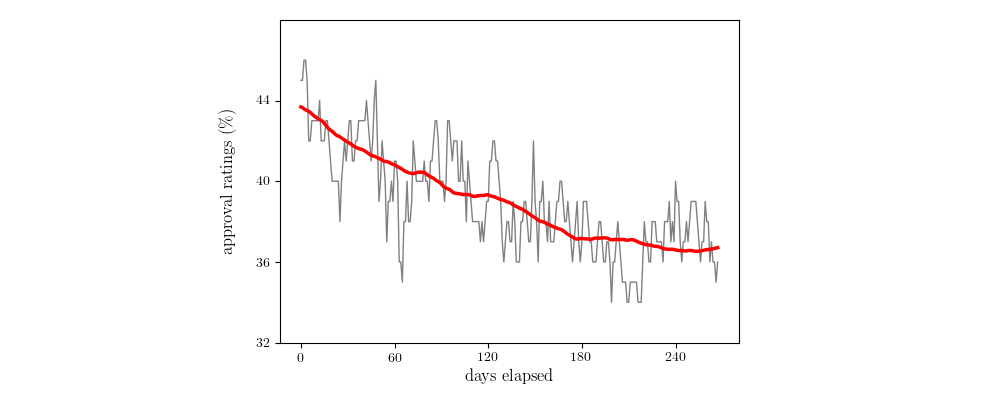
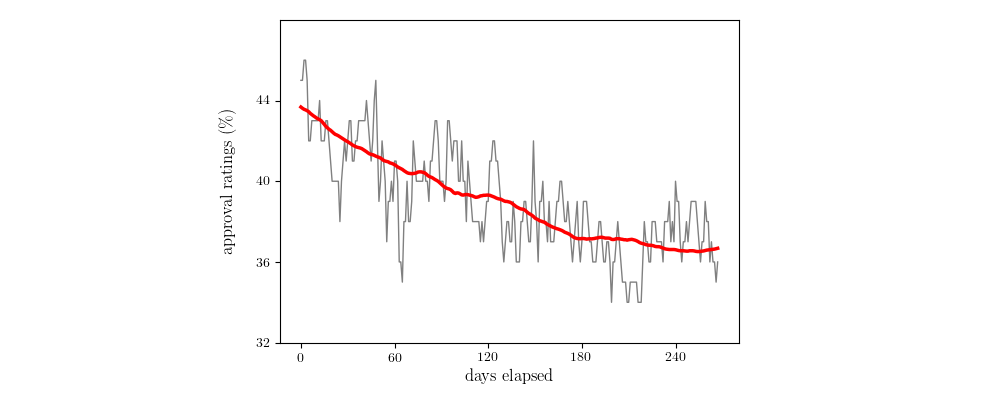
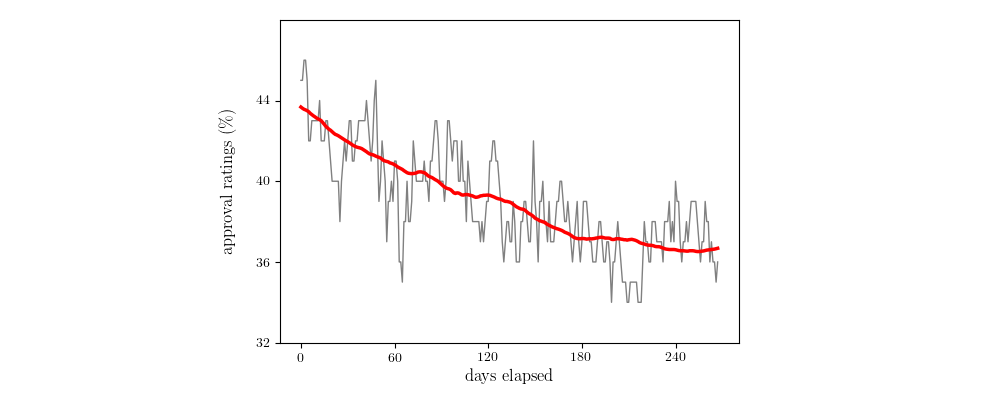

In [49]:
# create an instance of the visualizer
conv_viz = convlib.conv_1d_viz.visualizer(path = data_path)

# run the visualizer for our chosen input sequence
conv_viz.draw_it(num_frames=100)

<hr>

Notice, the larger the $L$ gets the more reliable the approximation in (5) becomes since having more samples drives the average of statistical observations closer to their true population mean (here, zero). However as we increase $L$ the approximation in (6) deteriorates as $s_n$ gets drowned out by its neighboring values. We can ameliorate this issue by adjusting the way we take the average in equation (7). Instead of a uniform average, we can take a *weighted* average of elements in a vicinity of $x_n$ where larger weights are given to the elements closer to $x_n$ and smaller weights to those farther from it.

Denoting by $w_\ell$, the weight given to $x_{n+\ell}$ in (11), we can write it more generally as

\begin{equation}
s_n \approx \underset{\ell=-L}{\overset{L}{\sum}}{w_{\ell}\,x_{n+\ell}}
\end{equation}

which reduces to (11) when the weight sequence is chosen uniformly as 

\begin{equation}
w_\ell = \frac{1}{2L+1}, \qquad \ell=-L,\ldots,+L
\end{equation}

In Figure 2 we illustrate the uniform weight sequence in (9) in yellow, along with a non-uniform sequence in blue, defined entry wise as 

\begin{equation}
w_\ell = \frac{L+1-\left|\ell\right|}{\left(L+1\right)^2}, \qquad \ell=-L,\ldots,+L
\end{equation}
  
The non-uniform weight sequence takes its maximum value when $\ell=0$ (this is the weight assigned to $x_n$) and tapers off gradually as we get farther from the center point  $x_n$. Notice too, that the elements of the weight sequence in (10) do add up to $1$, just like the uniform sequence in (9). 

<figure>
<img src="../../mlrefined_images/convnet_images/uniform_vs_nonuniform.png" width="100%" height="auto"/>
<figcaption> <strong>Figure 2:</strong> <em> Two weight sequences with $L=3$. The uniform (in yellow) and non-uniform (in blue) weight sequences are defined in equations (9) and (10) respectively.</em>
</figcaption>
</figure>

#### <span style="color:#a50e3e;">Example 3. </span>  Recovering the signal from the daily presidential job approval data using non-uniform weights

In the Python cell below we plot the recovered signal $s$ from the data in Example 1 by repeating the experiment in Example 2, this time using non-uniform weight sequence given in equation (10).    


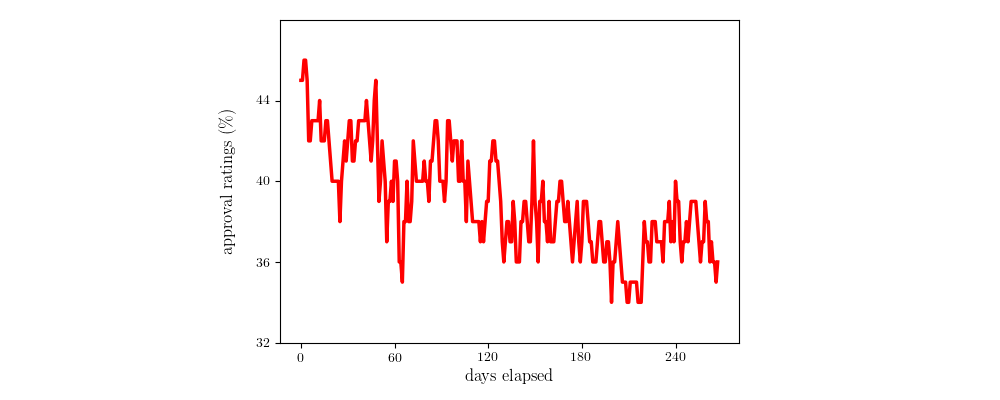
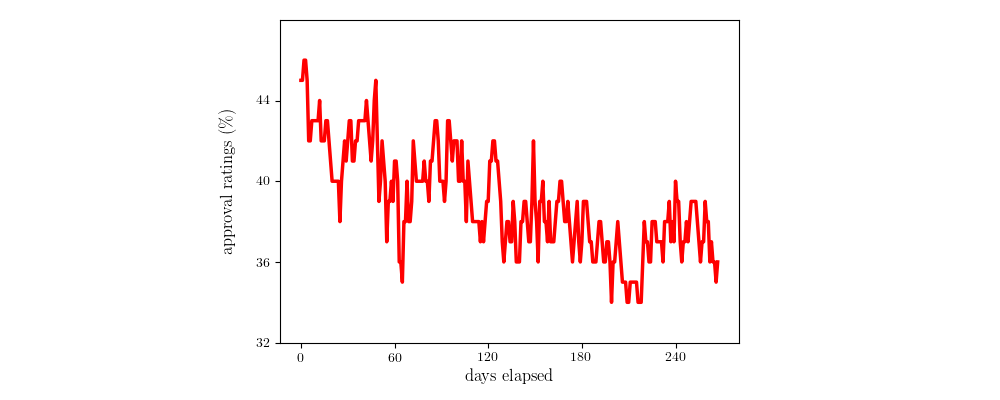
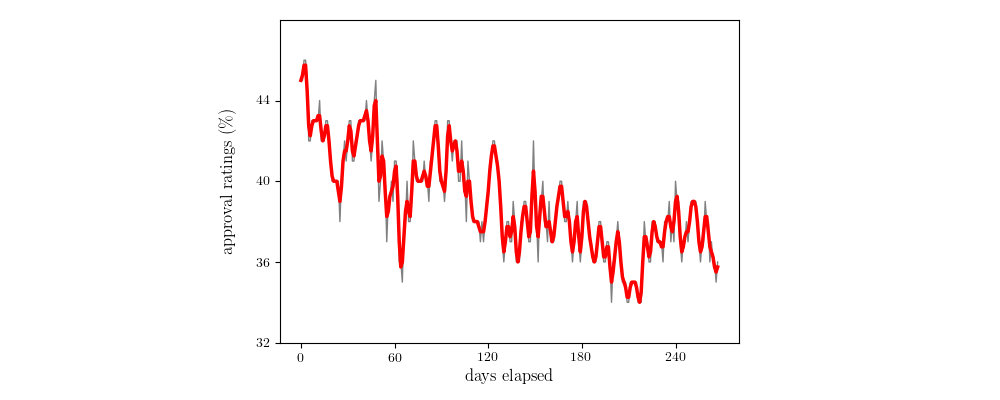
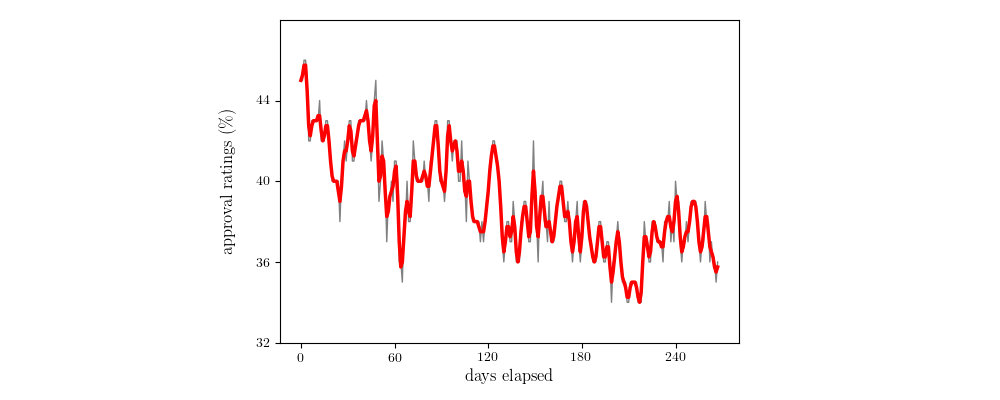
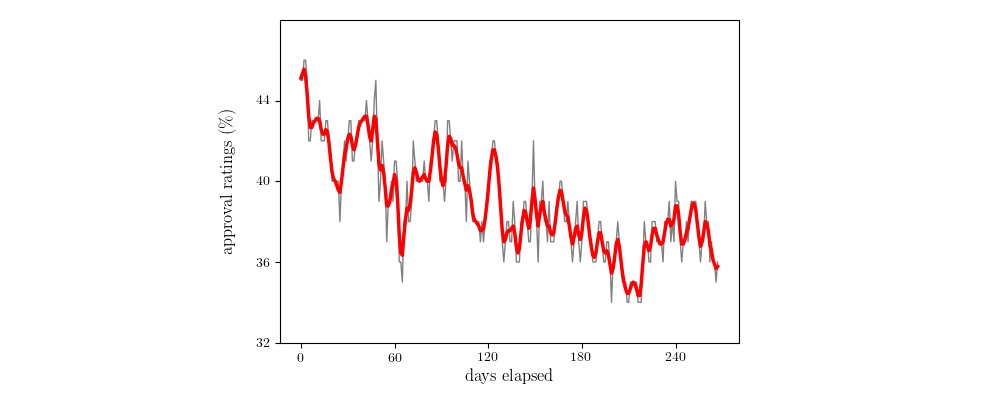
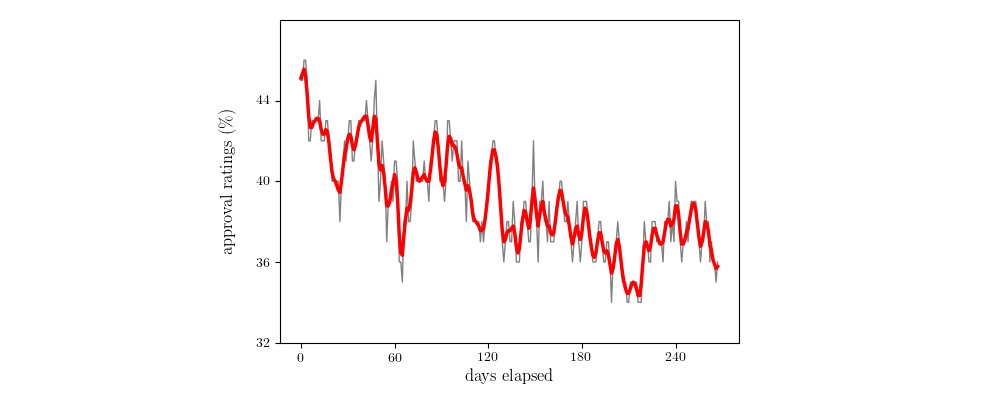
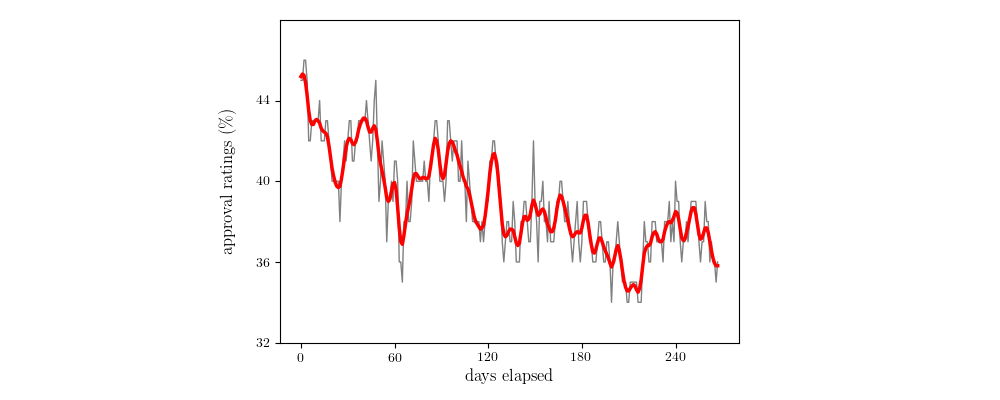
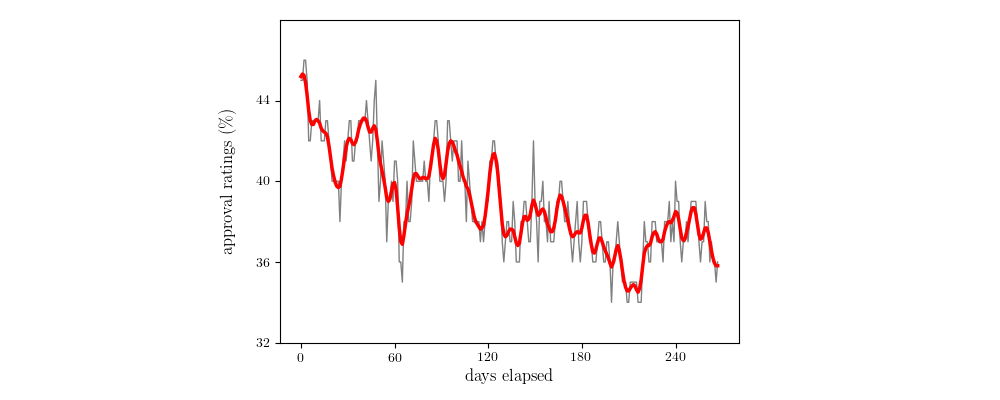
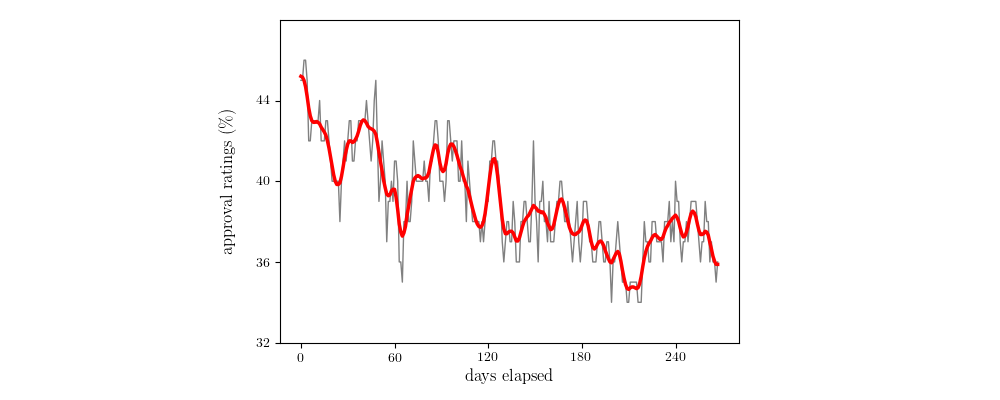
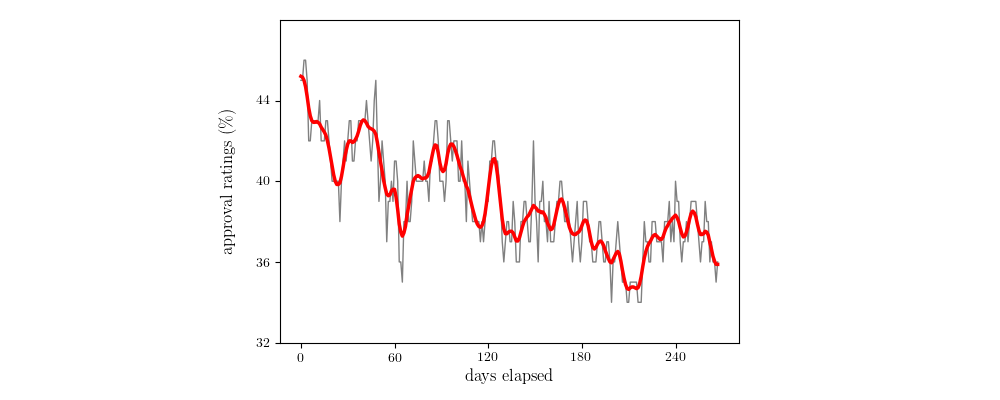
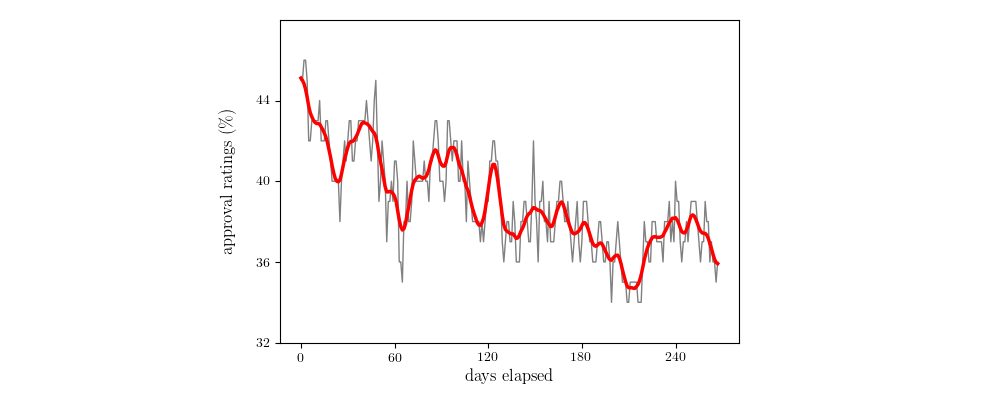
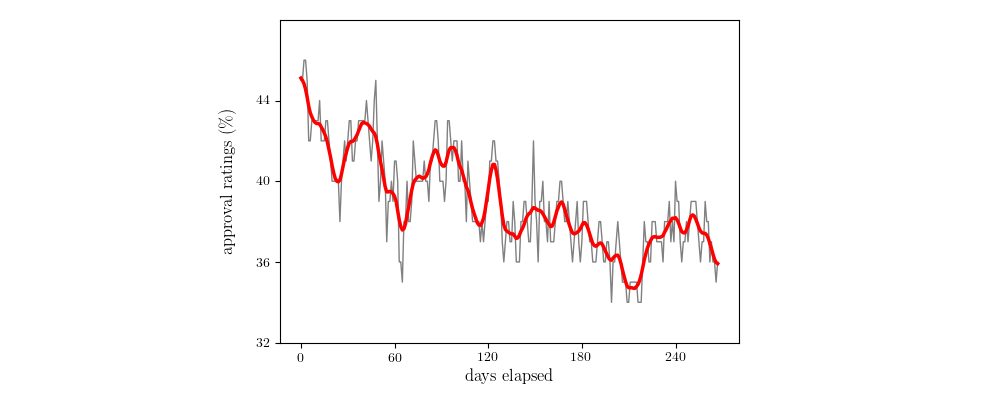
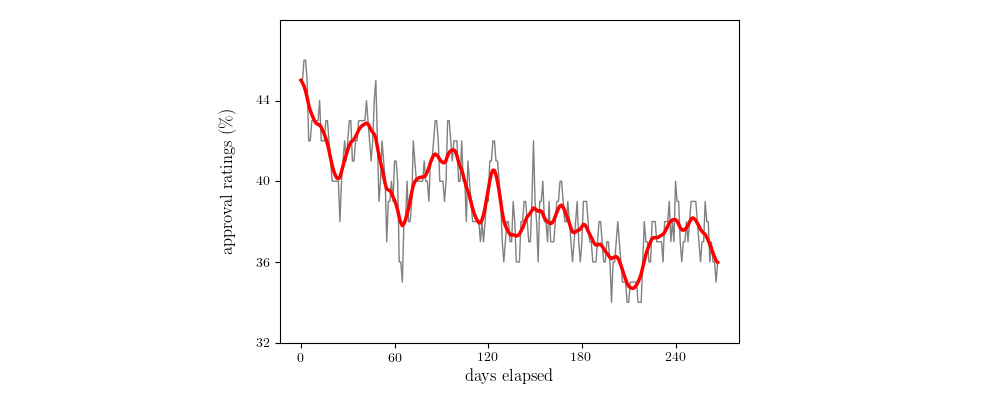
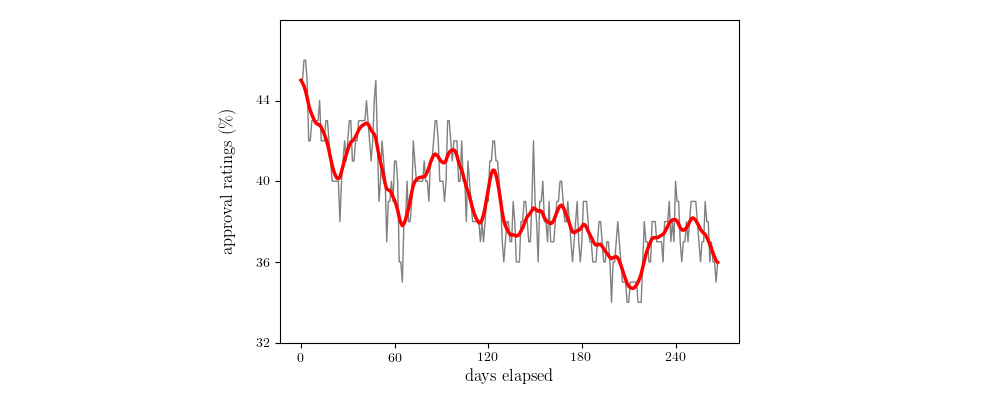
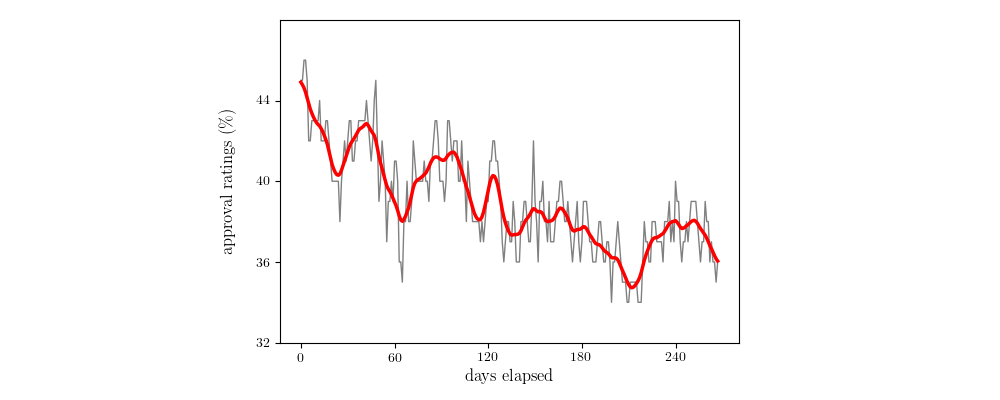
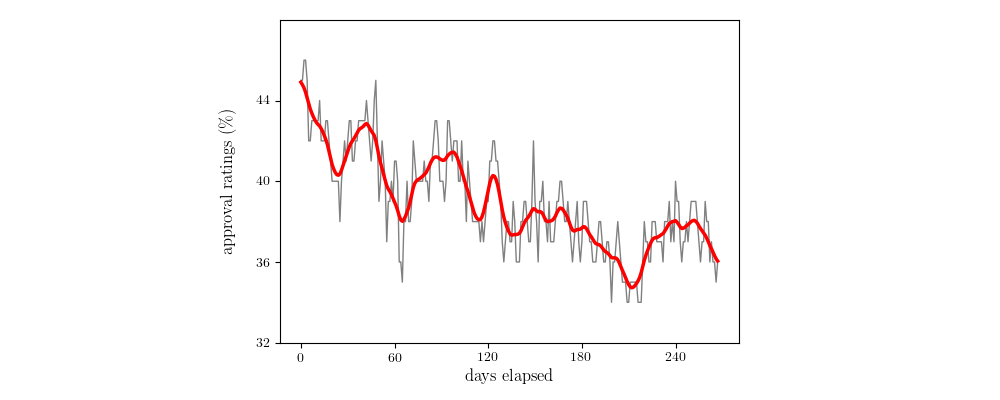
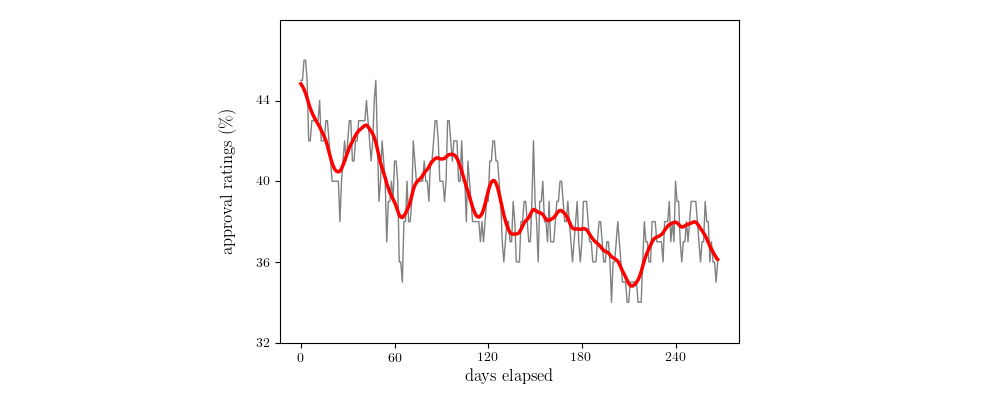
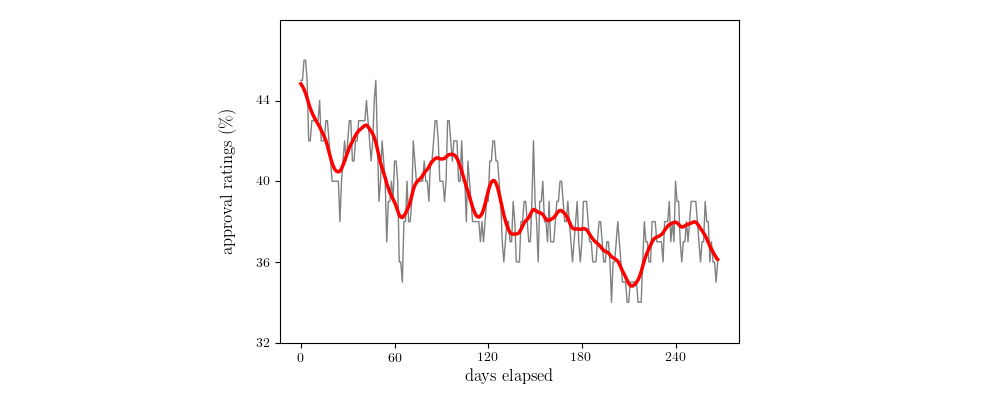
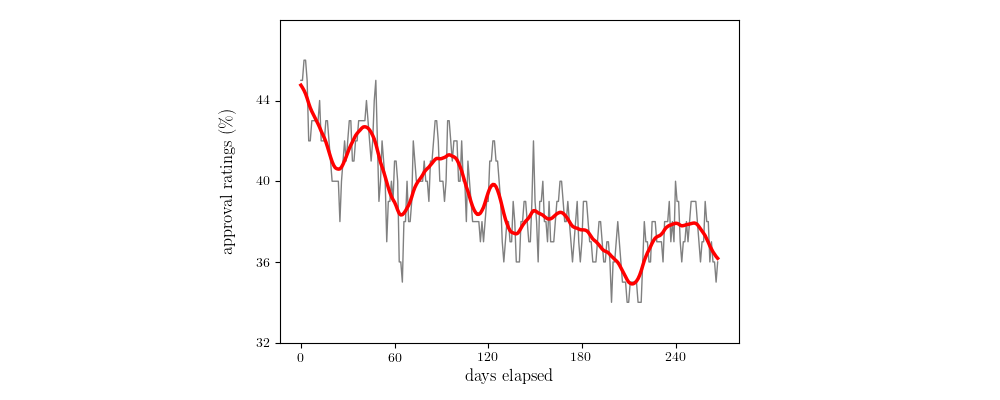
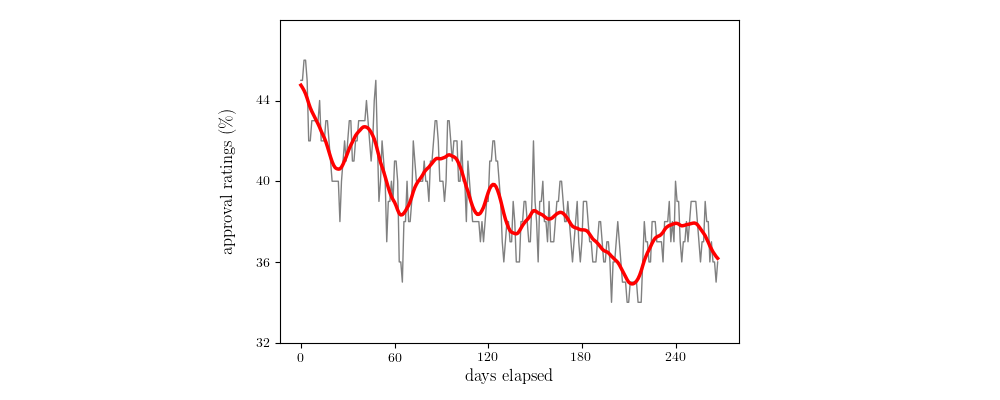
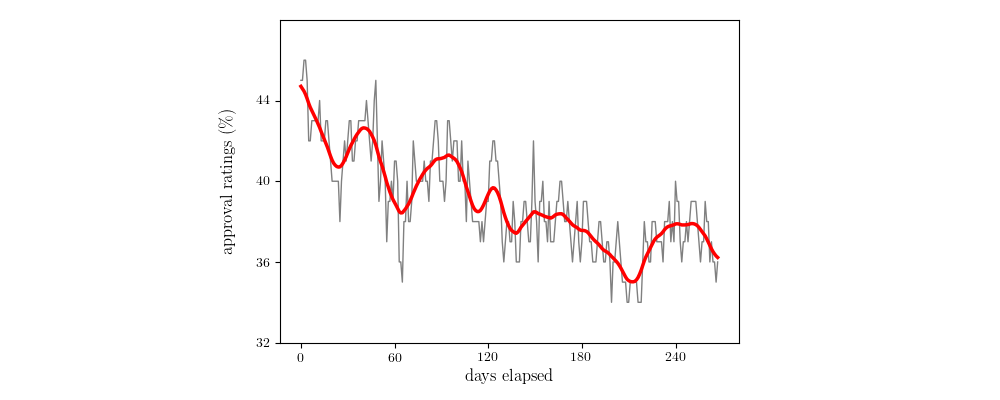
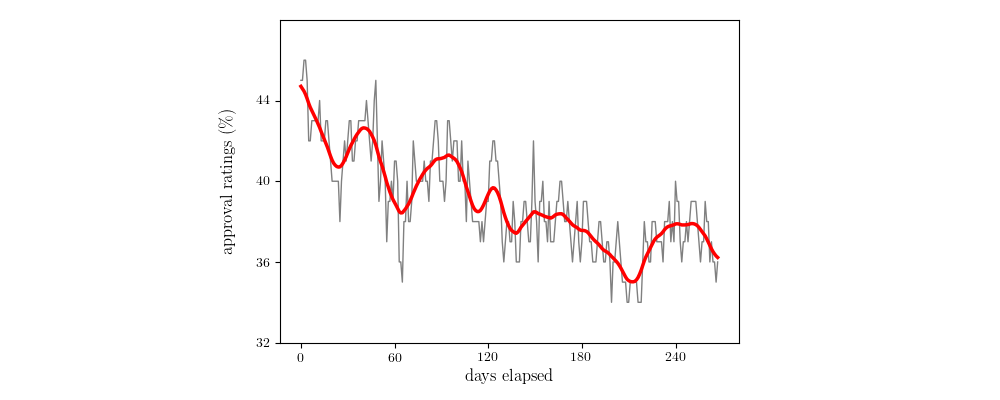
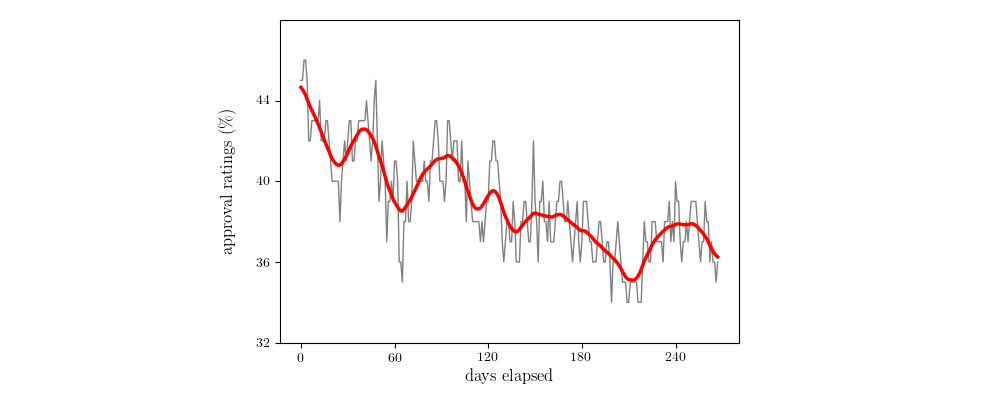
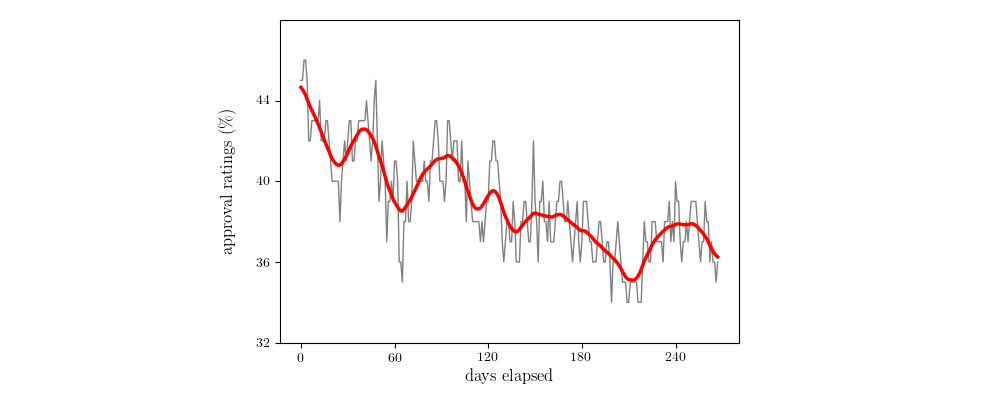
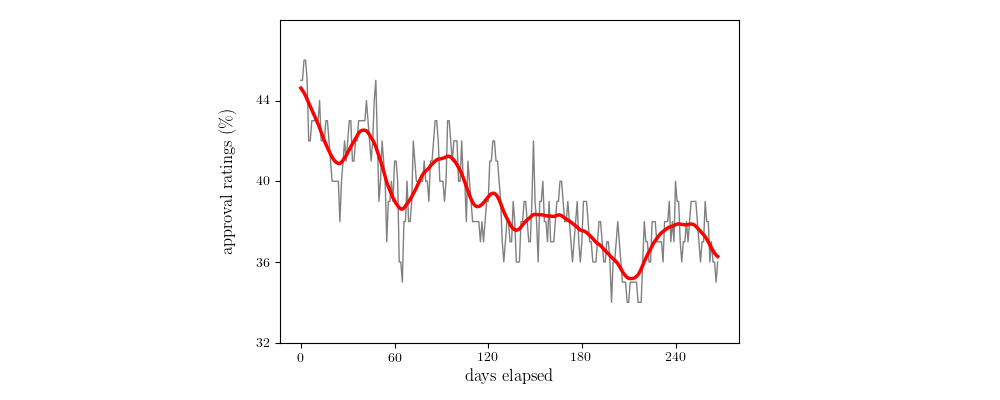
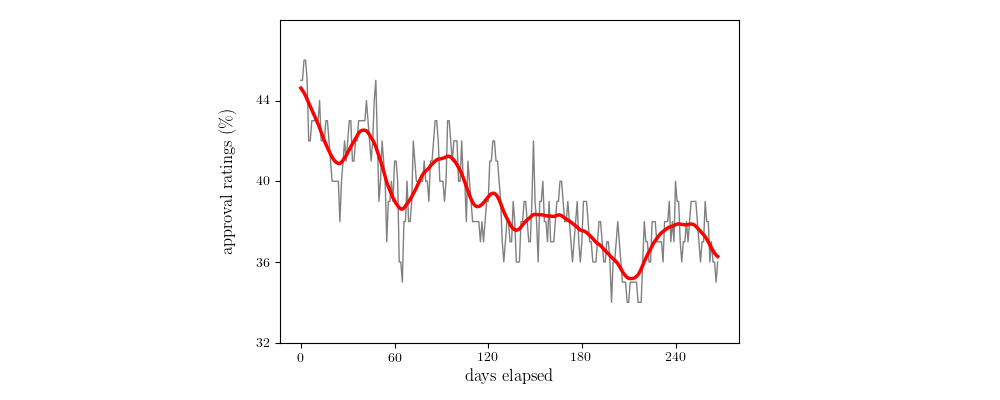
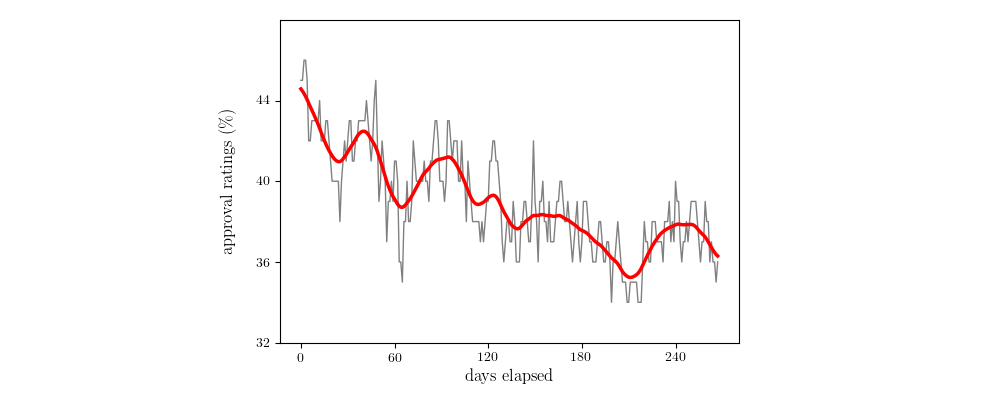
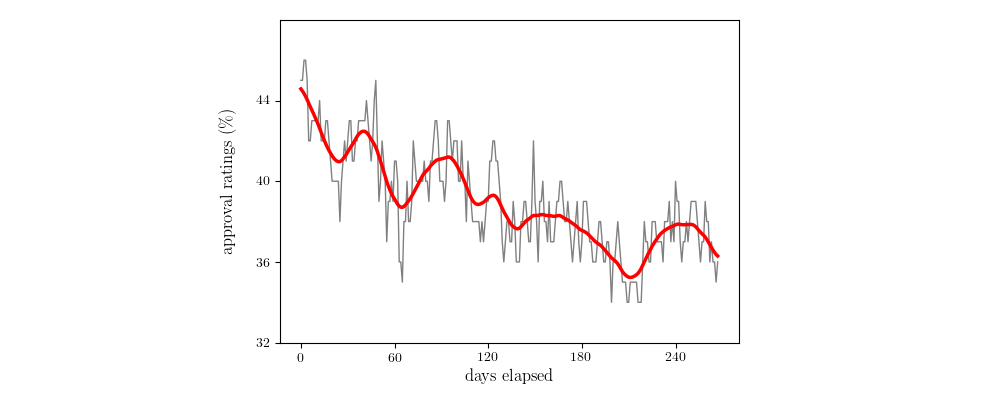
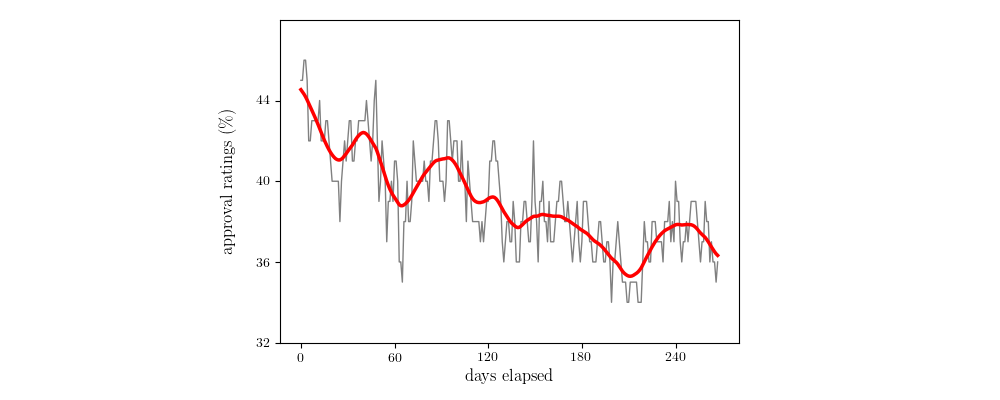
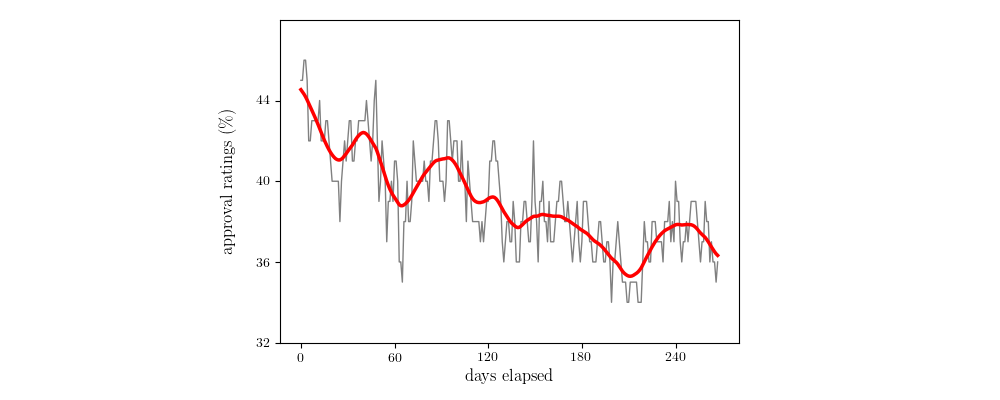
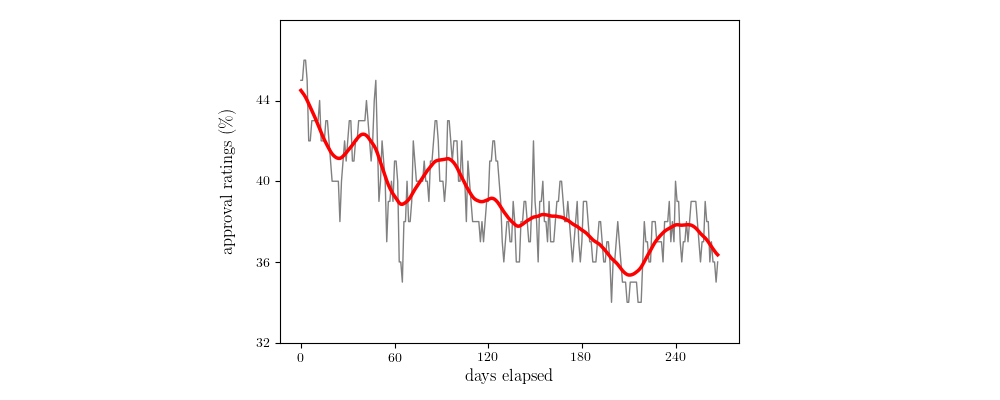
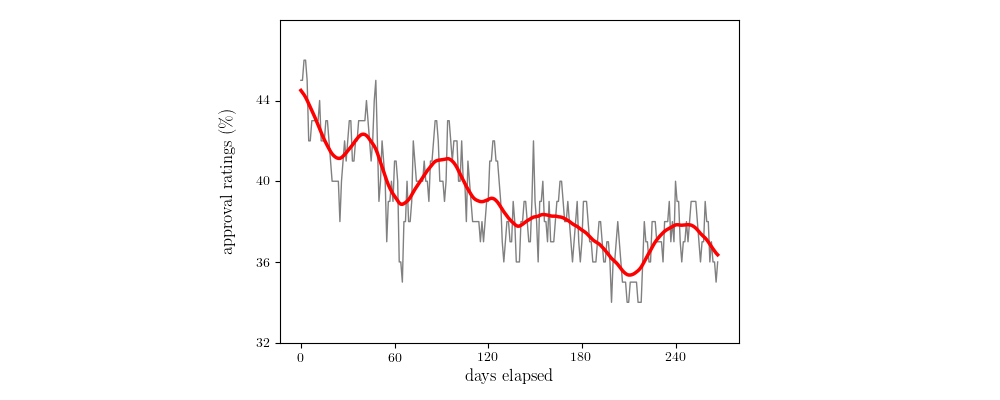
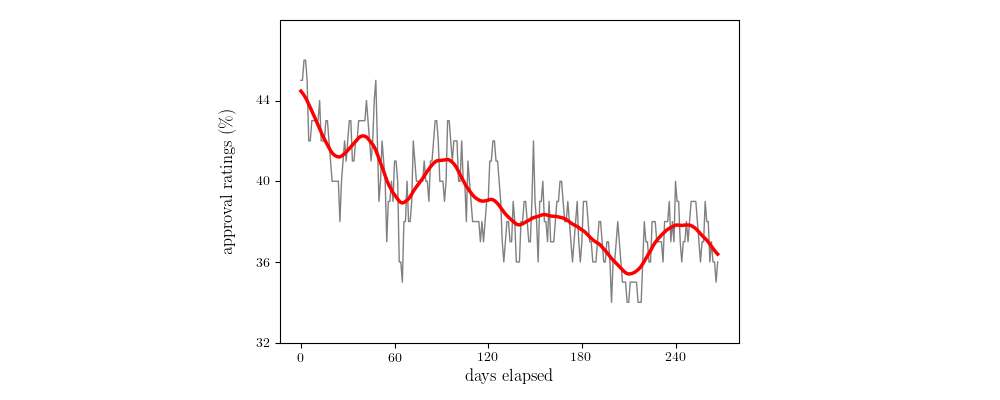
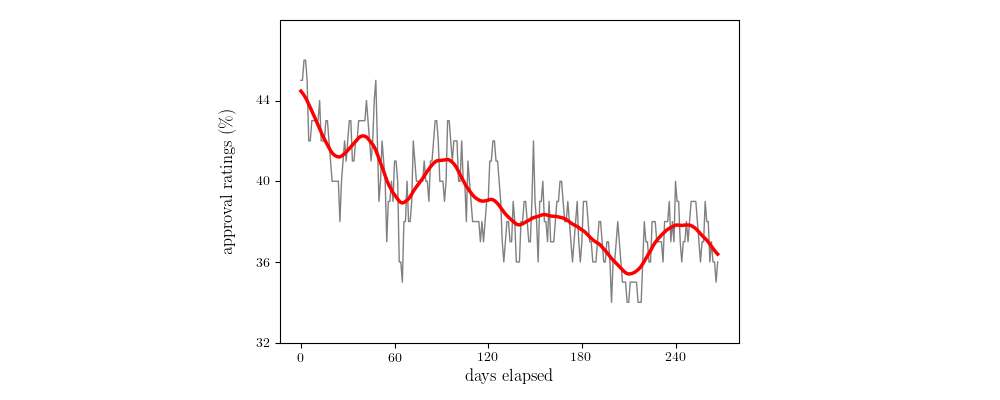
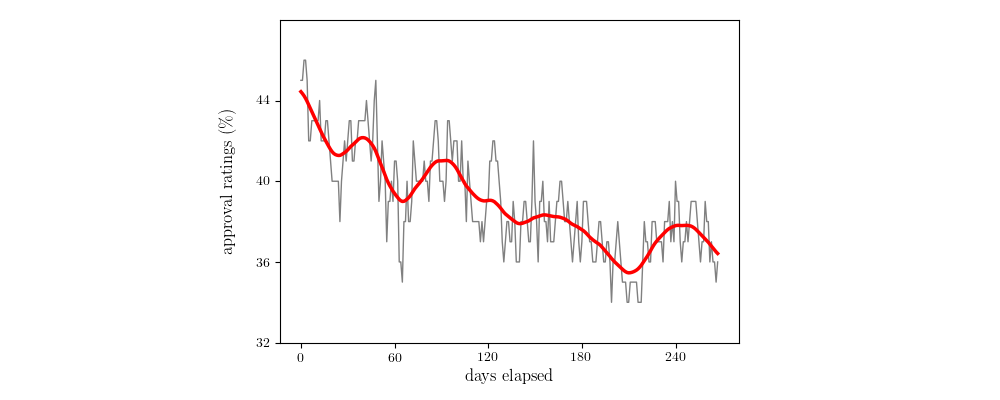
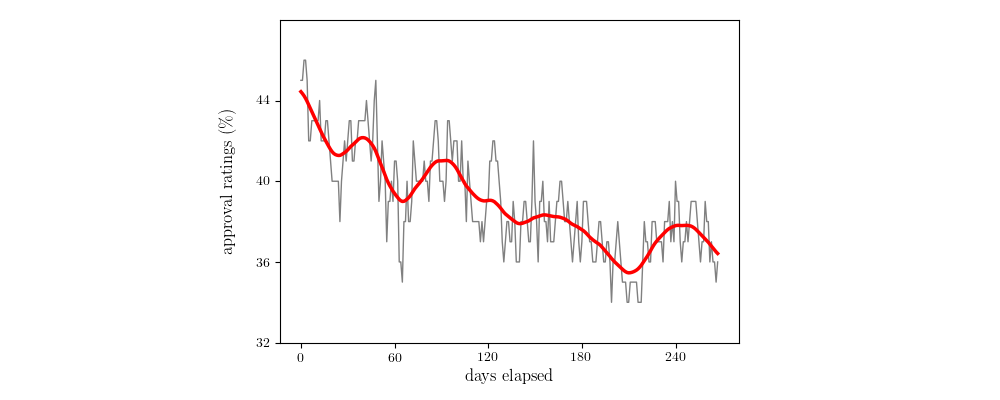
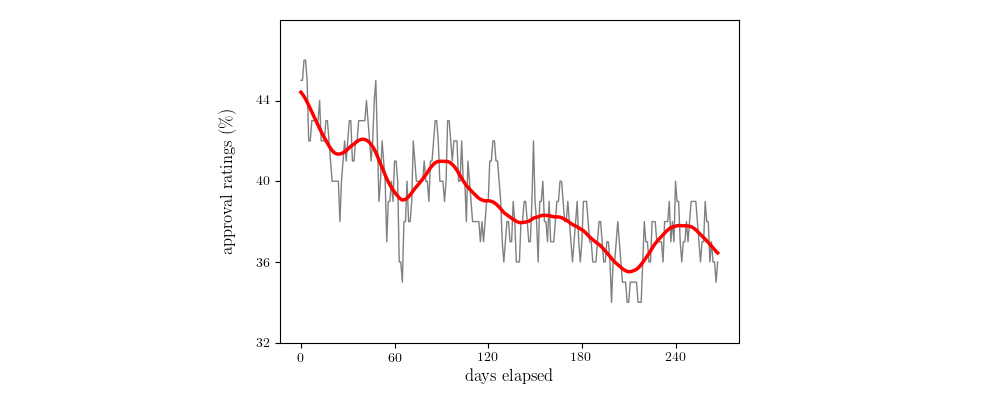
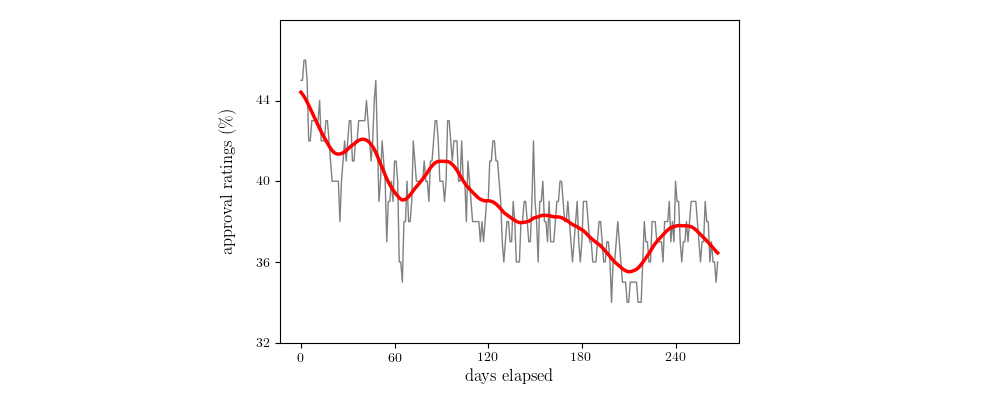
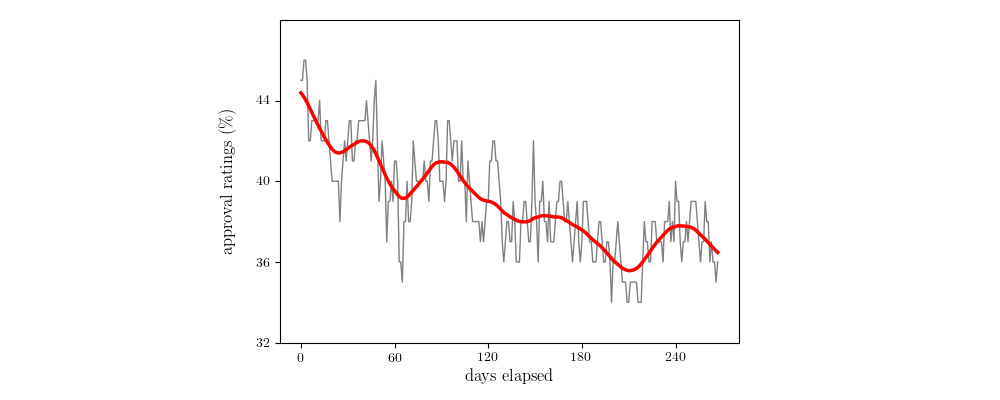
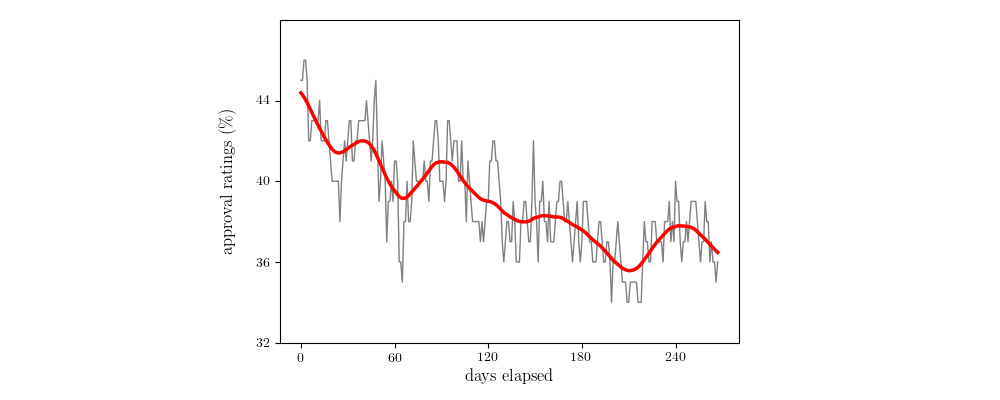
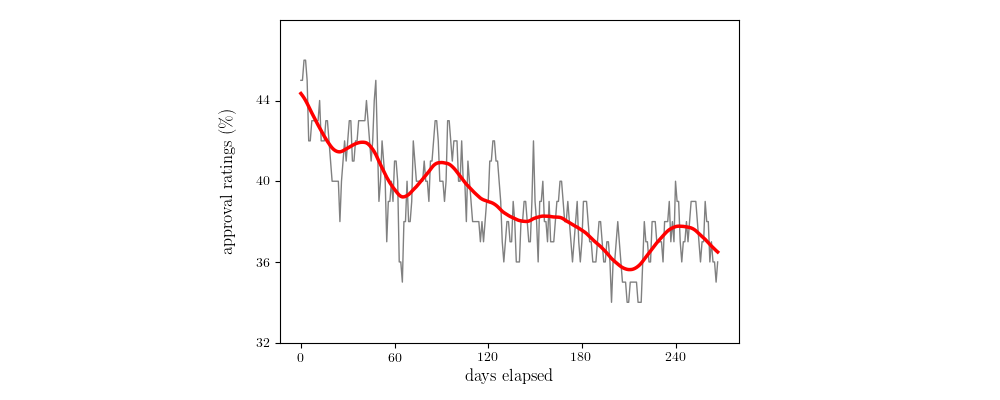
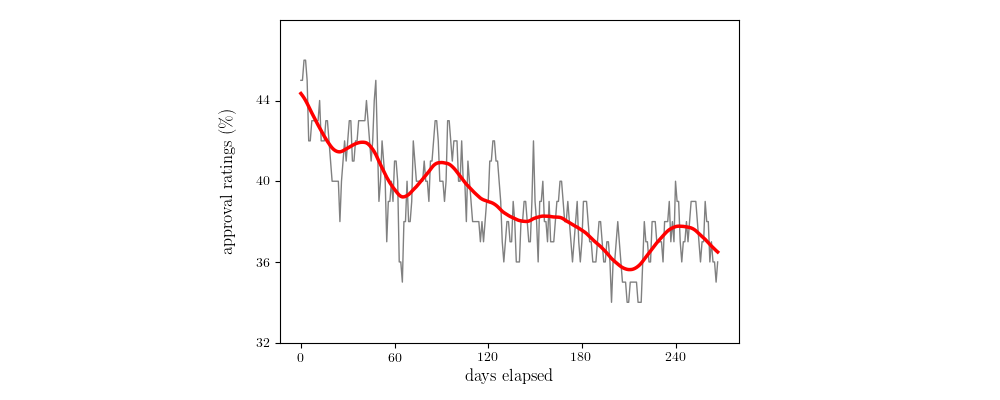
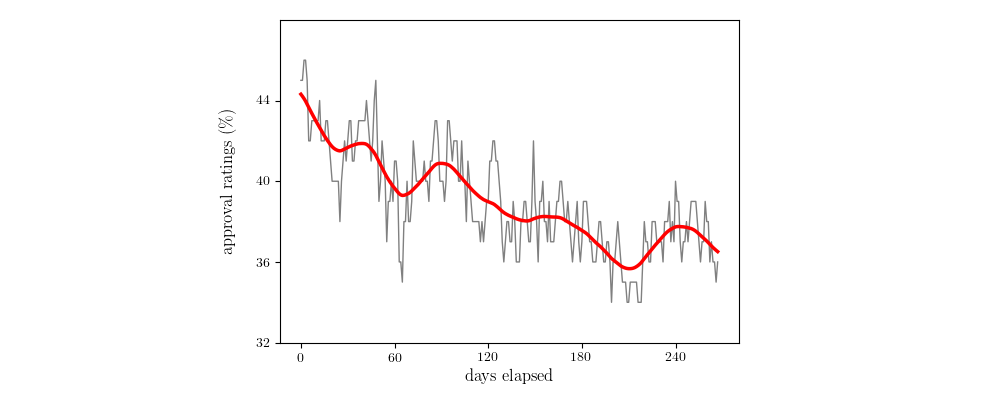
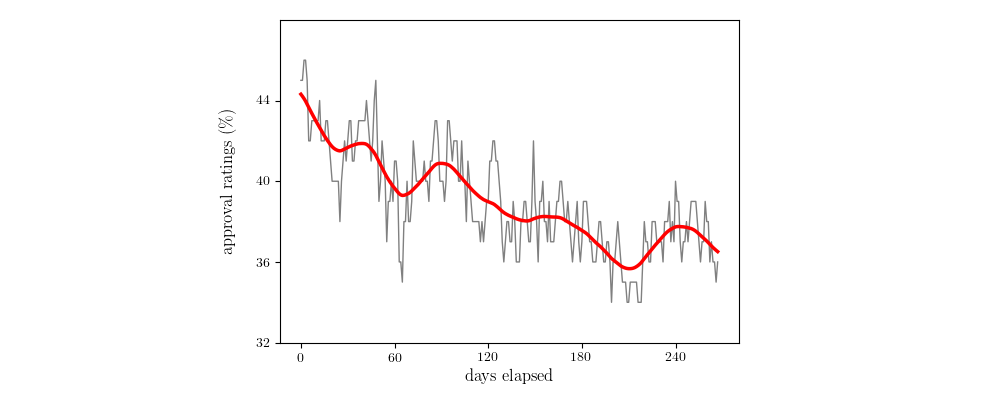
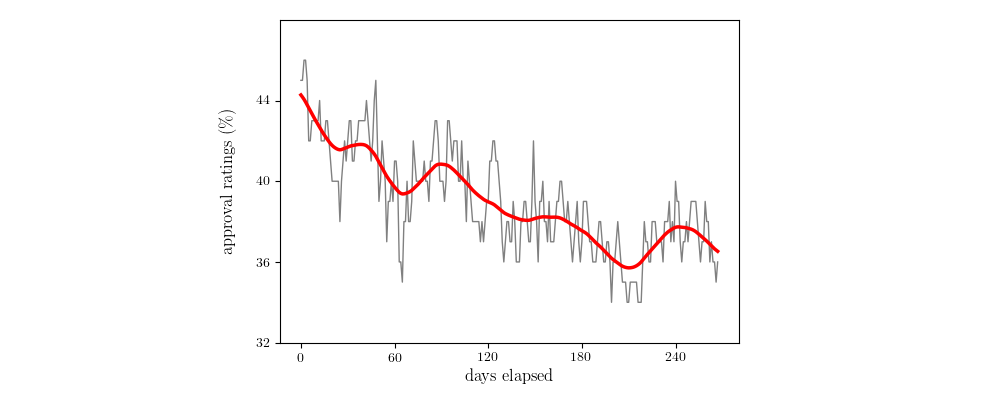
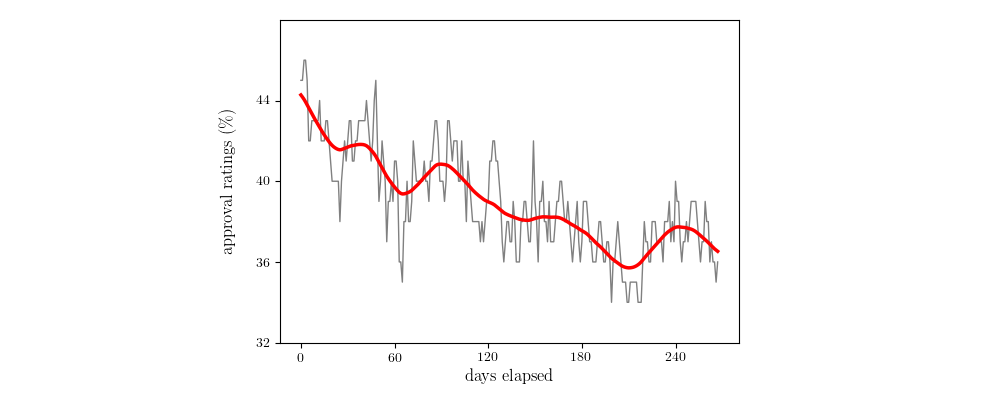
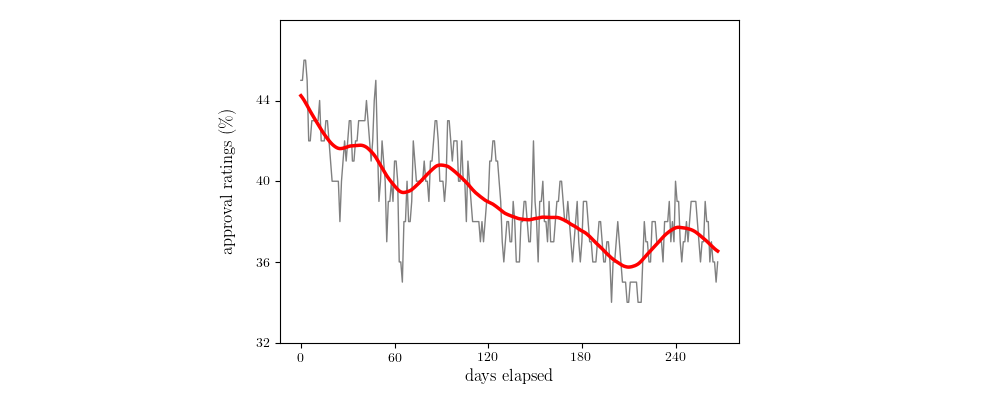
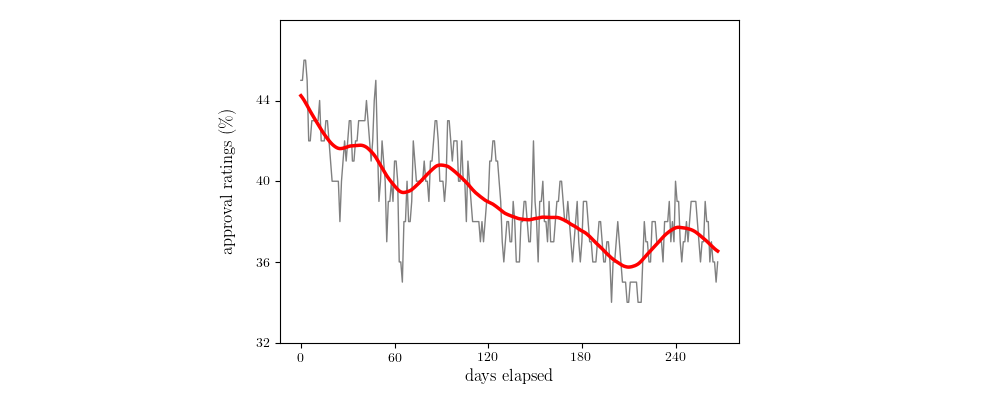
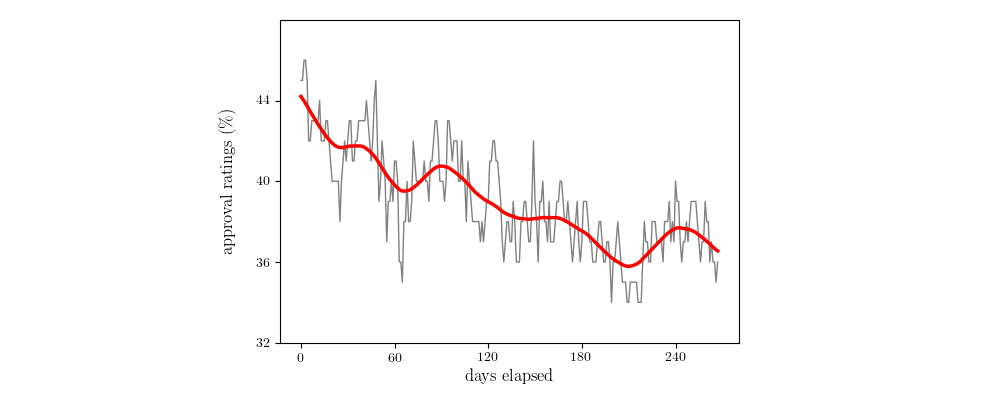
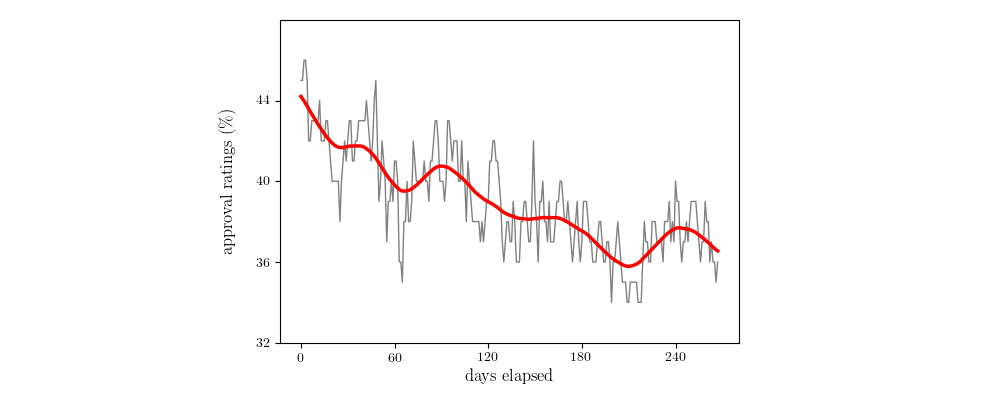
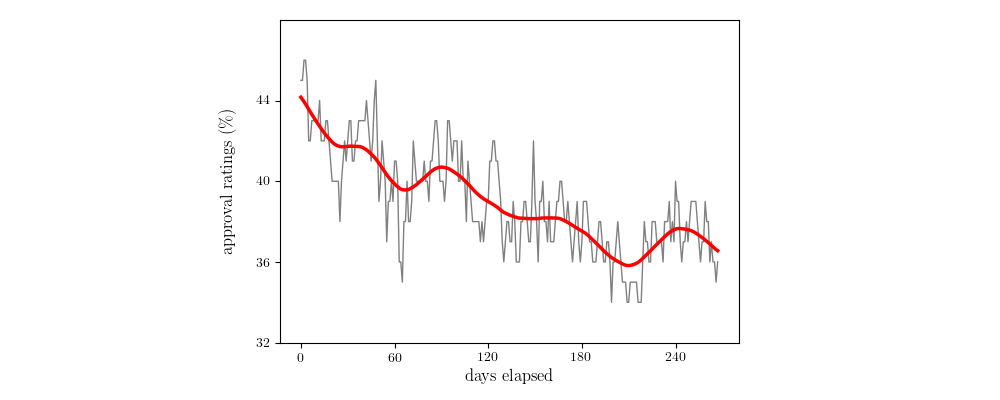
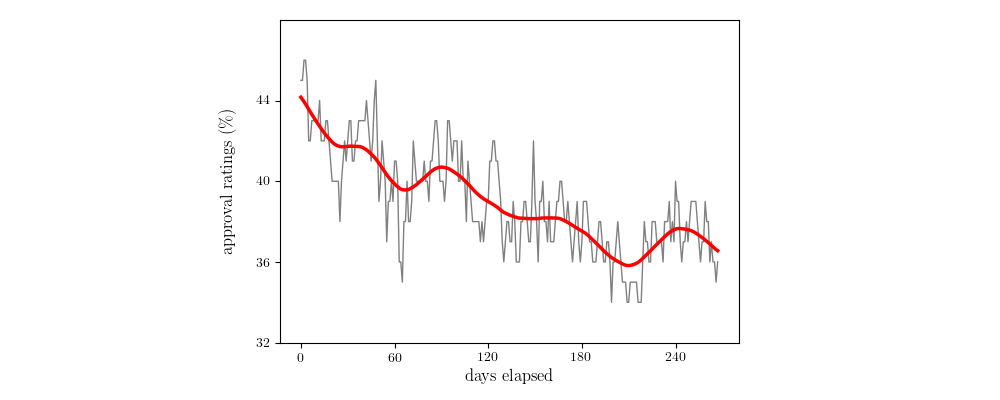
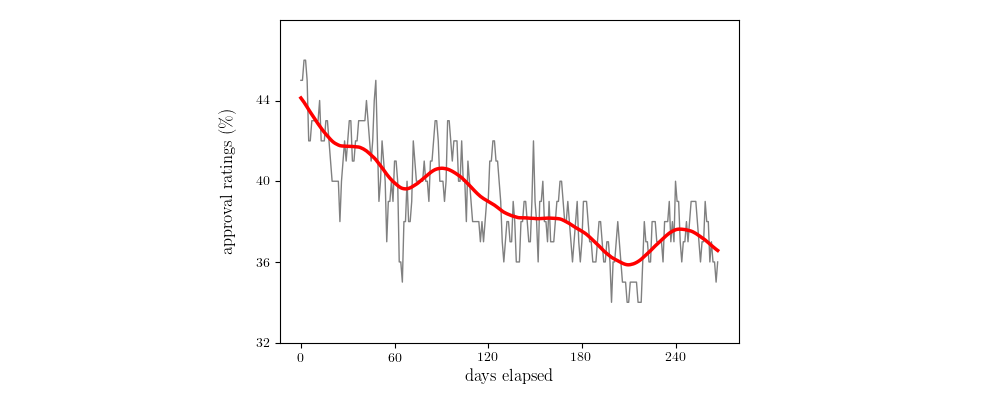
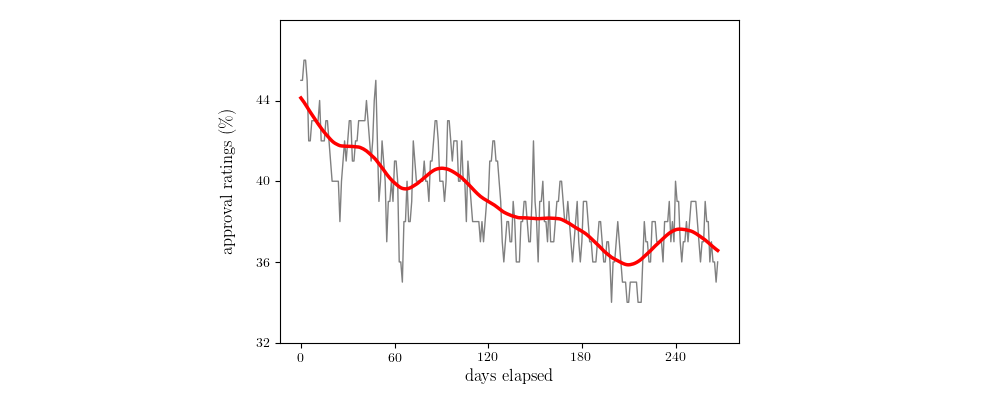
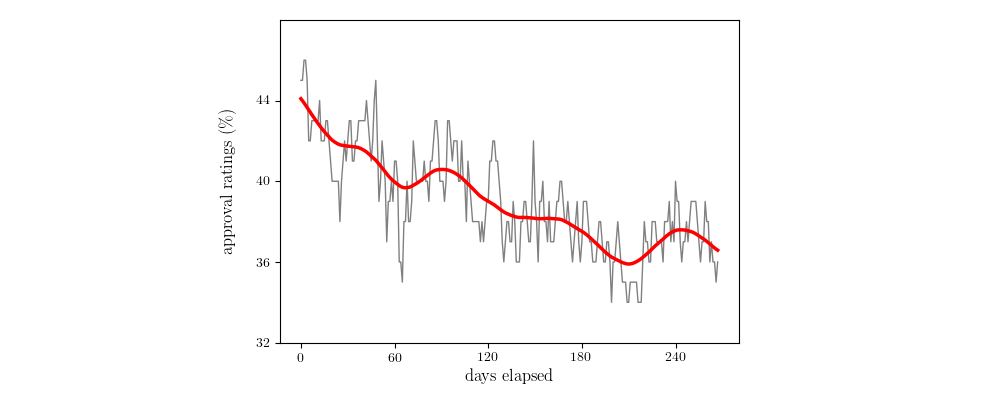
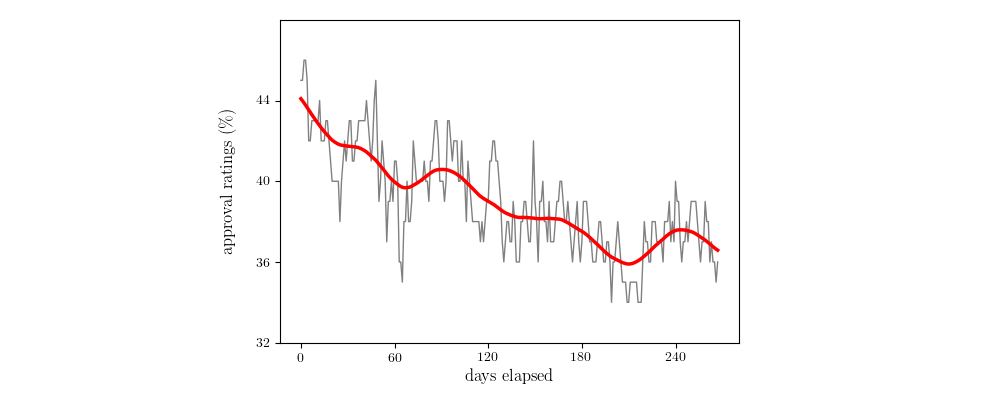
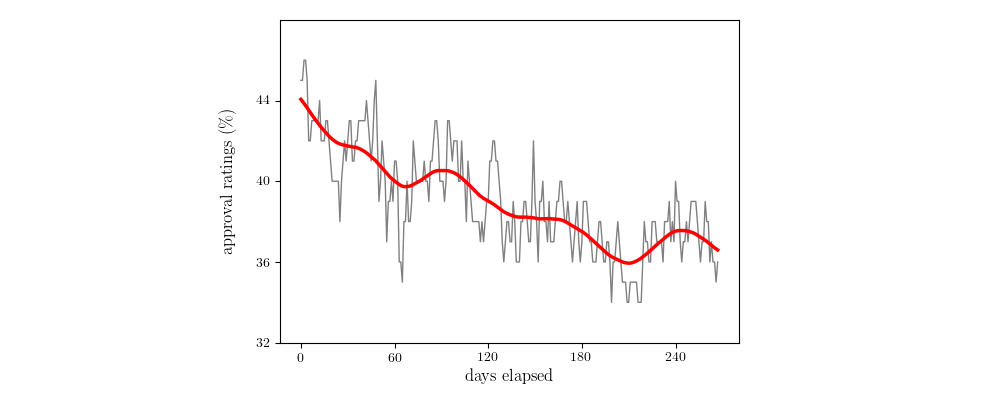
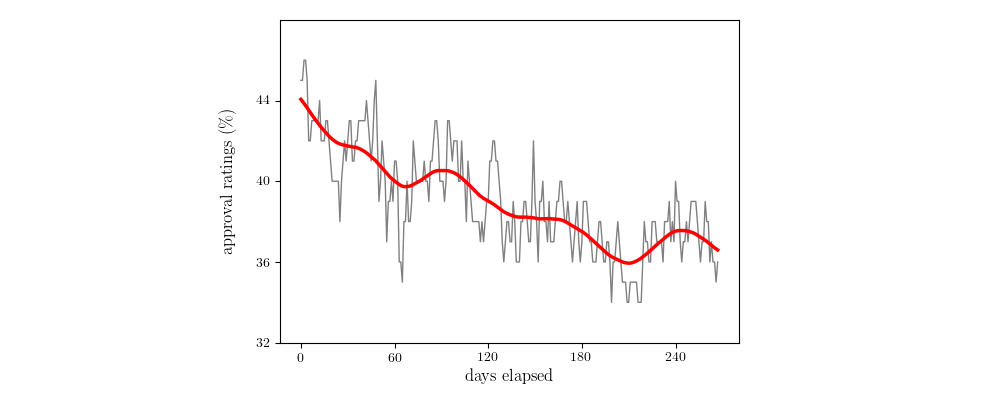
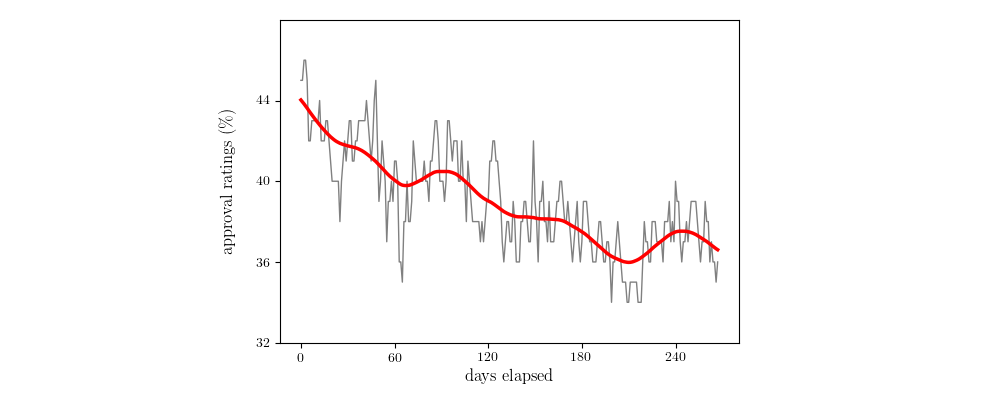
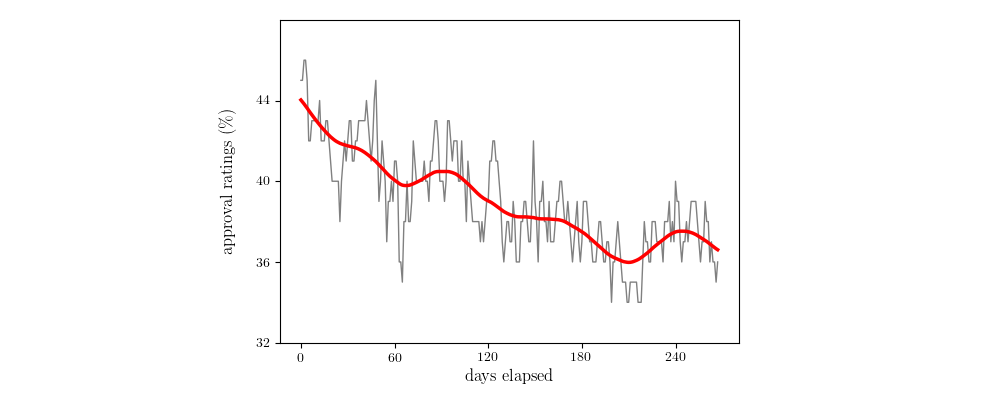
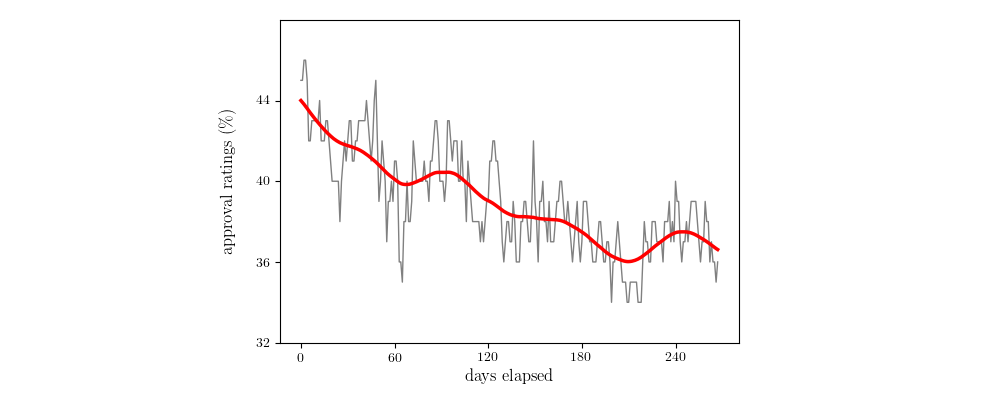
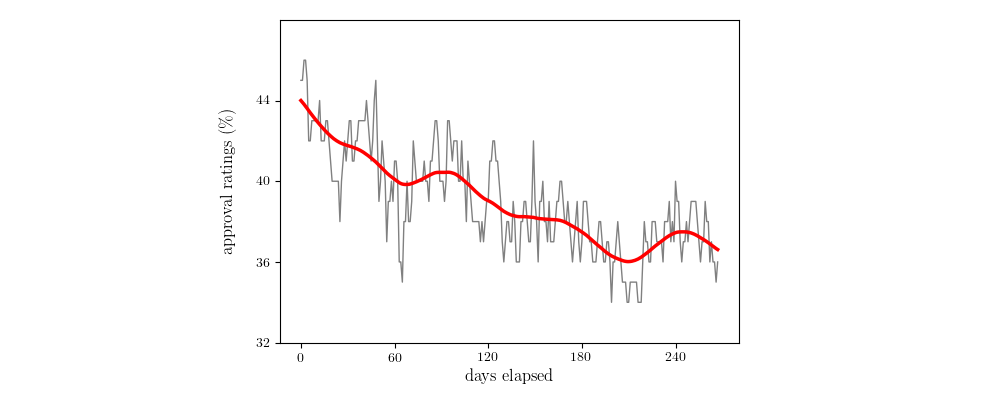
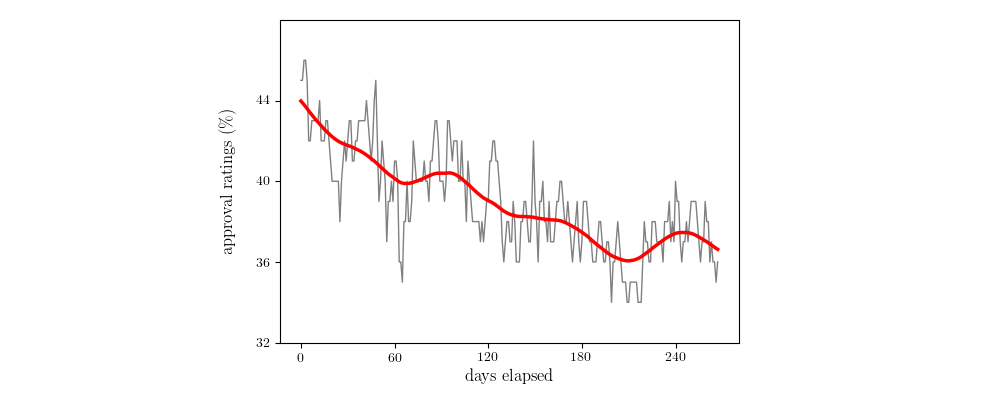
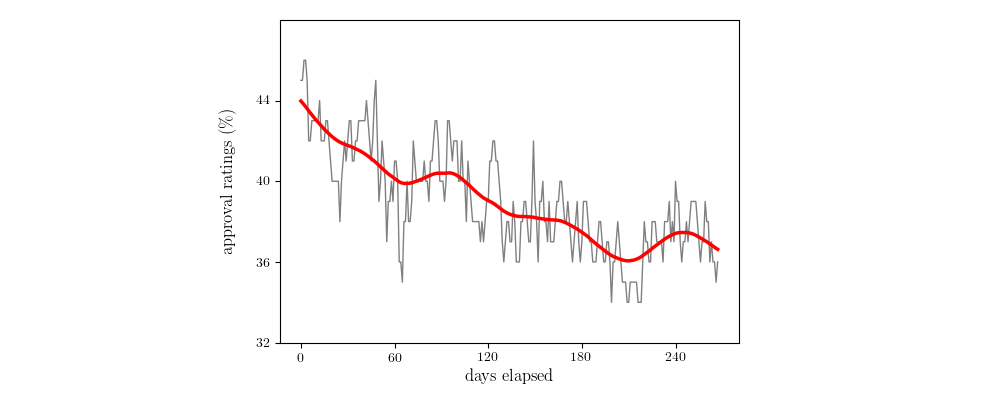
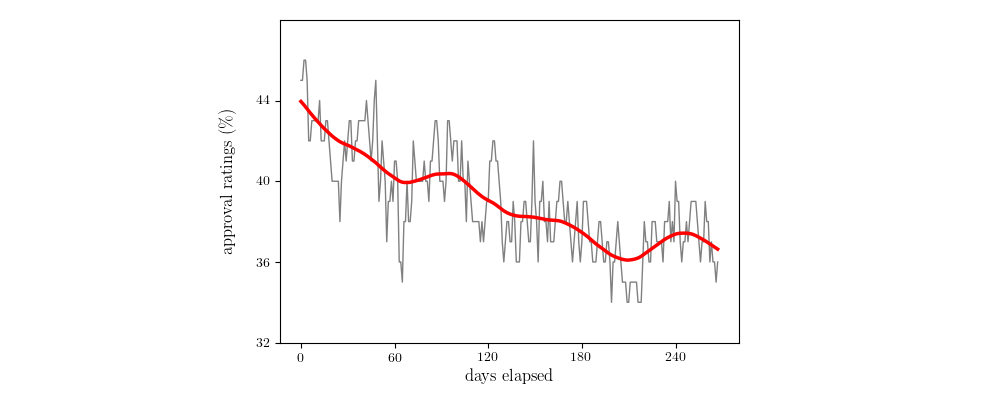
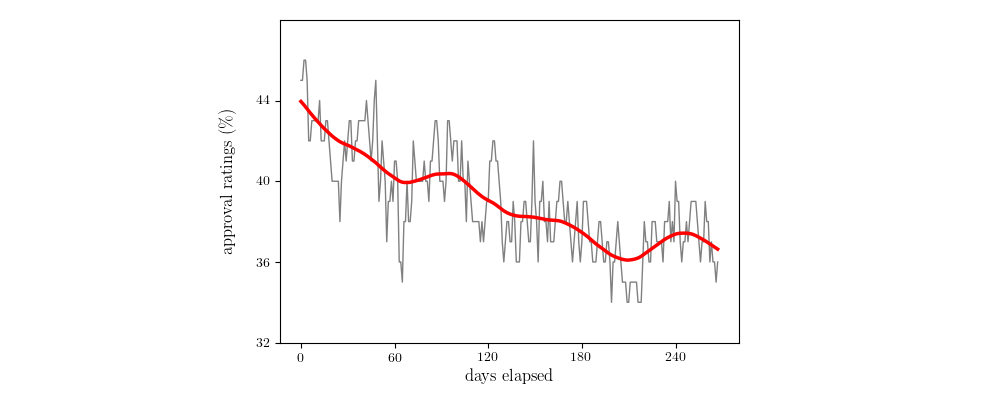
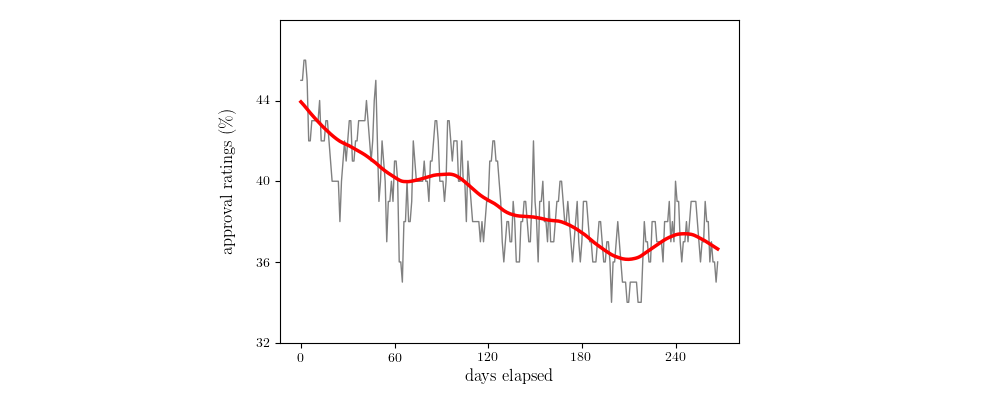
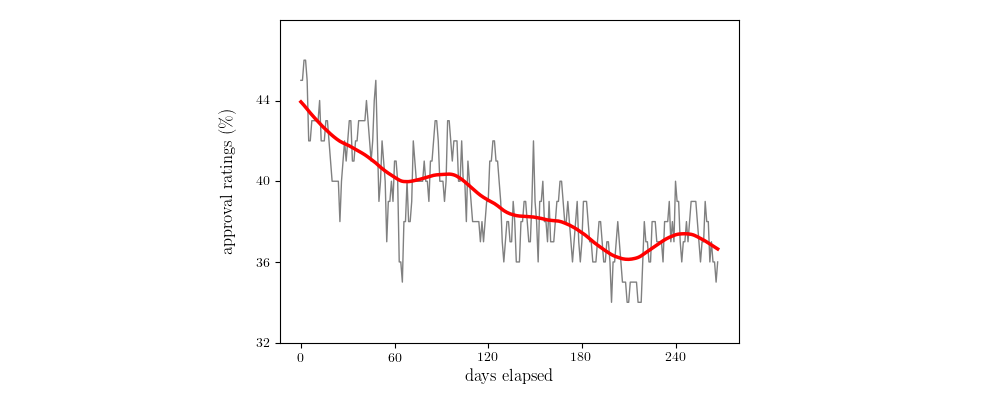
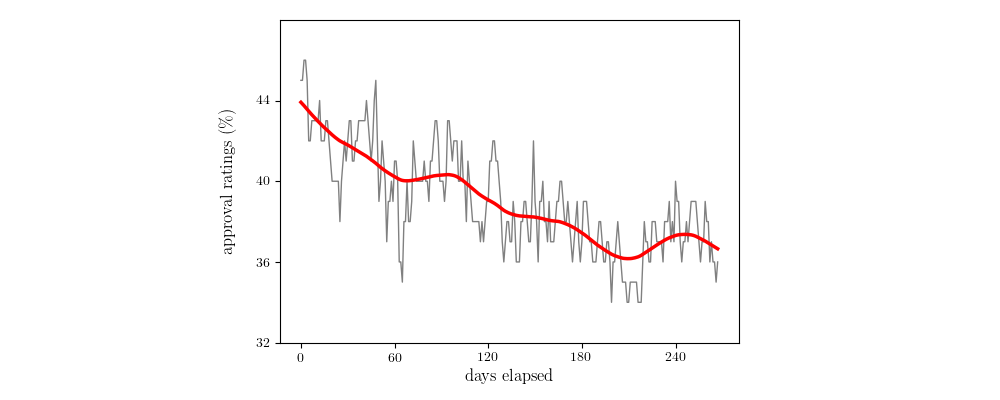
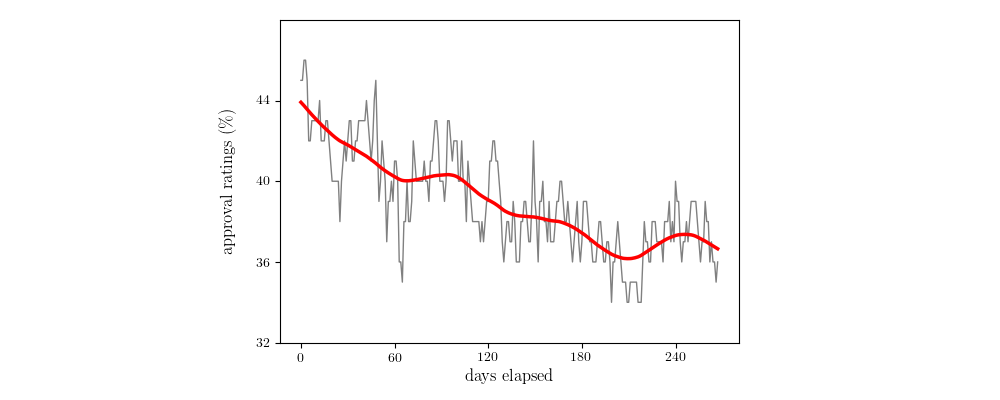
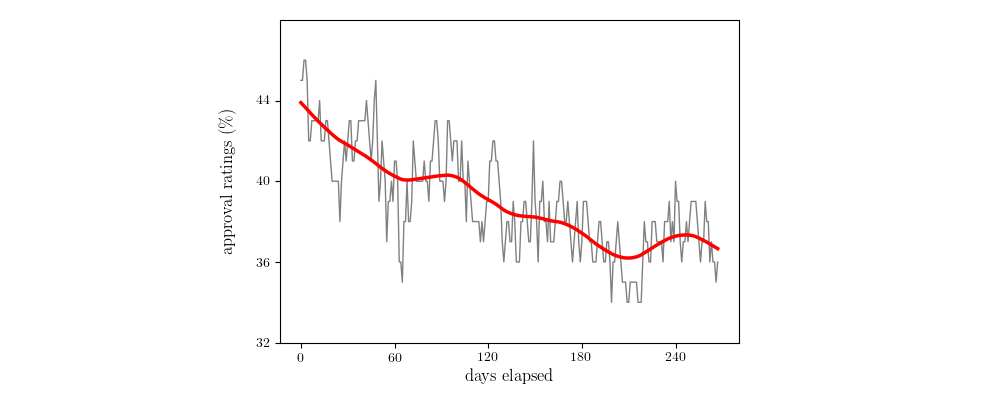
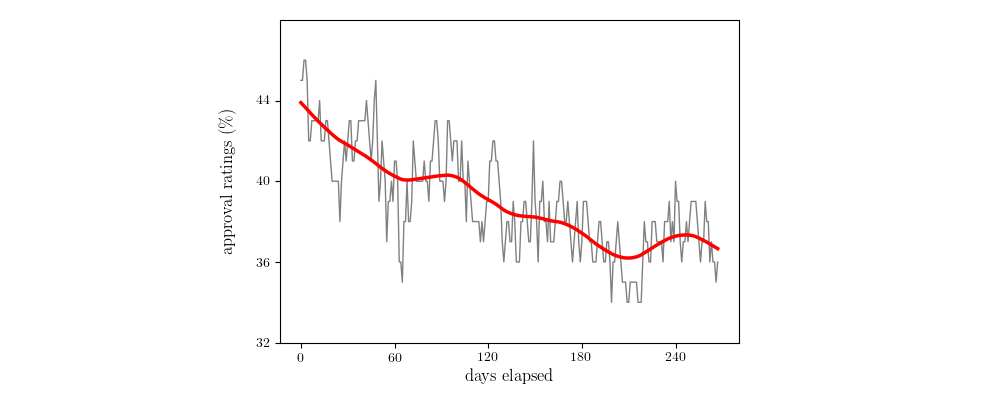
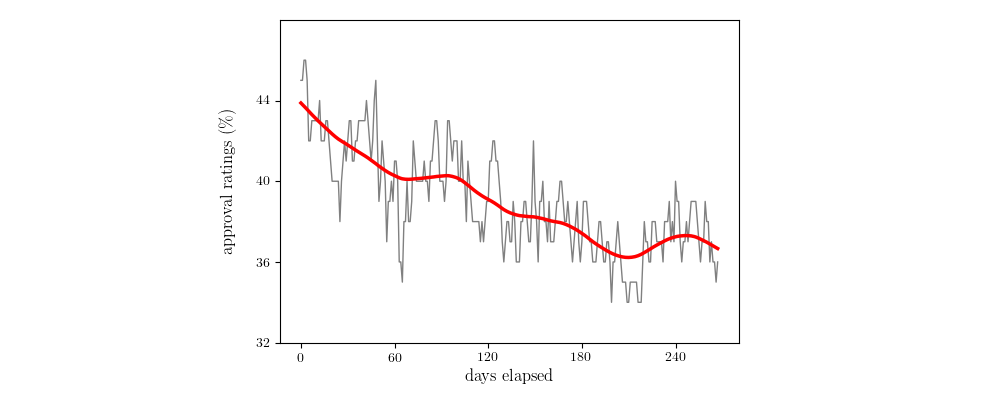
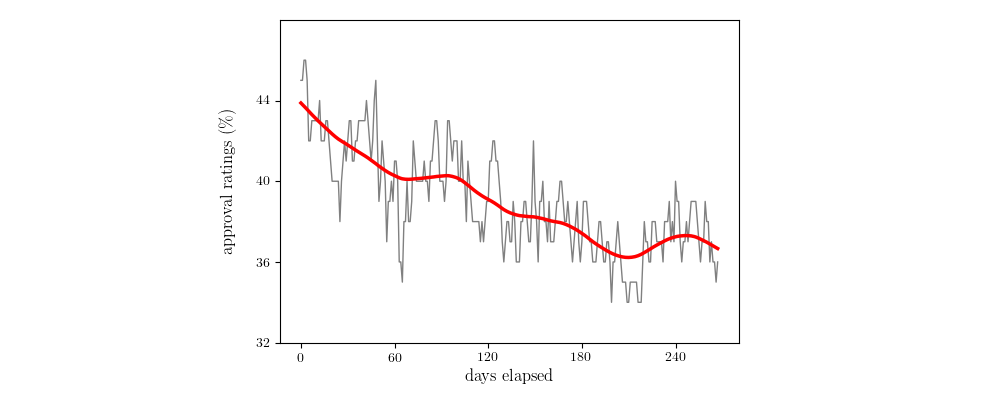
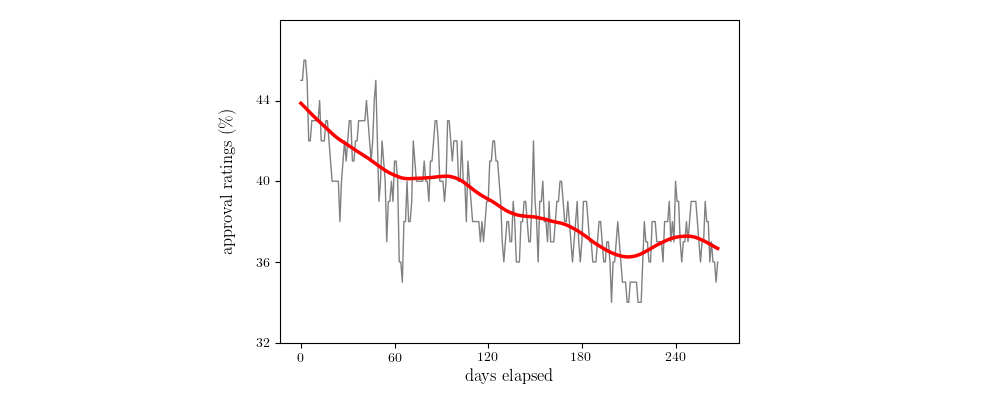
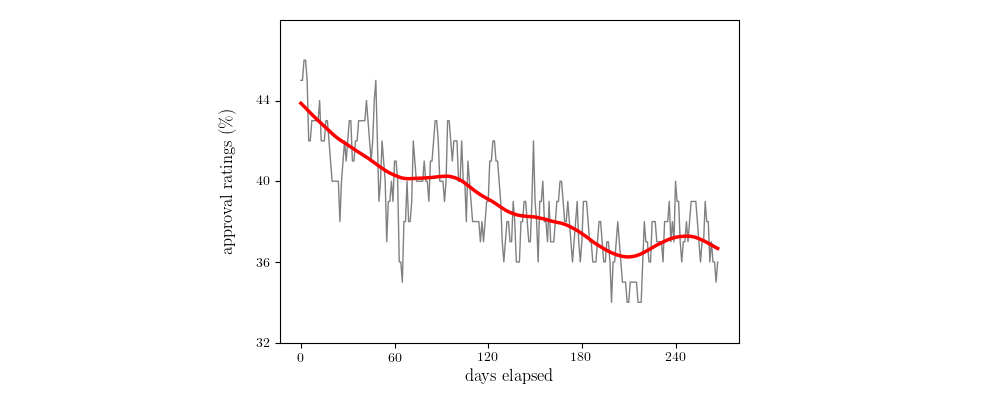
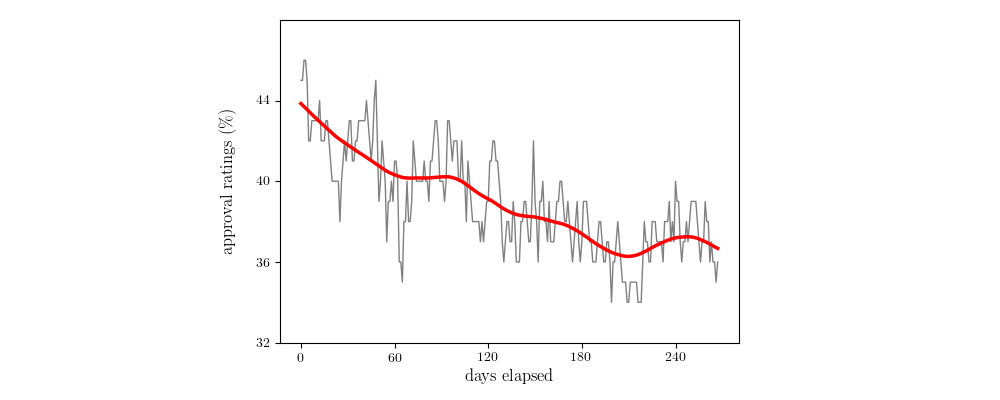
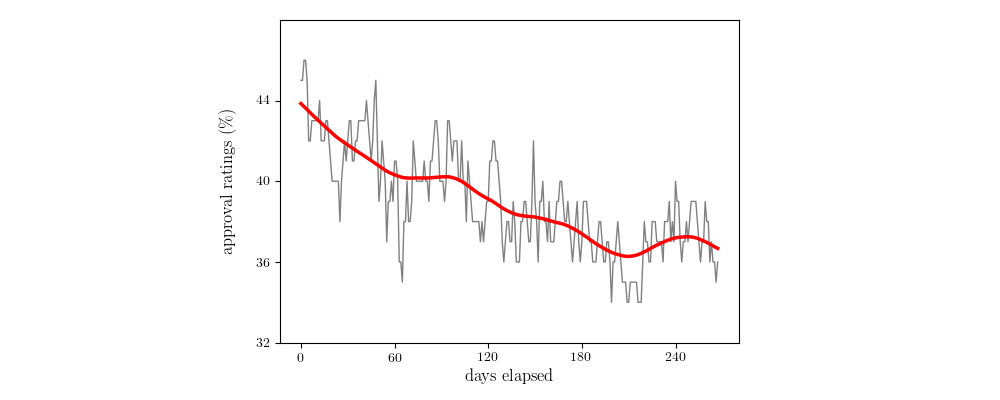
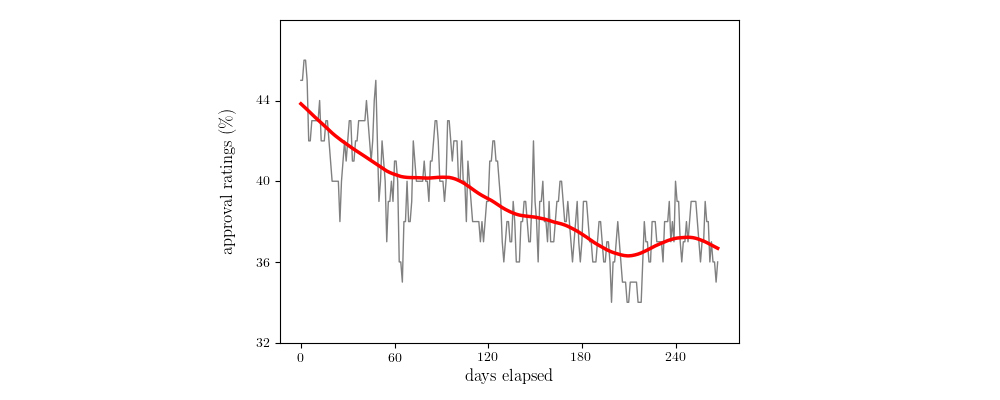
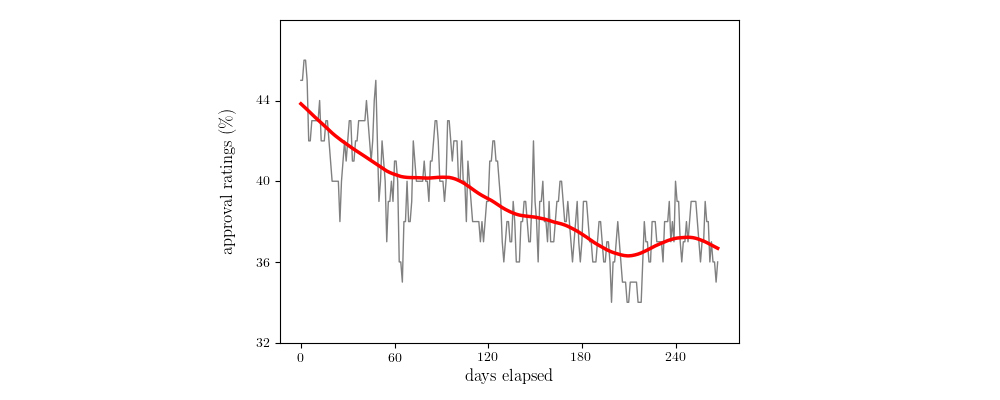
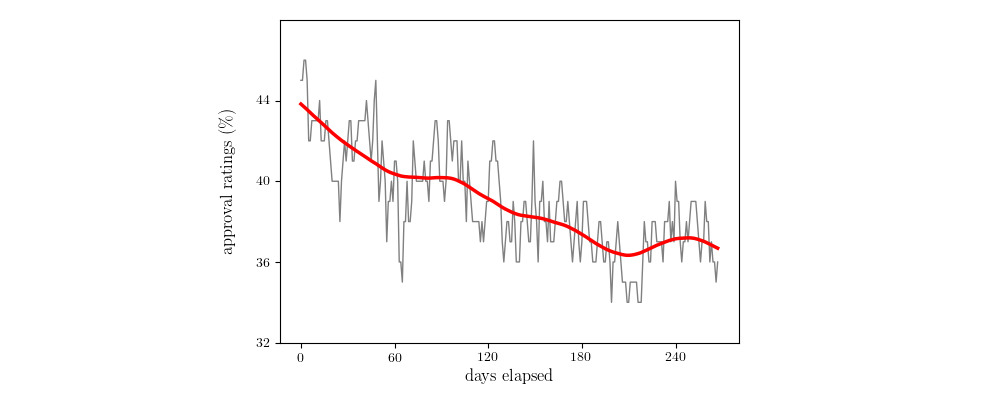
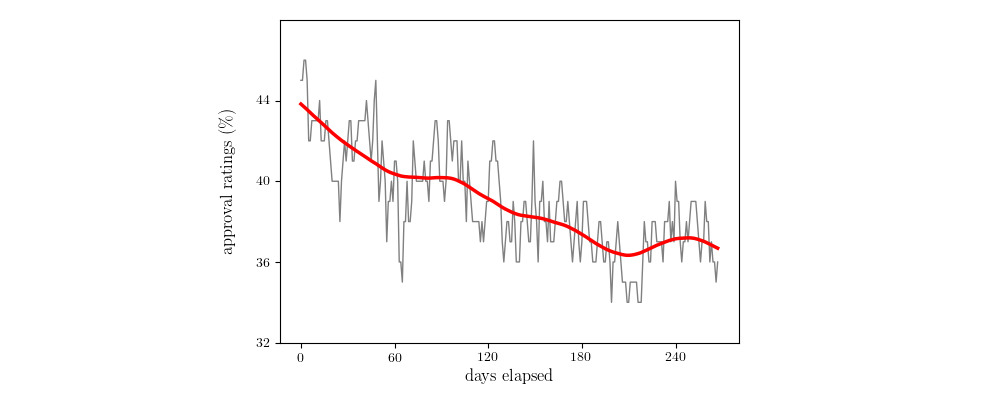
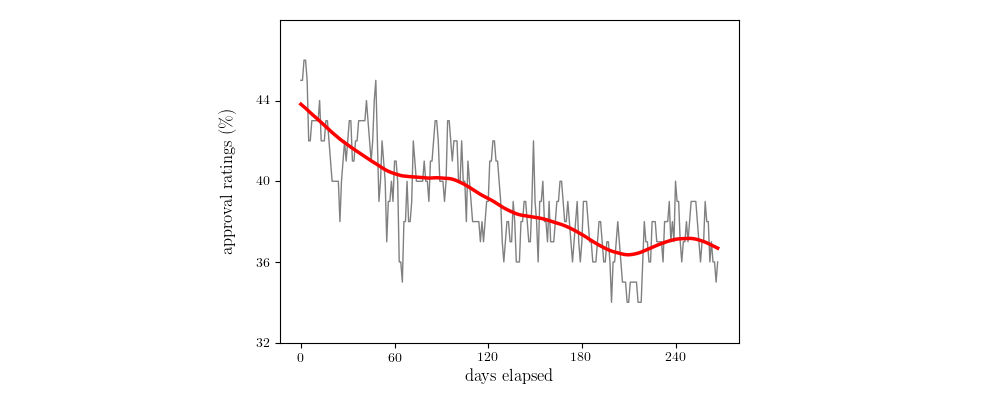
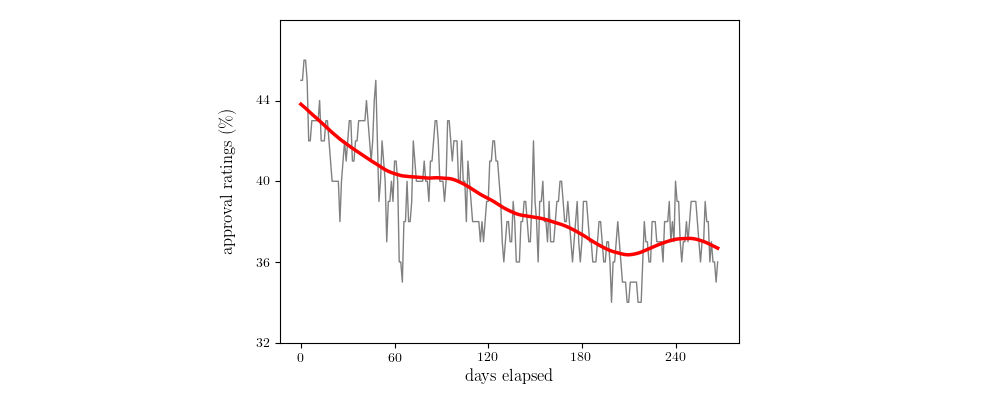
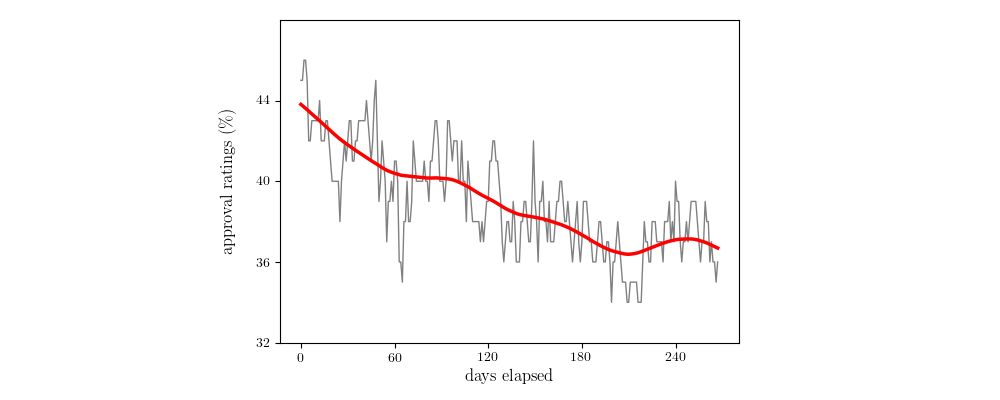
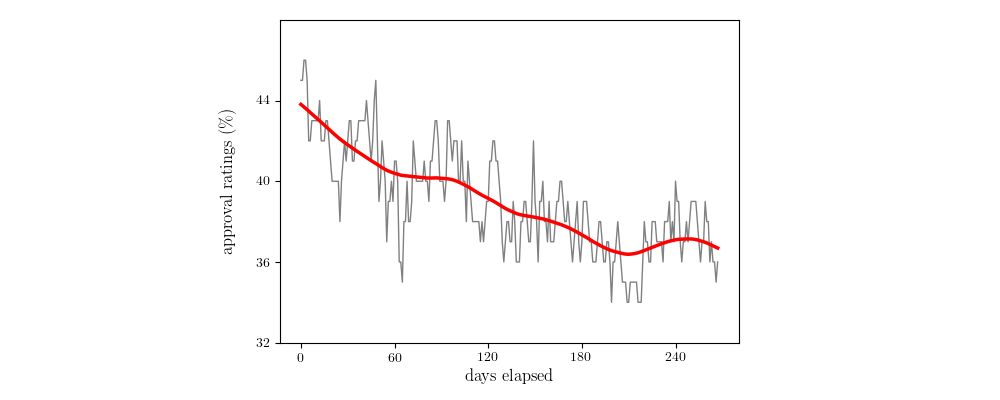
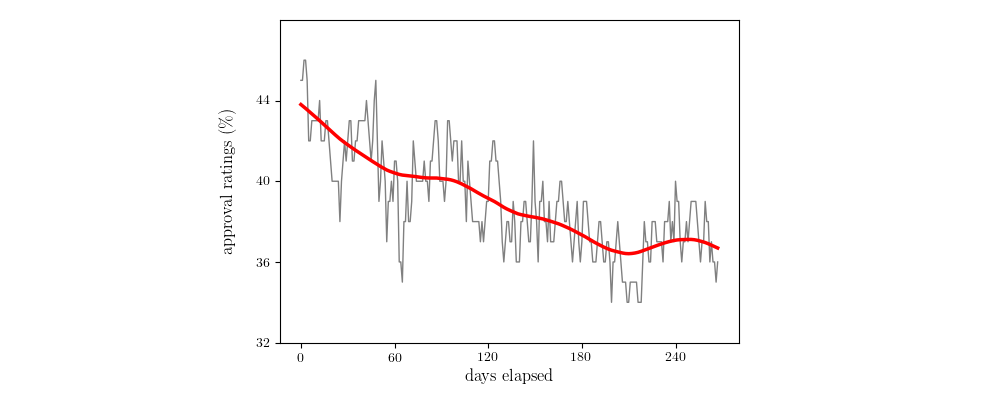
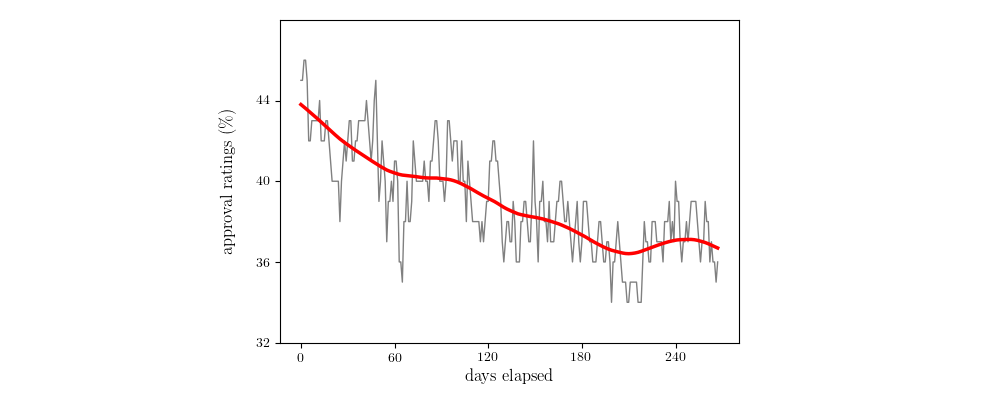
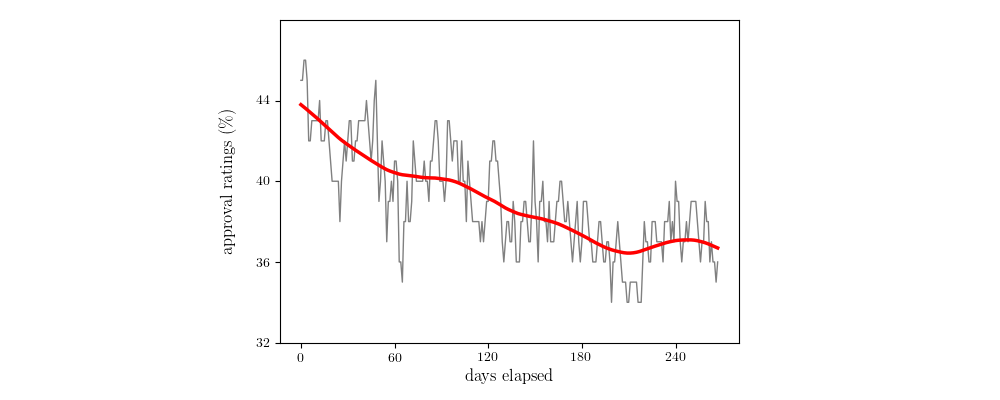
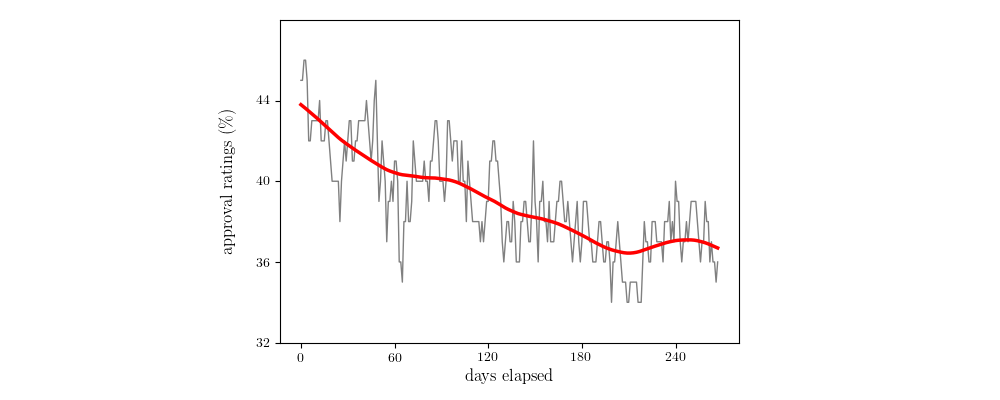
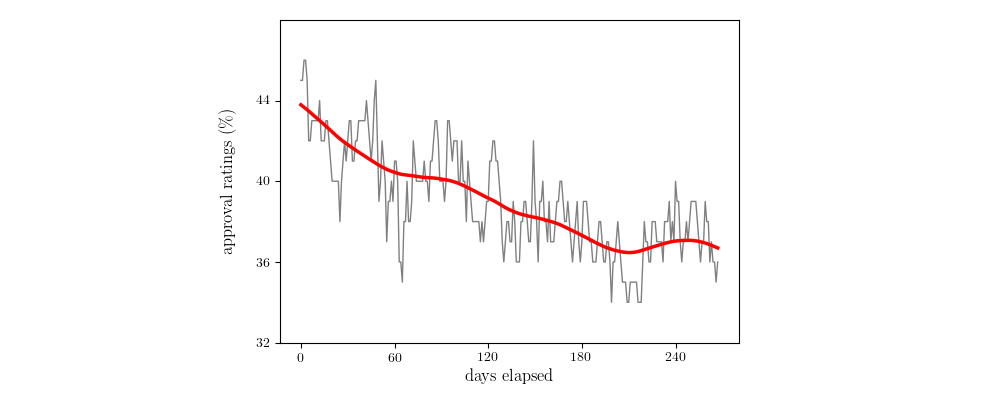
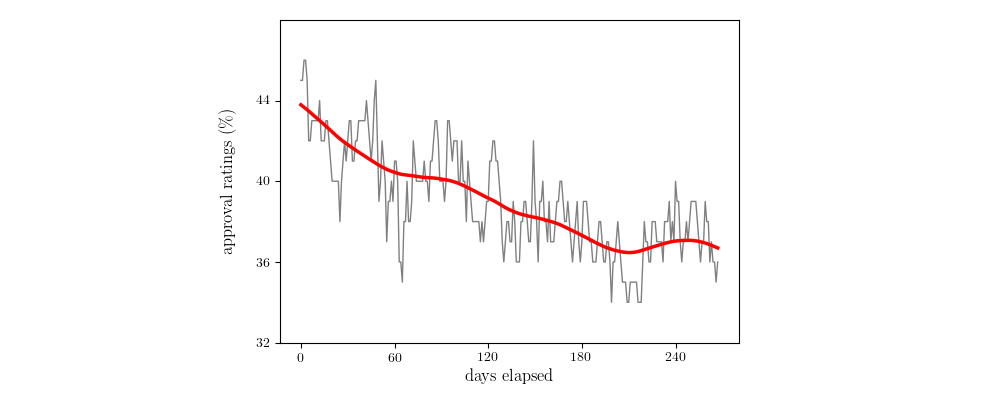
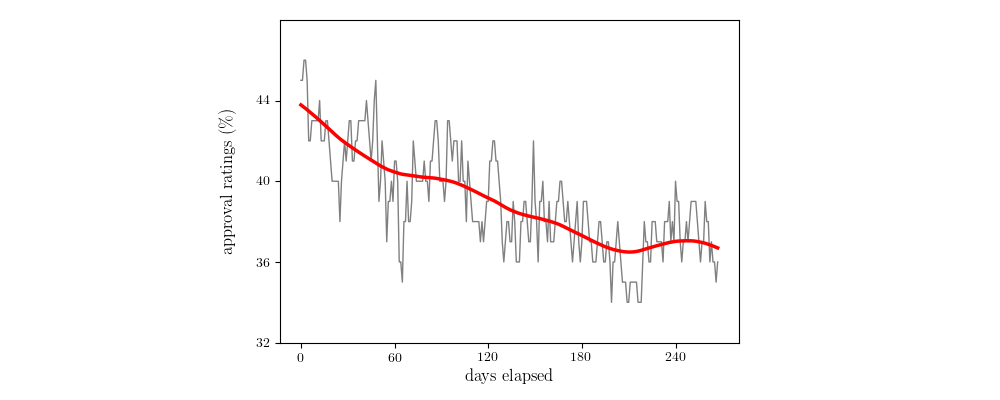
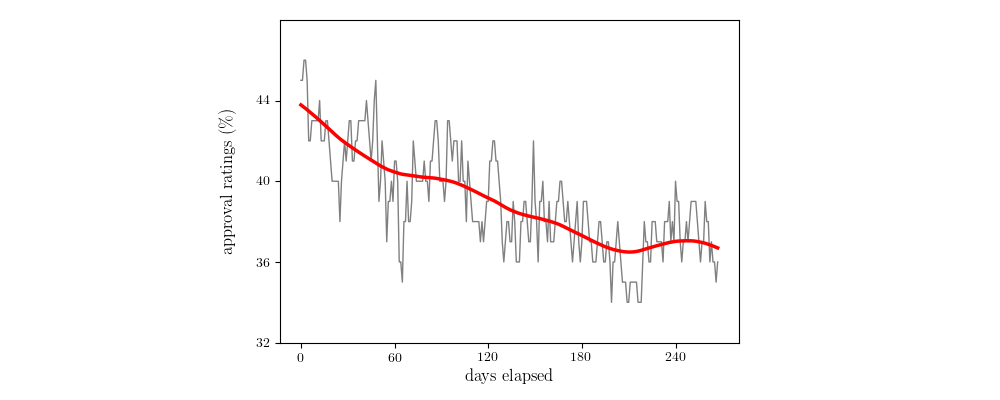
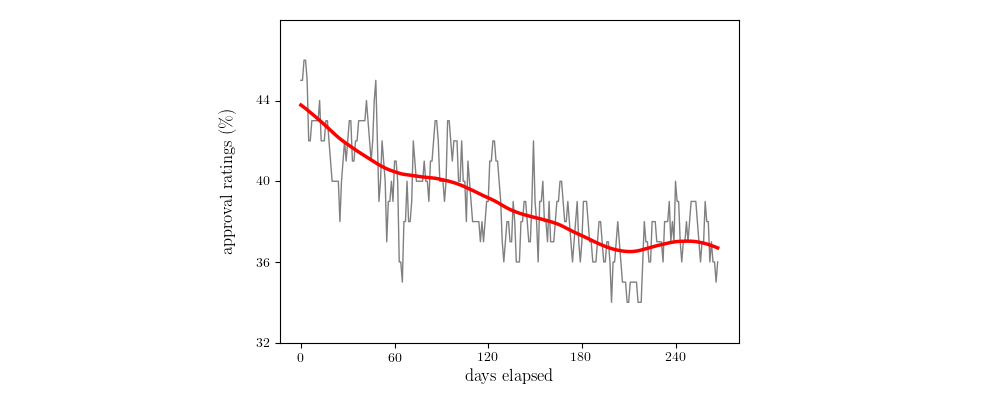
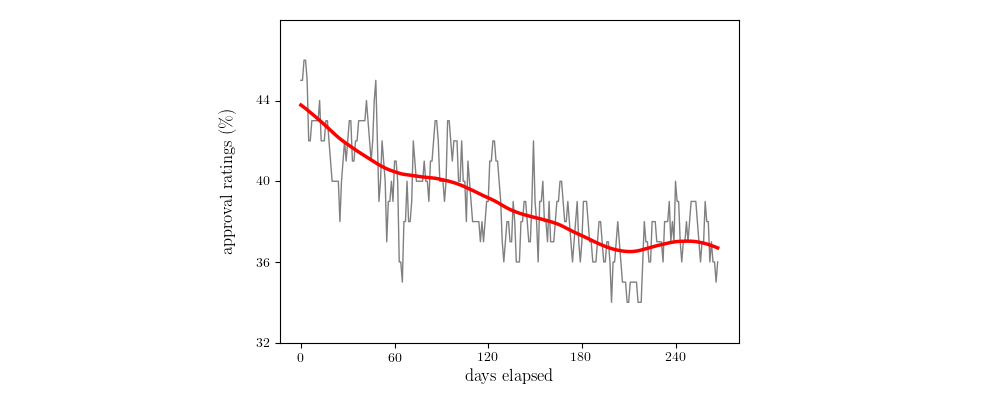
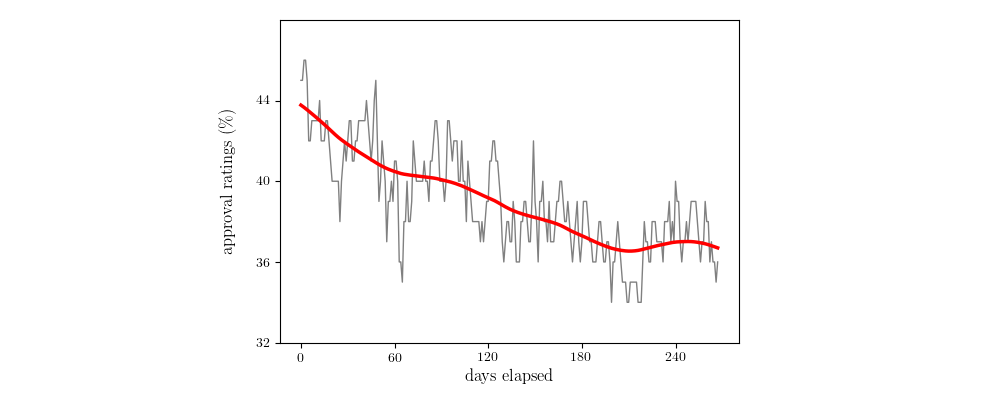
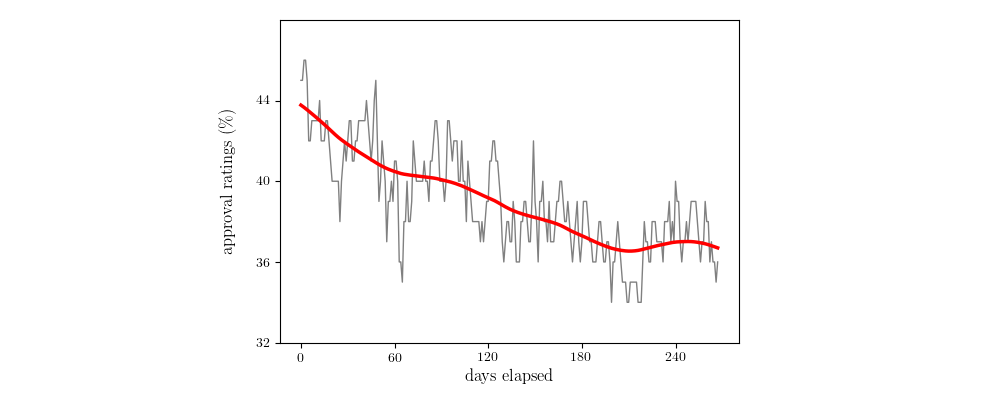
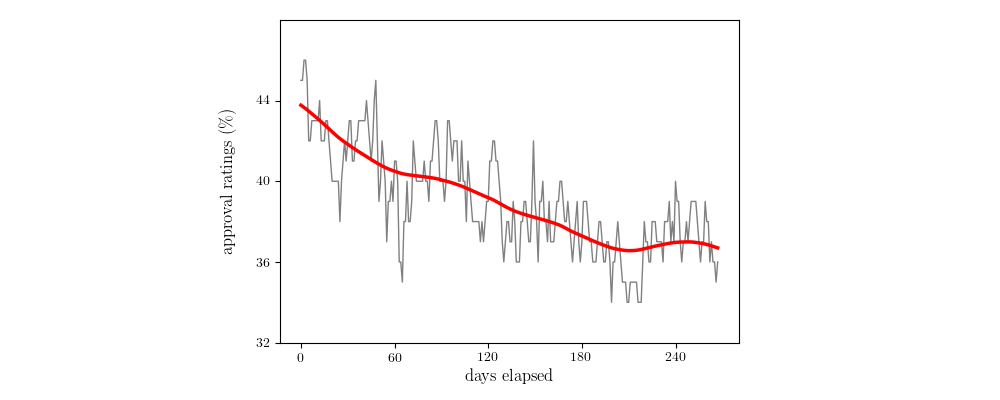
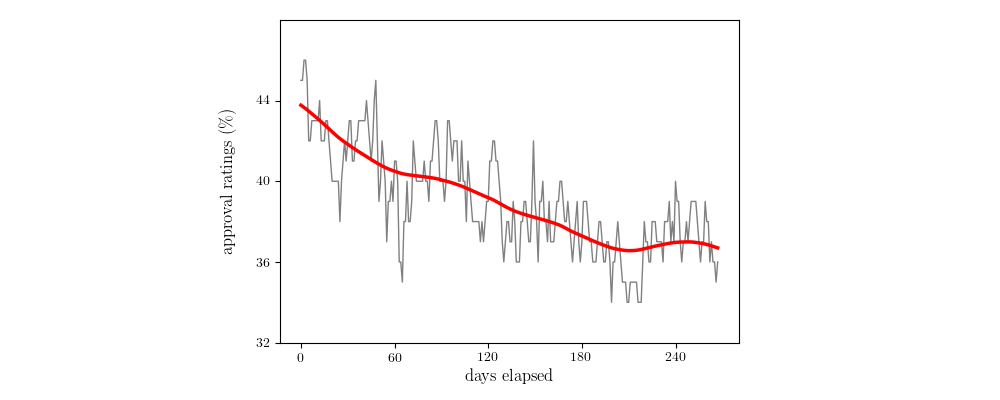

In [52]:
# create an instance of the visualizer
conv_viz = convlib.conv_1d_viz.visualizer(path = data_path)

# run the visualizer for our chosen input sequence
conv_viz.draw_it(num_frames=100, weights='non-uniform')

As you can see our new weighting scheme results in a smoother recovery of the signal $s$ compared to Example 2 where we used uniform weights.   

<hr>

The operation between the weight sequence $w$ and the sequence $x$ on the right hand side of (8) has been given the name *cross-correlation*. Denoted by $y=w*x$, the cross-correlation $y$ between $w$ (a sequence of length $2L+1$ defined over the range $-L,\ldots,+L$) and $x$ (an $N$-length sequence defined over the range $1,\ldots,N$) is a sequence with same length and range as $x$, defined entry-wise as  

\begin{equation}
y_n = \underset{\ell=-L}{\overset{L}{\sum}}{w_\ell\,x_{n+\ell}}, \qquad n=1,2,\ldots,N
\end{equation}

When $x$ has finite length (which is always the case in machine learning), we must extend its domain to outside its original range so that $y$ in equation (11) can be defined at its two extremes. In other words, in order for $y$ to be defined for every $1\leq n\leq N$ we must add $L$ entries to both the beginning and end of $x$ so that for every $n$, $x$ is defined in an $L$-vicinity of $n$. This is called *padding* in the parlance of machine learning and signal processing. How we pad $x$ is for the most part inconsequential, particularly when $L$ is relatively small. In Figure 3 we show three common ways to pad a sample sequence: (i) zero-padding (shown in red) where $x$ is padded with zeros from both sides, (ii) constant-padding (shown in blue) where $x$ is padded with $x_1$ from the left and with $x_N$ from the right, and (iii) symmetric padding (shown in yellow) where x is mirrored around $x_1$ on the left, and around $x_N$ on the right.     

<figure>
<img src="../../mlrefined_images/convnet_images/paddings.png" width="70%" height="auto"/>
<figcaption> <strong>Figure 3:</strong> <em> Padding of an original sequence $x$ (in black) with $L=3$ entries via zero padding (red), constant padding (blue), and symmetric padding (yellow).</em>
</figcaption>
</figure>

What convolution does to a signal $x$ is entirely dependent on the weight sequence $w$ - sometimes referred to as the *convolution kernel*. This is not to be confused with the term kernel used in other machine learning contexts, e.g., fixed basis kernels or the kernel trick. 

For instance, with the convolution kernel

\begin{equation}
w = \left[\frac{-1}{2}, 0, \frac{1}{2}\right]
\end{equation}

the output $y=w*x$ is given in terms of $x$ as

\begin{equation}
y_n = \frac{x_{n+1}-x_{n-1}}{2}, \qquad n=1,2,\ldots,N
\end{equation}

The output in (13), sometimes called a difference quotient, can be thought of (loosely) as a discrete derivative for the sequence $x$.

#### <span style="color:#a50e3e;">Example 4. </span>  Discrete derivative via convolution

In the Python cell below we plot the input sequence 

\begin{equation}
x_n = \text{sin}\left(n\right), \qquad n=1,2,\ldots,15
\end{equation}

along with its discrete derivative in (13) given by

\begin{equation}
y_n = \frac{\text{sin}\left(n+1\right)-\text{sin}\left(n-1\right)}{2}, \qquad n=1,2,\ldots,15
\end{equation}

as well as its 'true' derivative (in the continuous sense)

\begin{equation}
z_n = \text{cos}\left(n\right), \qquad n=1,2,\ldots,15
\end{equation}






<IPython.core.display.Javascript object>


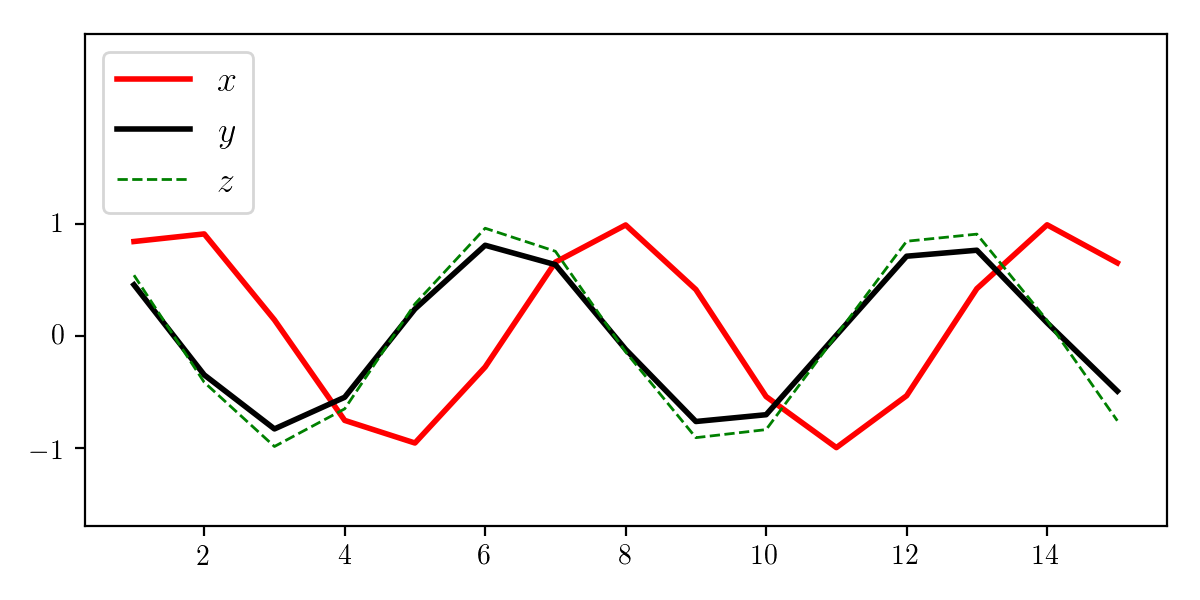

In [181]:
n = np.arange(1,16)
x = np.sin(n)
z = np.cos(n)

# zero-padding
x_p = np.append(0,x)
x_p = np.append(x_p,0)

y = [.5*(x_p[i+1]-x_p[i-1]) for i in n]

# plot
convlib.conv_1d_viz.plot_sequence(n,x,y,z)

<a id='bib_cell'></a>

## References

[1] Data taken from http://www.presidency.ucsb.edu/data/popularity.php